In [157]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

In [158]:
df = pd.read_csv('data/final_combined_dataset.csv')

In [159]:
# geocode_list = [3303807]
# df = df[df['geocode'].isin(geocode_list)]

In [160]:
df['week'] = pd.to_numeric(df['week'], errors='coerce')
df['date'] = pd.to_datetime(df['date'])

# Add date_ordinal
df['date_ordinal'] = df['date'].apply(lambda x: x.toordinal())

# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# sum of cases each year
cases_sum = df.groupby(['year'])['cases'].sum().reset_index()

print(cases_sum)

# Add cyclic month representation
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Add cyclic week representation
df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)

    year   cases
0   2012  254010
1   2013  256911
2   2014   15150
3   2015   94824
4   2016  112646
5   2017   17257
6   2018   25184
7   2019   50378
8   2020    8021
9   2021    5445
10  2022   23100


In [161]:
# Step 2: Create lag features
def create_lags(dataframe, group_col, target_col, lags, inplace = False):
    if isinstance(target_col, list):  # If target_col is a list of columns
        for col in target_col:
            for lag in lags:
                if inplace:
                    dataframe[target_col] = dataframe.groupby(group_col)[col].shift(lag)
                else:
                    dataframe[f'{col}_lag{lag}'] = dataframe.groupby(group_col)[col].shift(lag)
    else:  # If target_col is a single column
        for lag in lags:
            if inplace:
                dataframe[target_col] = dataframe.groupby(group_col)[target_col].shift(lag)
            else:
                dataframe[f'{target_col}_lag{lag}'] = dataframe.groupby(group_col)[target_col].shift(lag)
    return dataframe

# Lag cases by 1 and 2 weeks
data = create_lags(df, group_col='city', target_col='cases', lags=[0, 1, 2])

# Lag weather-related variables by 5 and 6 weeks for each city
weather_columns = ['tempe_min', 'temp_avg', 'temp_max', 'humidity_max', 'humidity_avg', 'humidity_min',
                   'precipitation_avg_ordinary_kriging', 'precipitation_max_ordinary_kriging',
                   'precipitation_avg_regression_kriging', 'precipitation_max_regression_kriging']
data = create_lags(data, group_col='city', target_col=weather_columns, lags=[1, 2])

# data = create_lags(data, group_col='city', target_col='nearby_cases_weighted', lags=[4])

# lag cases -4 weeks
data = create_lags(data, group_col='city', target_col='cases', lags=[-2], inplace = True)

data = data.dropna().reset_index(drop=True)

In [162]:
# Step 4: Scale continuous variables, including lagged variables
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

continuous_vars = ['tempe_min', 'temp_avg', 'temp_max', 'humidity_max', 'humidity_avg', 'humidity_min',
                   'precipitation_avg_ordinary_kriging', 'precipitation_max_ordinary_kriging',
                   'precipitation_avg_regression_kriging', 'precipitation_max_regression_kriging',
                   'cases_per_100k', 'nearby_cases_weighted']
# Include lagged variables in the scaling process
lagged_vars = [col for col in data.columns if any(lag in col for lag in ['_lag1', '_lag2', '_lag5', '_lag6'])]
scaler_vars = continuous_vars + lagged_vars
data[scaler_vars] = feature_scaler.fit_transform(data[scaler_vars])

# Scale the target variable
scaled_cases = target_scaler.fit_transform(data[['cases']])
data['scaled_cases'] = scaled_cases

In [163]:
# Step 5: Split the data into training and testing sets based on time
train_data = data[(data['week'] >= 201201) & (data['week'] <= 202052)]
test_data = data[(data['week'] > 202052)]

columns_exclude = ['date', 'cases', 'scaled_cases', 'geocode', 'lat', 'long', 'population', 'cases_per_100k', 'year', 'month']

X_train = train_data[[col for col in data.columns if col not in columns_exclude]]
y_train = train_data['scaled_cases']
X_test = test_data[[col for col in data.columns if col not in columns_exclude]]
y_test = test_data['scaled_cases']

In [164]:
from sklearn.preprocessing import LabelEncoder

# Ensure you're working with a copy of the DataFrame if necessary
X_train = X_train.copy()  # If it's a slice, we create a new copy
X_test = X_test.copy()    # Same here

# Step 1: Encode the city column
label_encoder = LabelEncoder()
X_train['city_encoded'] = label_encoder.fit_transform(X_train['city'])
X_test['city_encoded'] = label_encoder.transform(X_test['city'])

# Step 2: Drop the original city column
X_train = X_train.drop(columns=['city'])
X_test = X_test.drop(columns=['city'])

In [165]:
# Step 6: Prepare LightGBM datasets
train_dataset = lgb.Dataset(X_train, label=y_train)
test_dataset = lgb.Dataset(X_test, label=y_test, reference=train_dataset)

In [166]:
# Step 7: Define LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Step 8: Train the model with early stopping callback
callbacks = [lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)]
model = lgb.train(params, train_dataset, valid_sets=[train_dataset, test_dataset],
                  num_boost_round=1000, callbacks=callbacks)

# Step 9: Make predictions and evaluate
scaled_predictions = model.predict(X_test, num_iteration=model.best_iteration)
# Inverse transform predictions to original scale
y_pred = target_scaler.inverse_transform(scaled_predictions.reshape(-1, 1))

# Step 10: Save the model
model.save_model('lightgbm_dengue_model.txt')

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.426696	valid_1's rmse: 0.0274646
Early stopping, best iteration is:
[102]	training's rmse: 0.42014	valid_1's rmse: 0.0273812


Top 10 Most Important Features:
         Feature  Importance
19    cases_lag0         599
20    cases_lag1         254
21    cases_lag2         174
0           week         138
16     month_cos         120
7            vim         116
17      week_sin         108
8    vim_monthly          96
42  city_encoded          94
18      week_cos          83


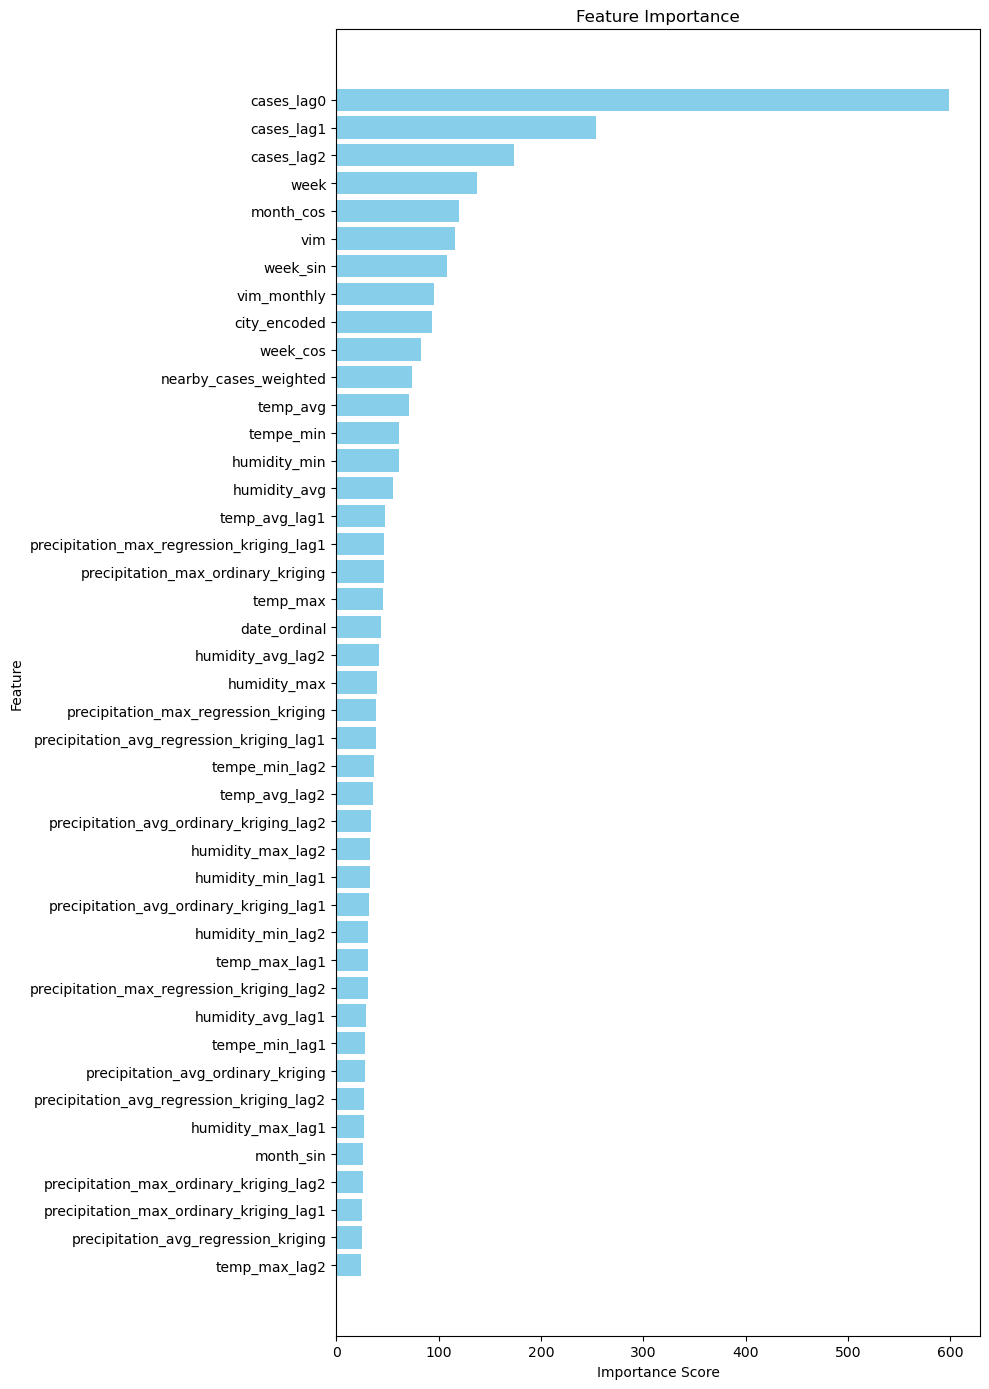

In [167]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame for feature importance
importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importance()
})

# Sort by importance
importance = importance.sort_values(by='Importance', ascending=False)

# Print top features in a neat table
print("Top 10 Most Important Features:")
print(importance.head(10))

# Visualize feature importance
plt.figure(figsize=(10, 14))
plt.barh(importance['Feature'], importance['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.tight_layout()
plt.show()


RMSE: 5.737372511191416


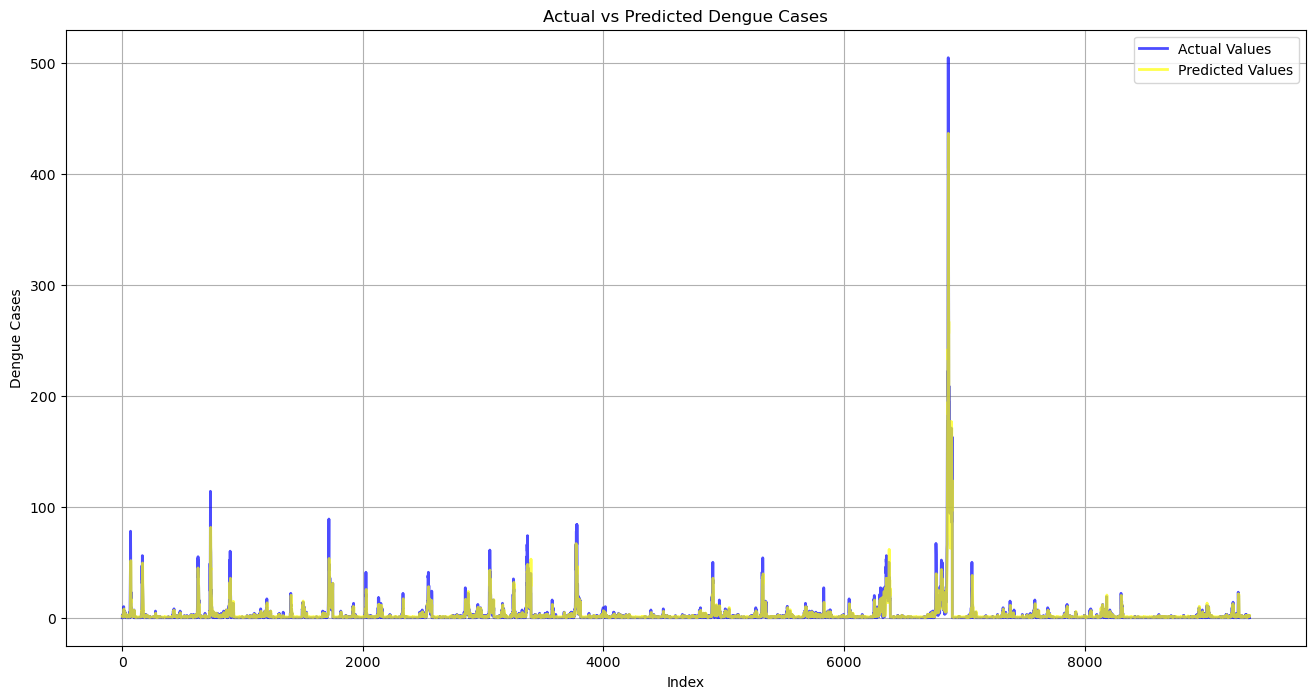

In [168]:
# Step 1: Reshape the actual target values to match the shape of predictions
y_actual = target_scaler.inverse_transform(y_test.values.reshape(-1, 1))
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
print(f'RMSE: {rmse}')

# Step 2: Plot the graph
plt.figure(figsize=(16, 8))
plt.plot(np.arange(len(y_actual)), y_actual, label='Actual Values', color='blue', alpha=0.7, linewidth=2)
plt.plot(np.arange(len(y_pred)), y_pred, label='Predicted Values', color='yellow', alpha=0.7, linewidth=2)
plt.xlabel('Index')
plt.ylabel('Dengue Cases')
plt.title('Actual vs Predicted Dengue Cases')
plt.legend()
plt.grid(True)
plt.show()

City: 0, RMSE: 7.912236914672637


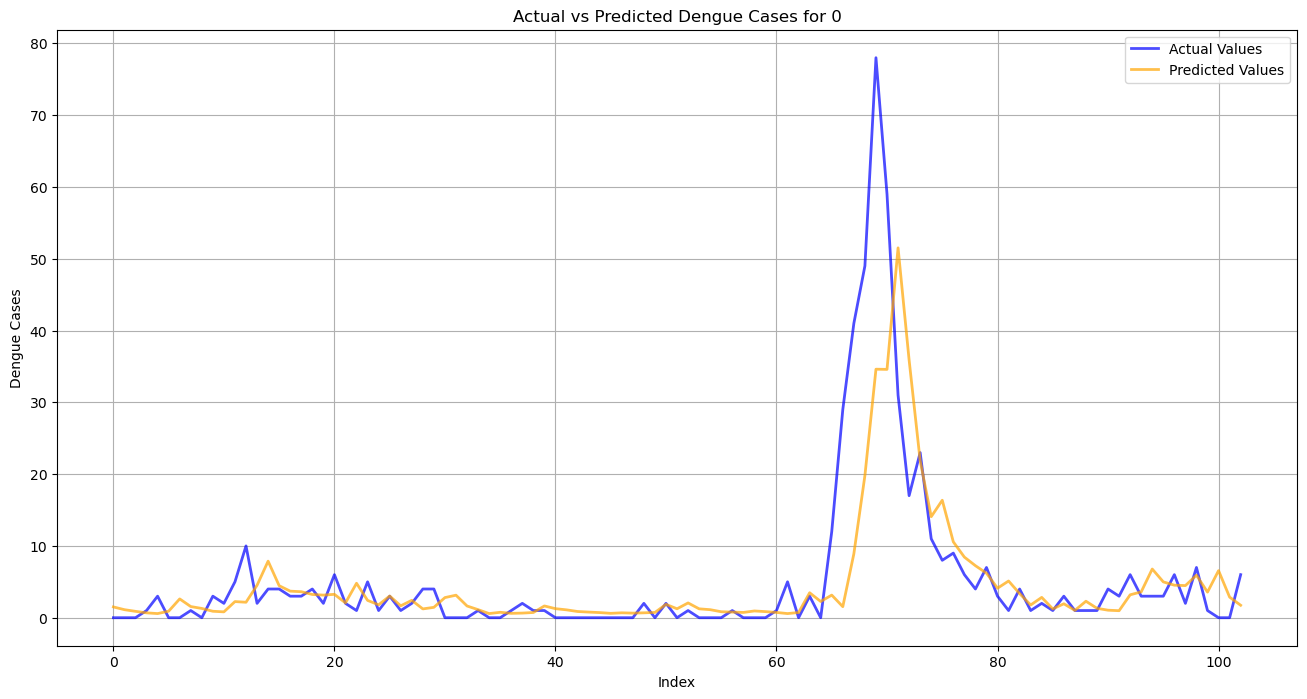

City: 1, RMSE: 5.644236880585103


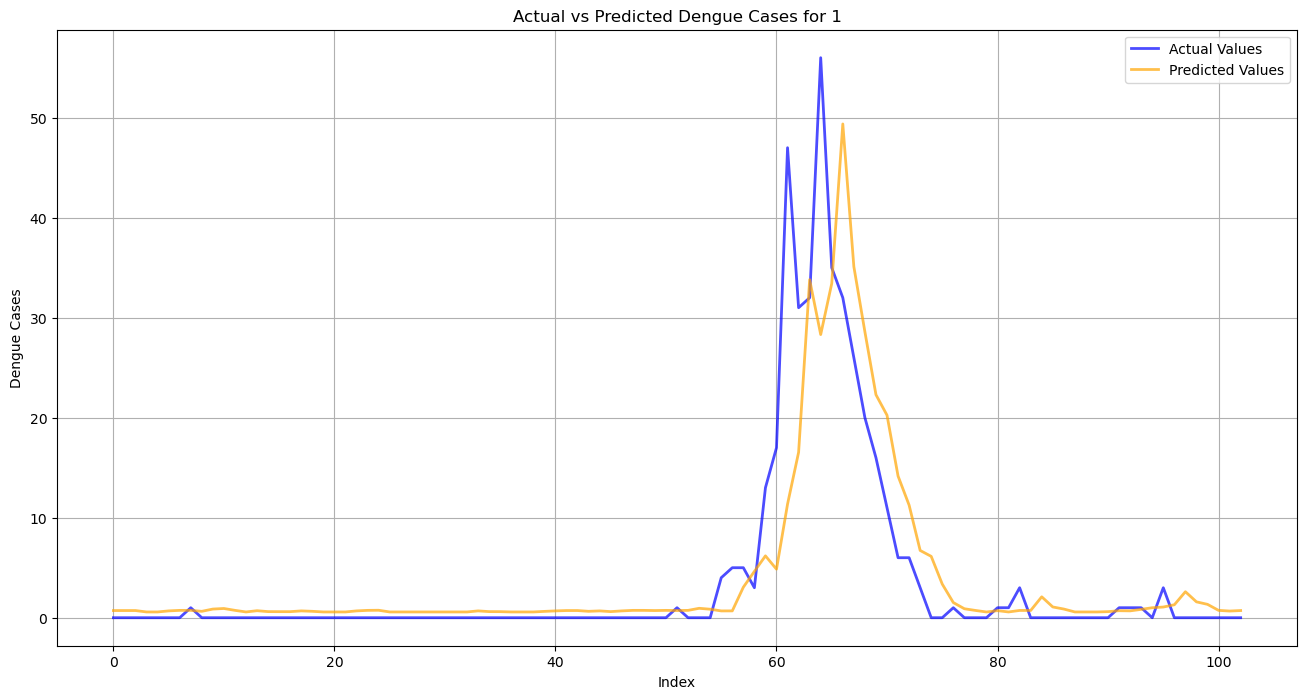

City: 2, RMSE: 0.9280279346195369


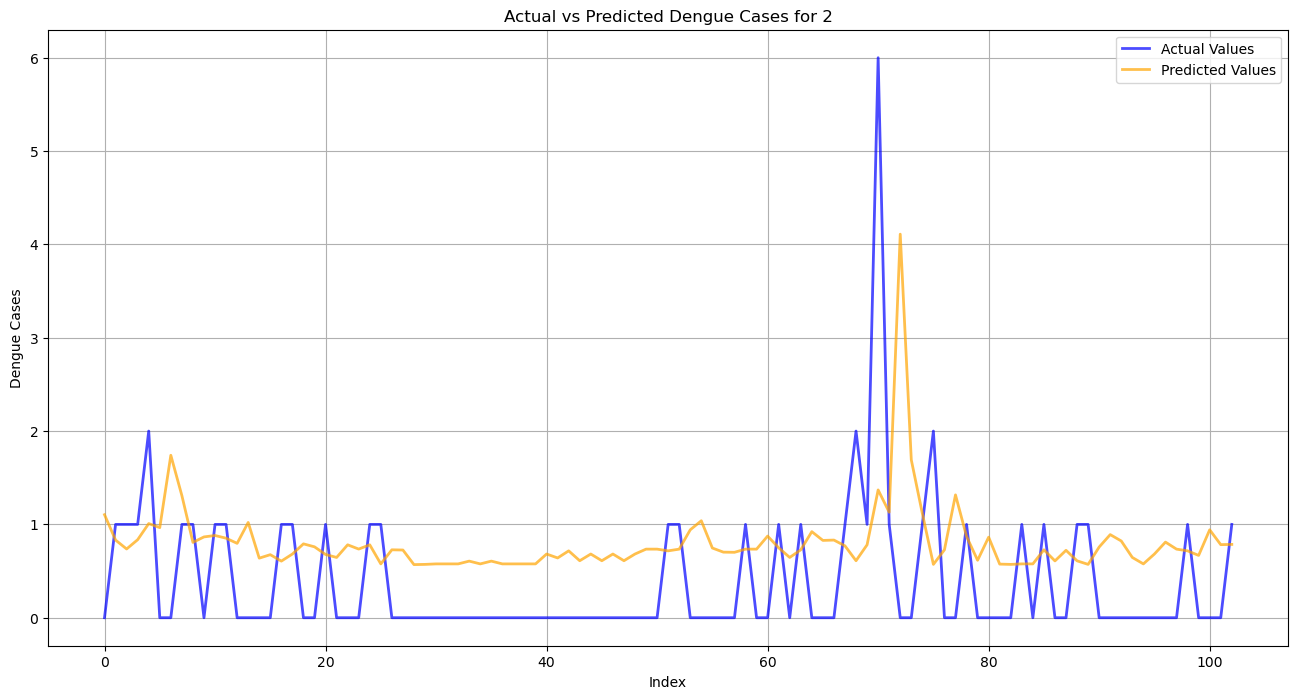

City: 3, RMSE: 0.6493917148318924


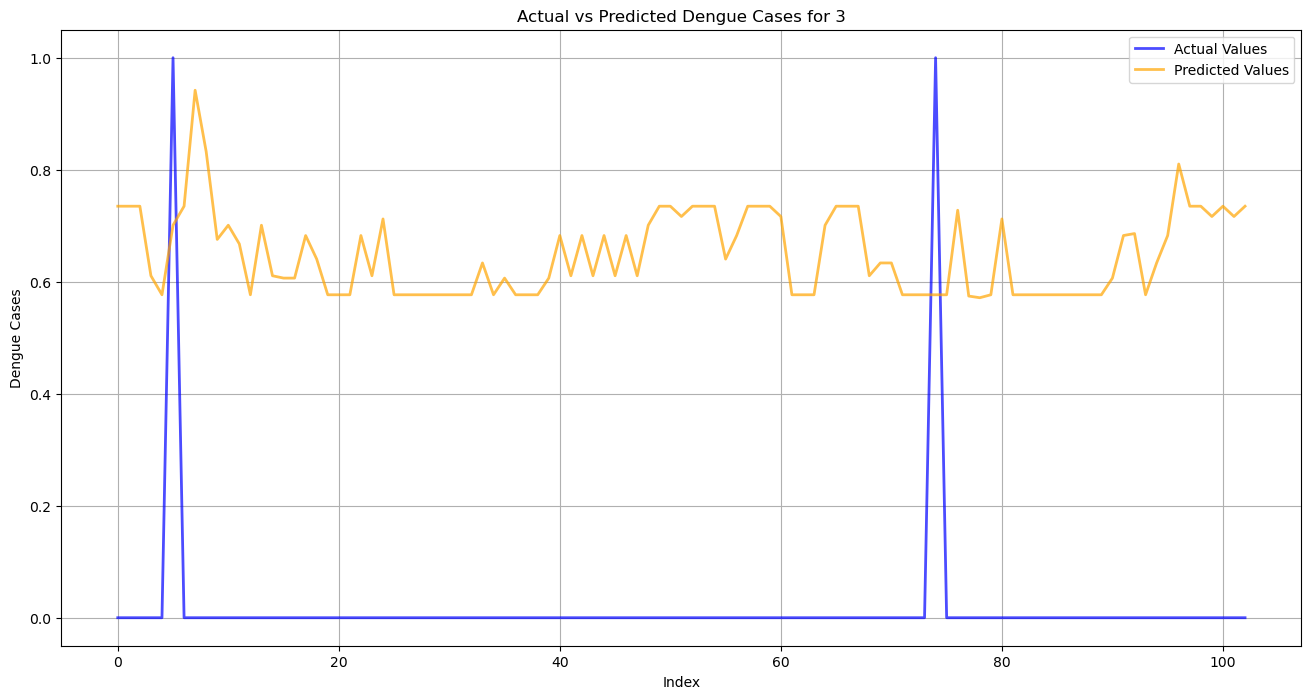

City: 4, RMSE: 1.553563065221273


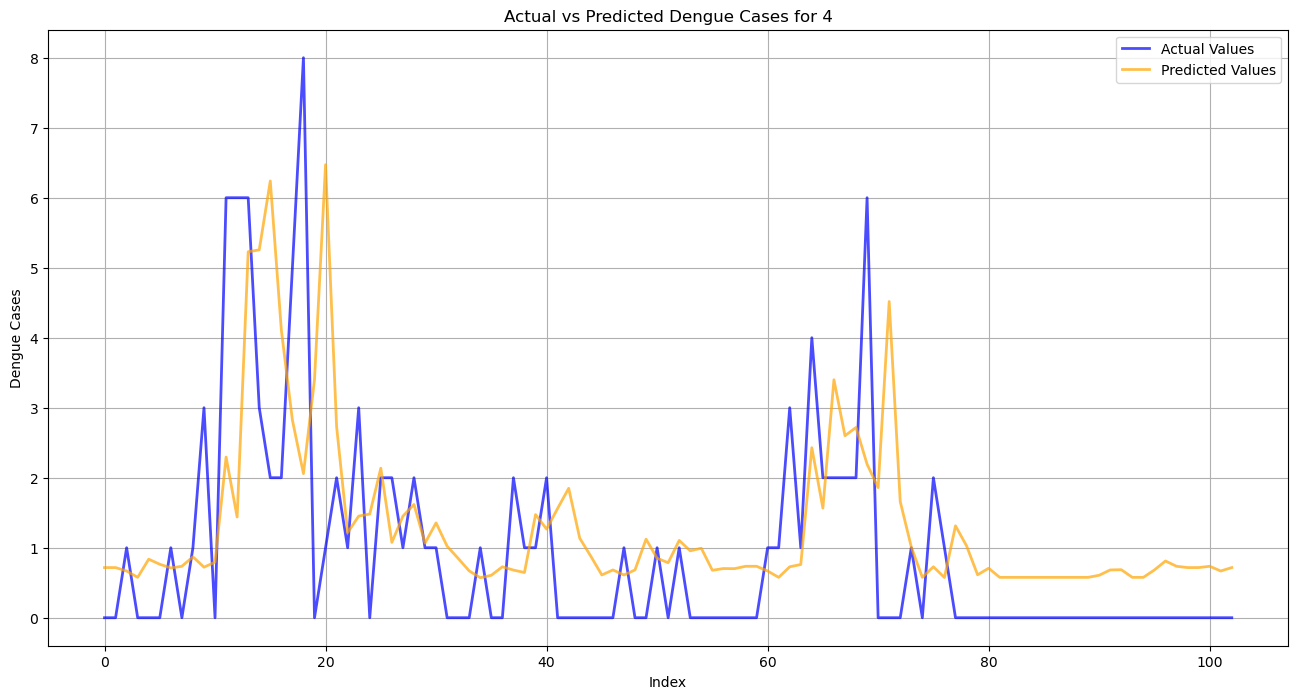

City: 5, RMSE: 0.9511369352147162


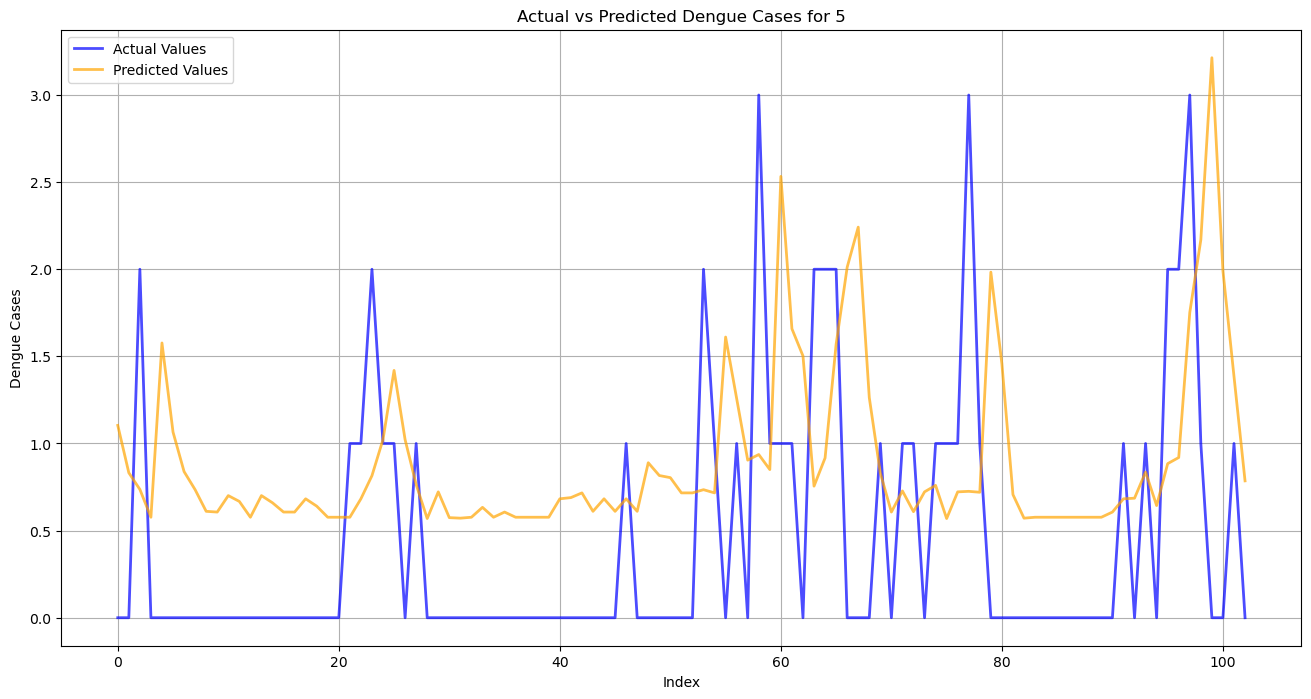

City: 6, RMSE: 5.5293545120196095


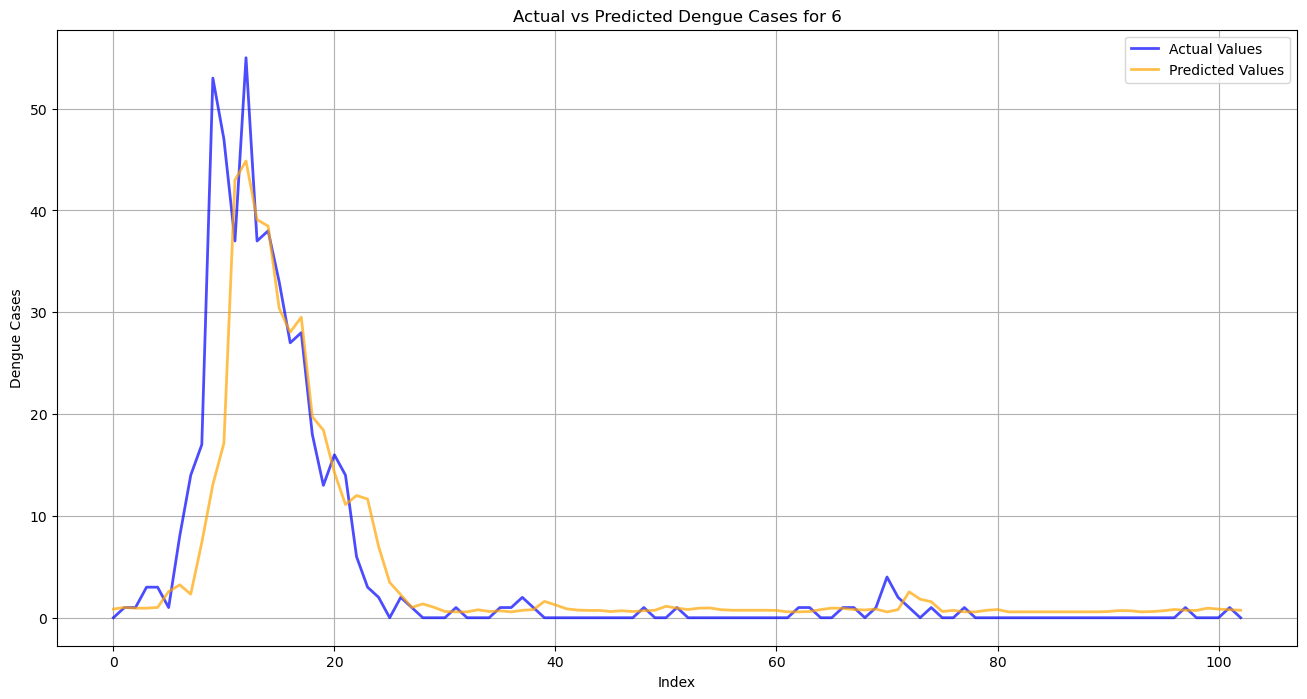

City: 7, RMSE: 10.619747184030091


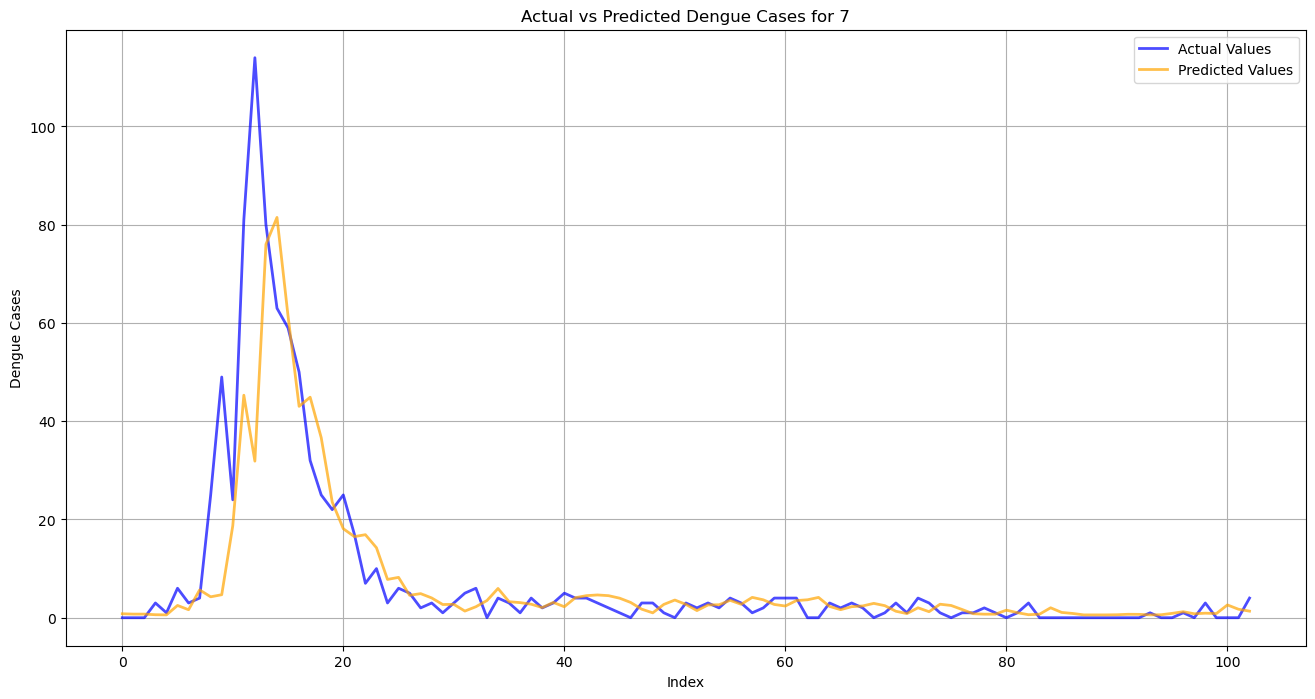

City: 8, RMSE: 7.385105478327688


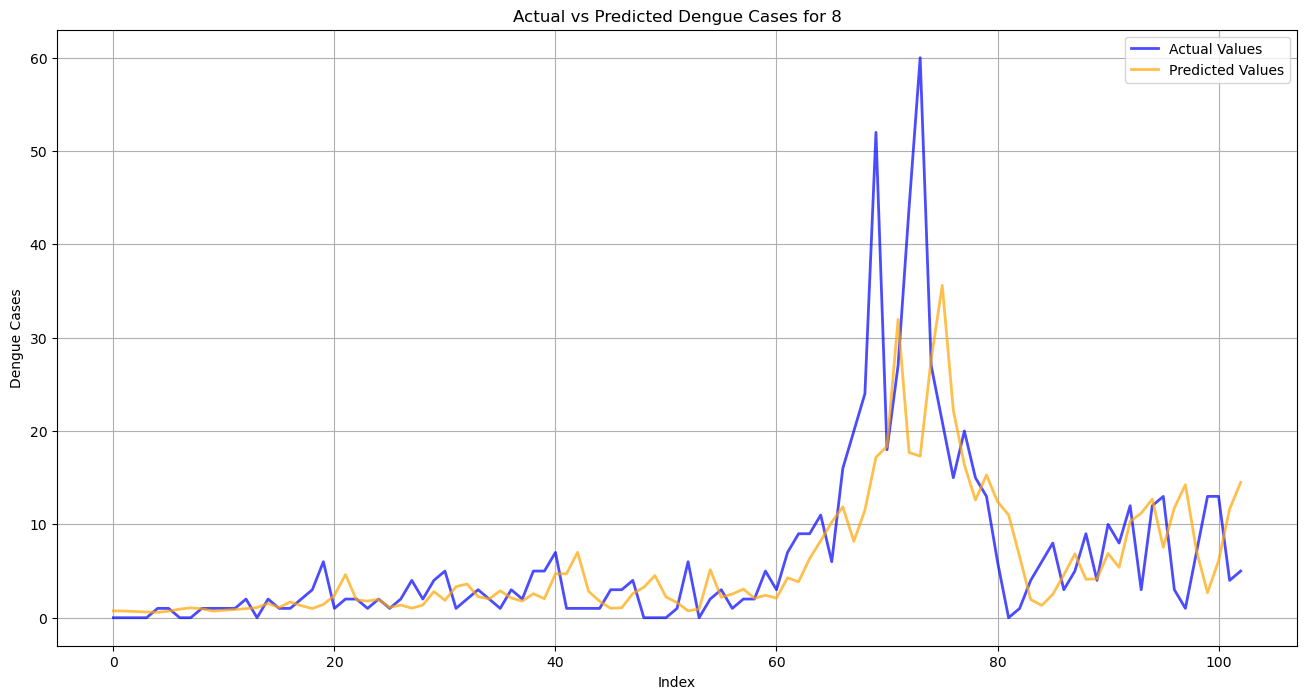

City: 9, RMSE: 0.6526017099179179


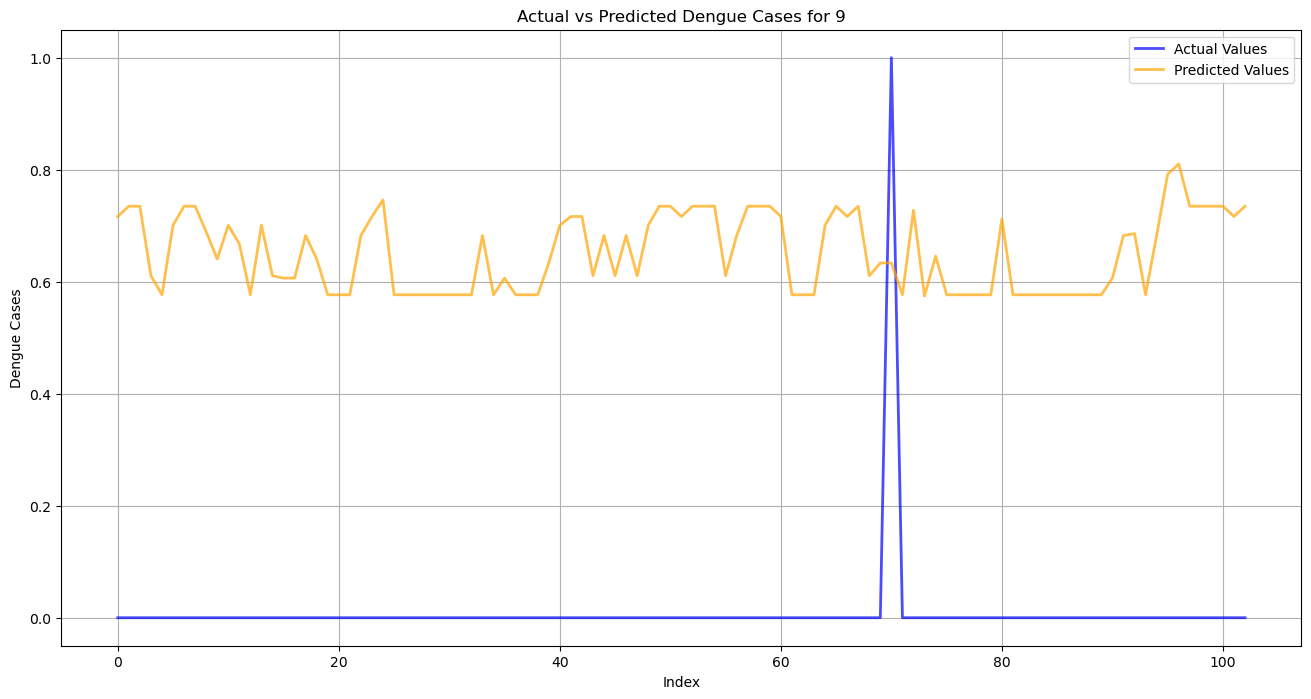

City: 10, RMSE: 1.0513473609014743


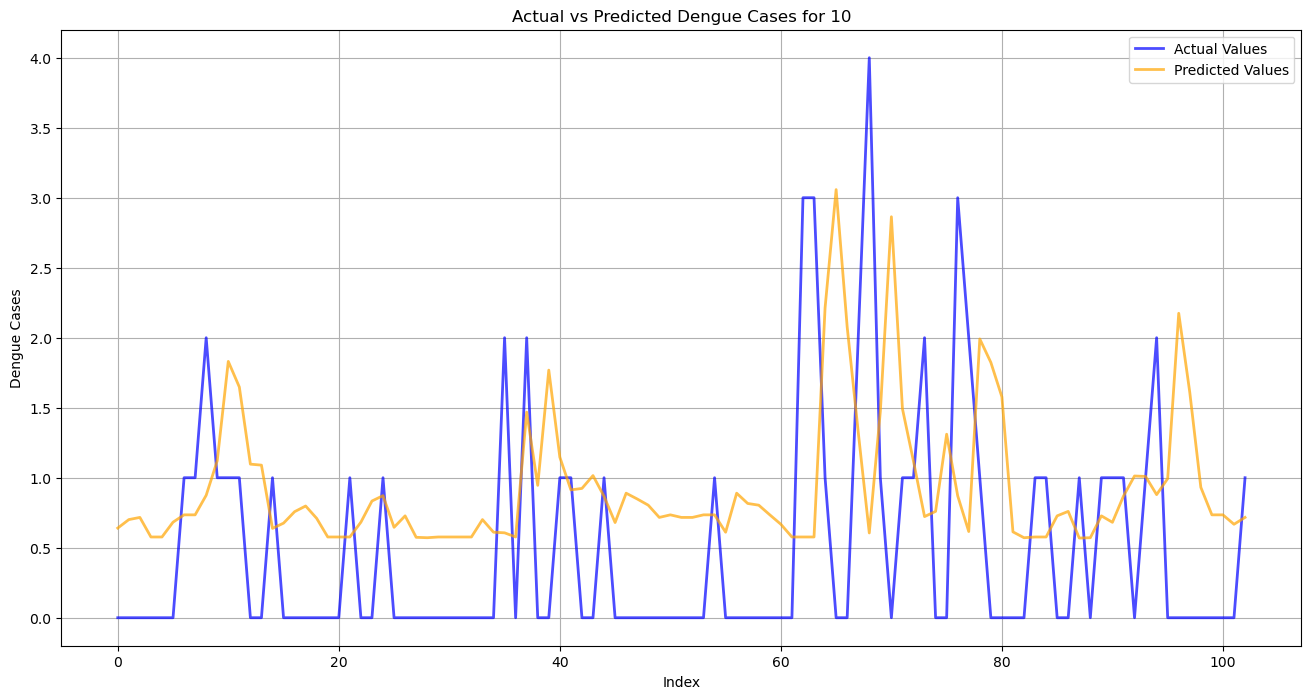

City: 11, RMSE: 2.1208214902524447


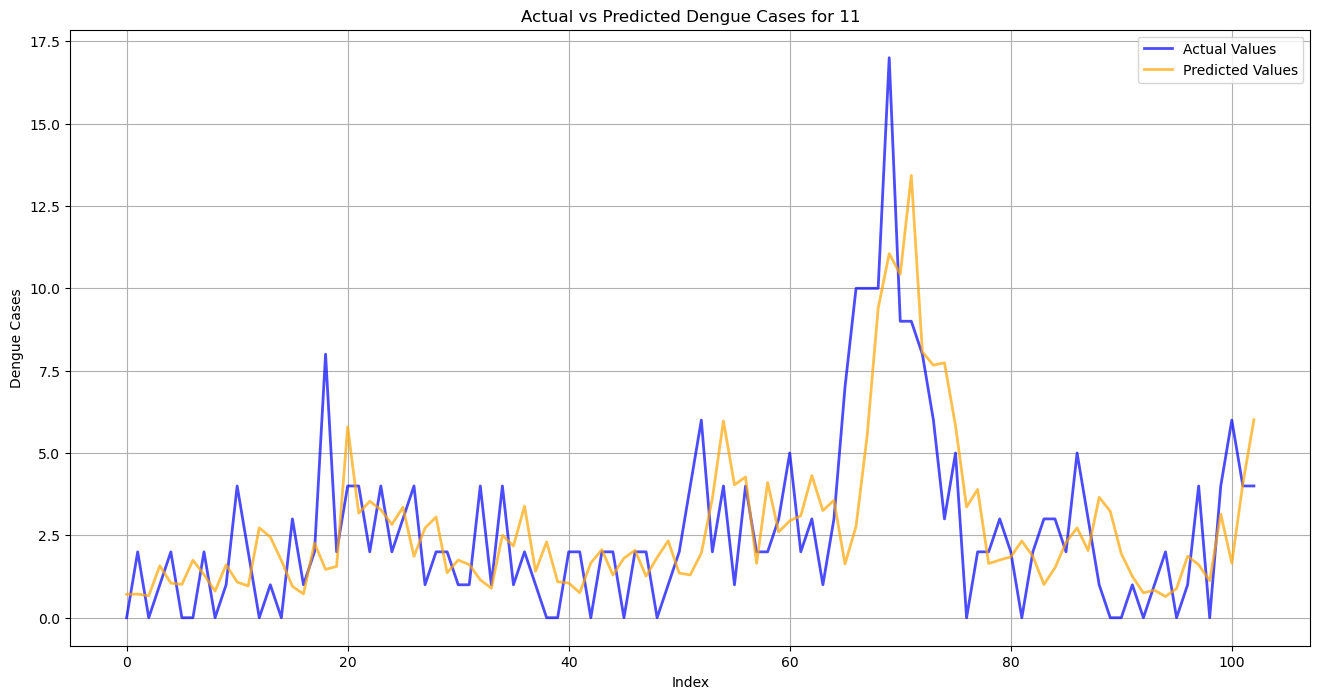

City: 12, RMSE: 0.8576281820648068


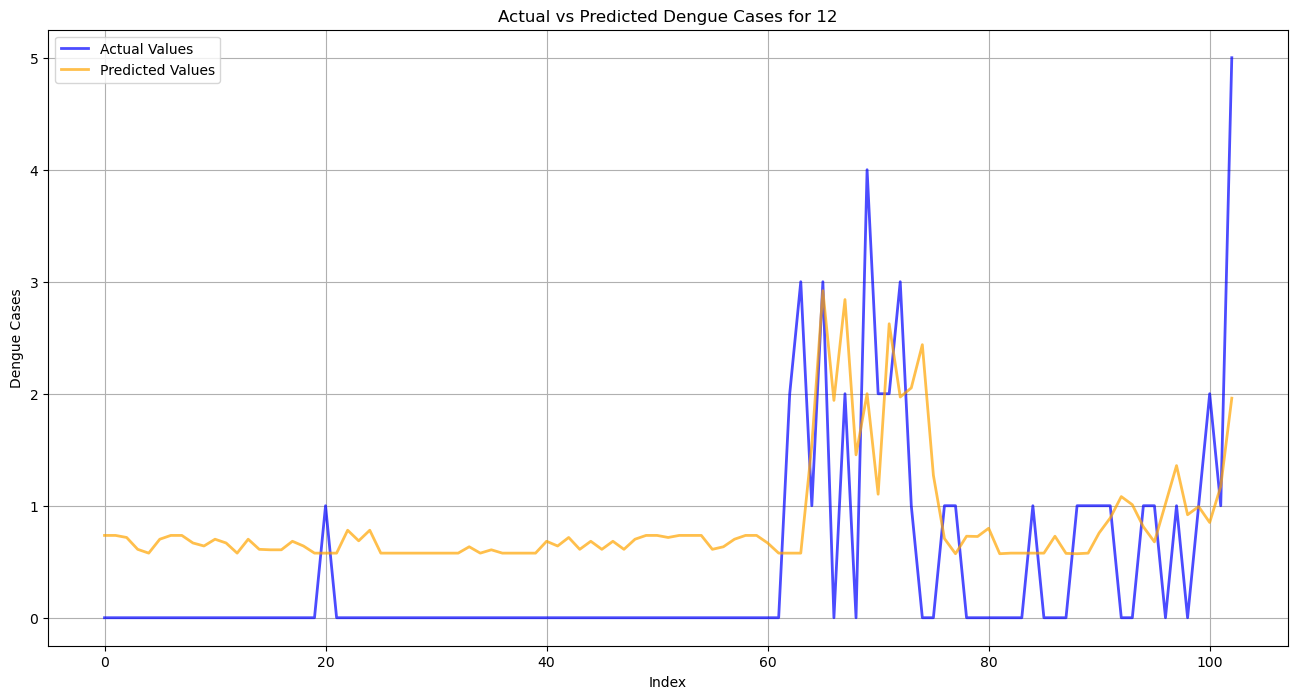

City: 13, RMSE: 2.912818488716001


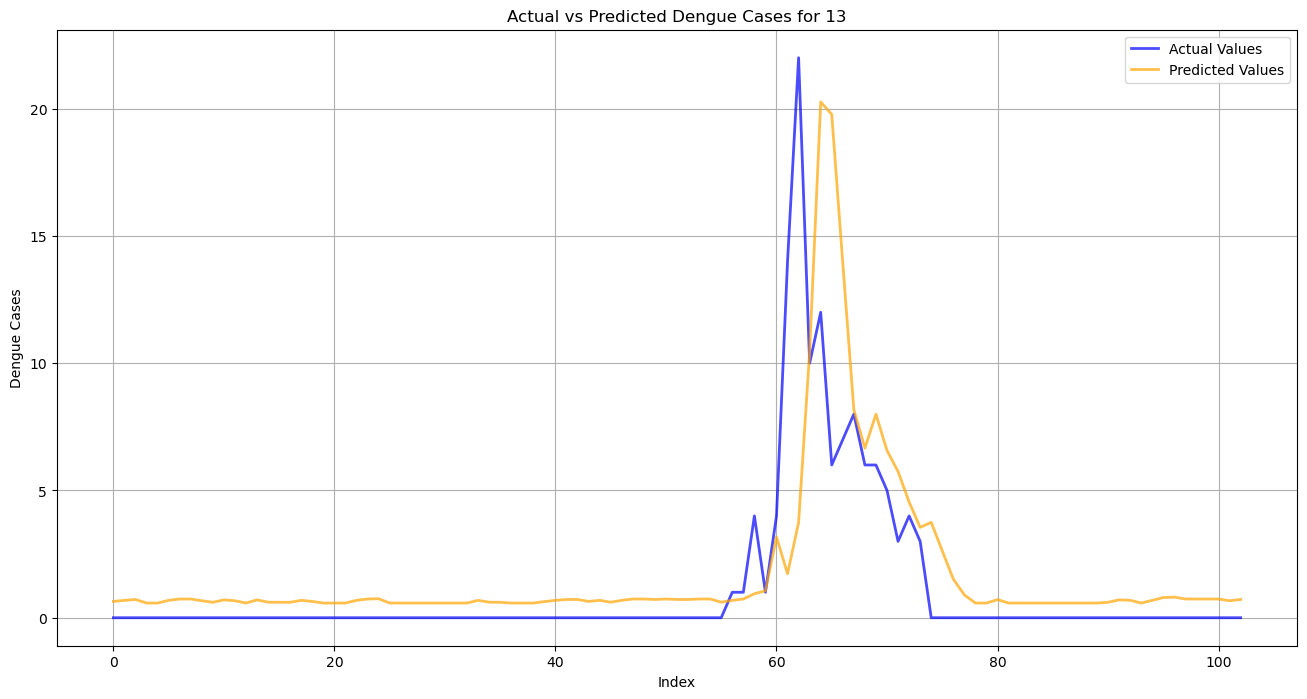

City: 16, RMSE: 2.063489492170075


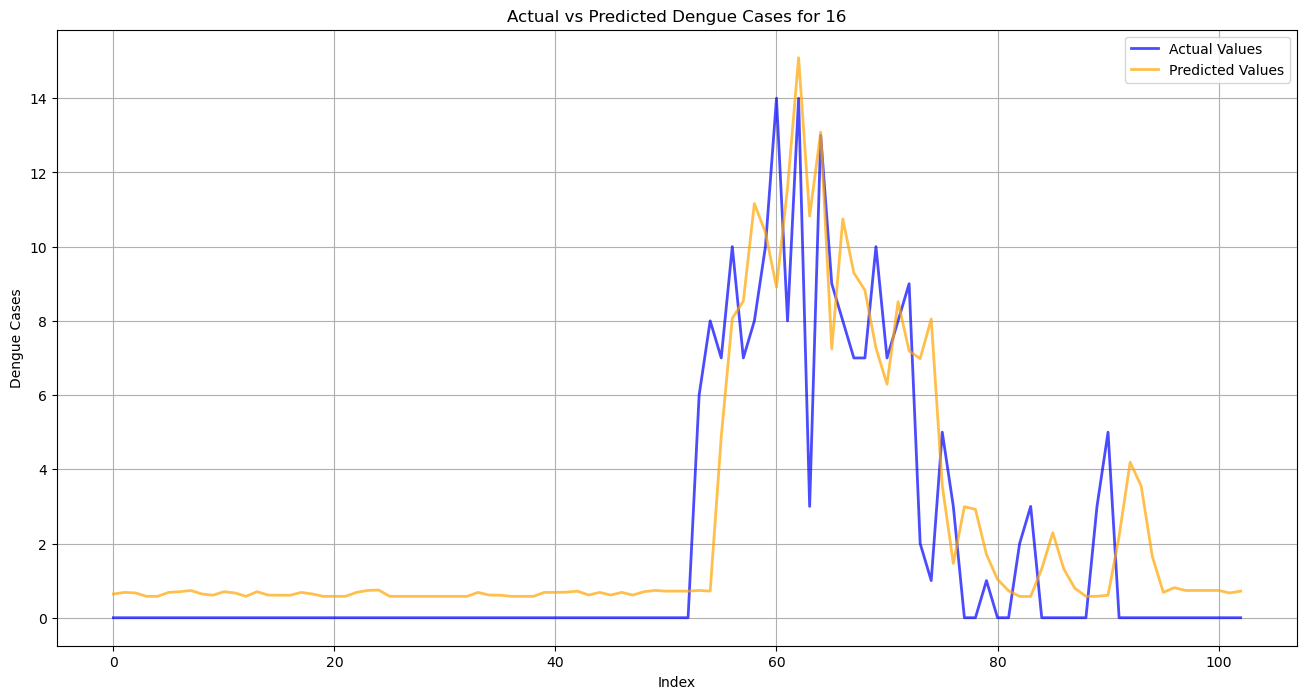

City: 20, RMSE: 0.6487307040382477


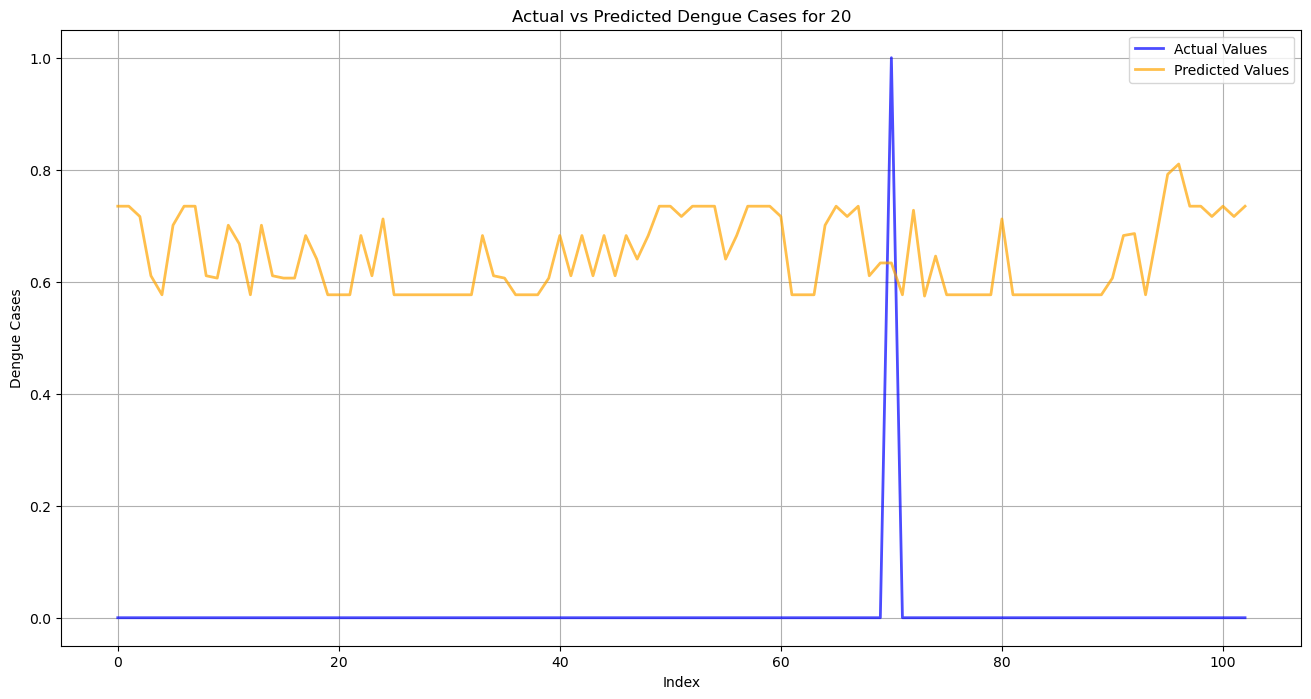

City: 14, RMSE: 9.618686555581897


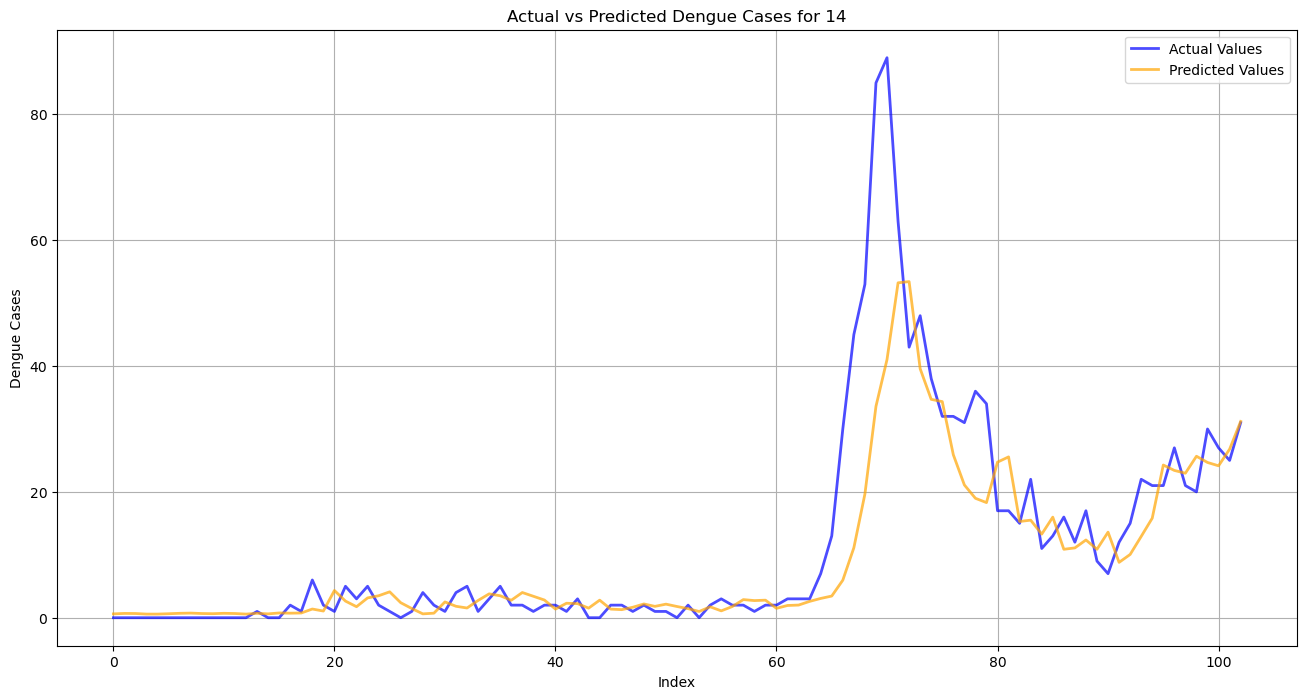

City: 15, RMSE: 1.0017562075188349


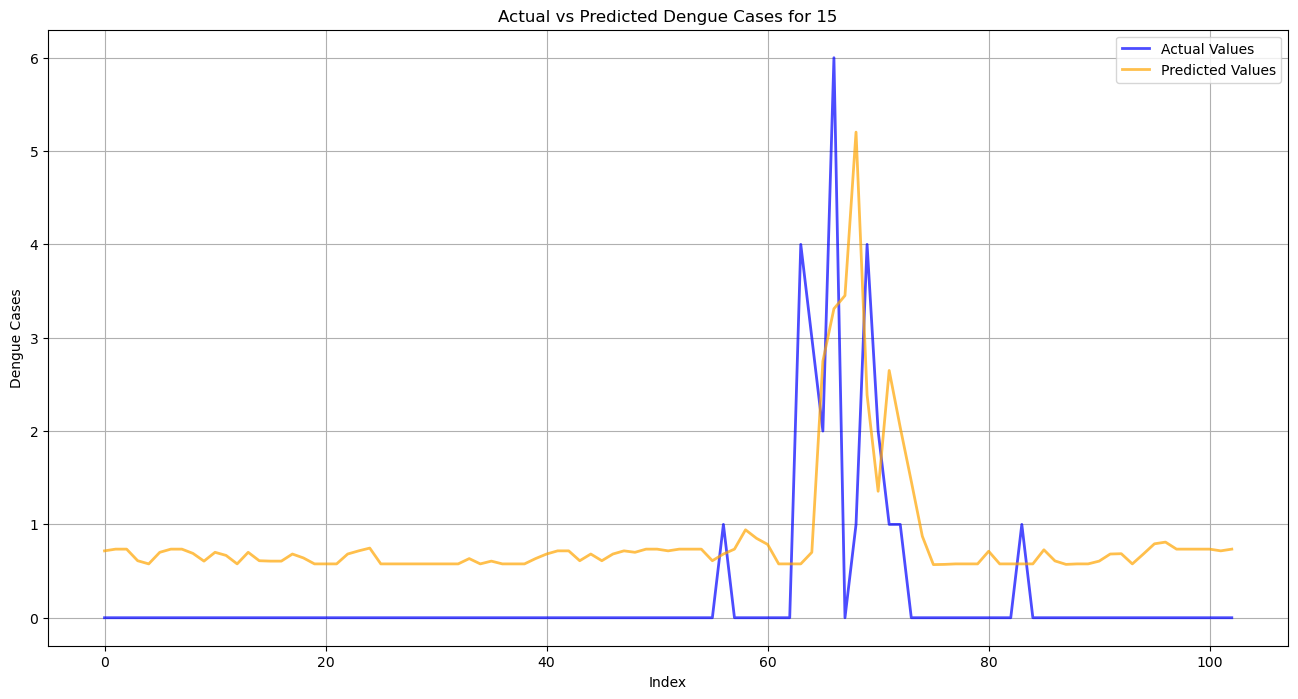

City: 17, RMSE: 1.7981132110587175


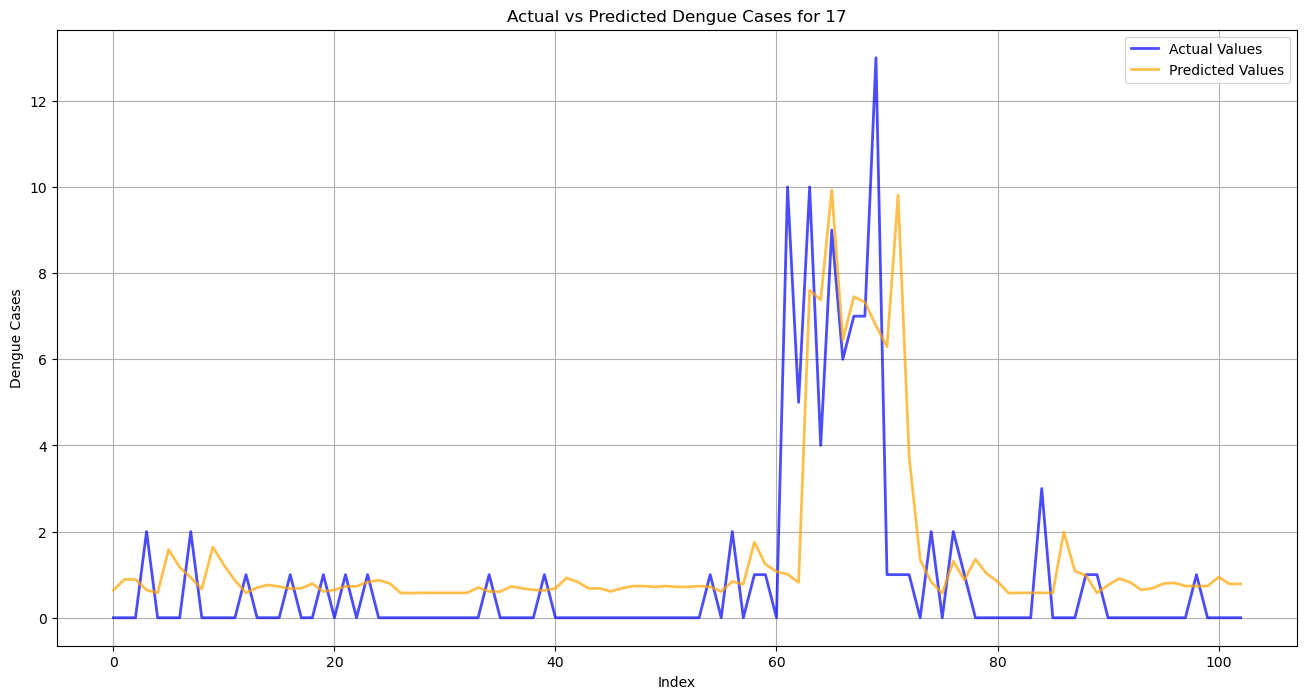

City: 18, RMSE: 4.176858624691433


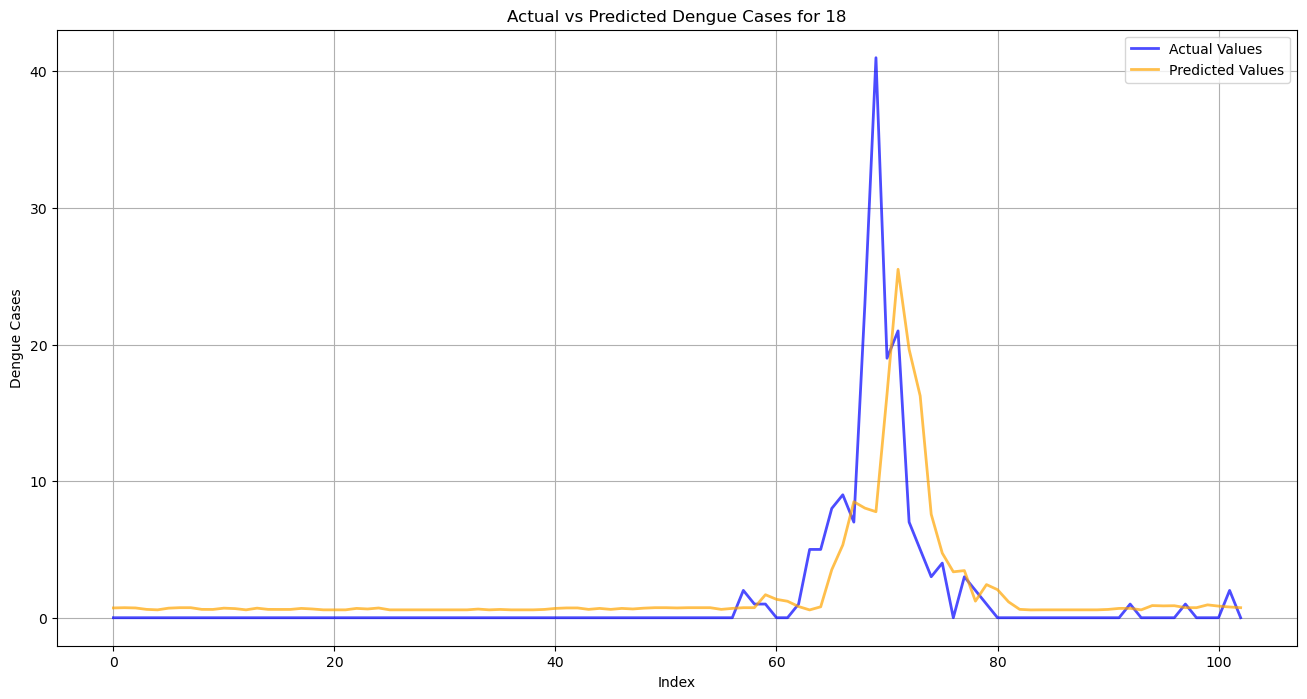

City: 19, RMSE: 3.026953764792017


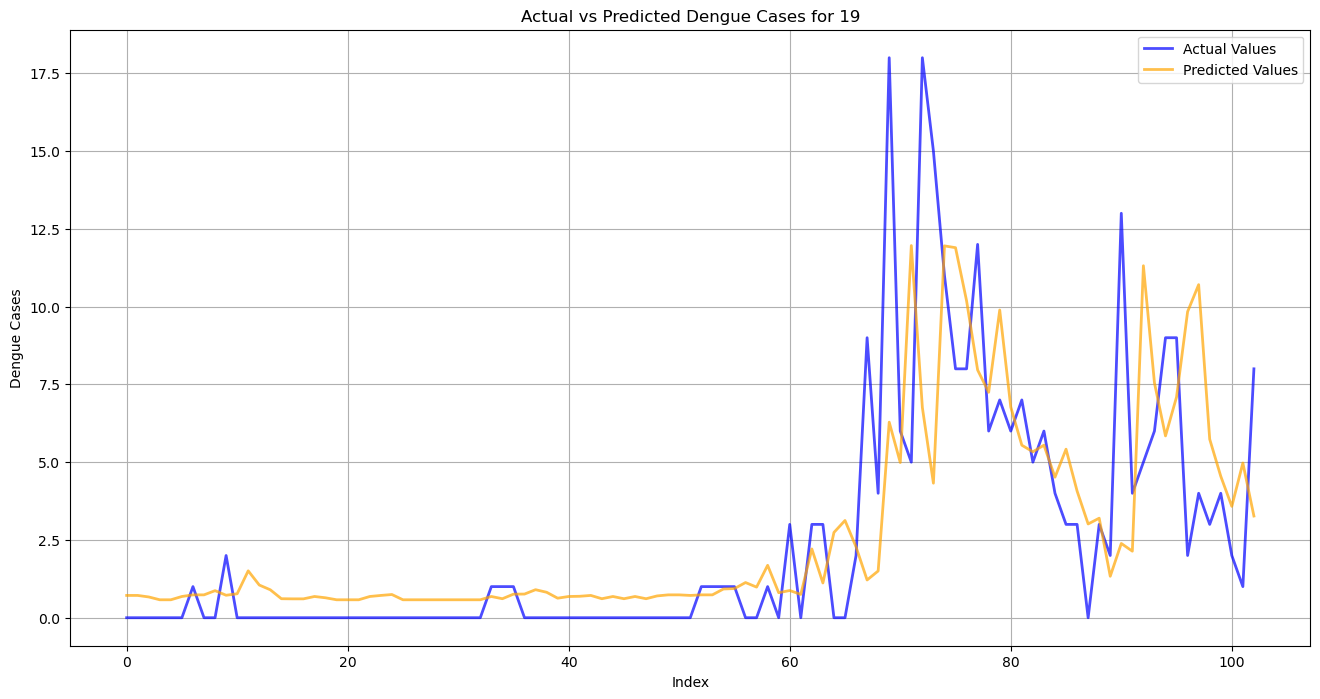

City: 21, RMSE: 0.7503828557590704


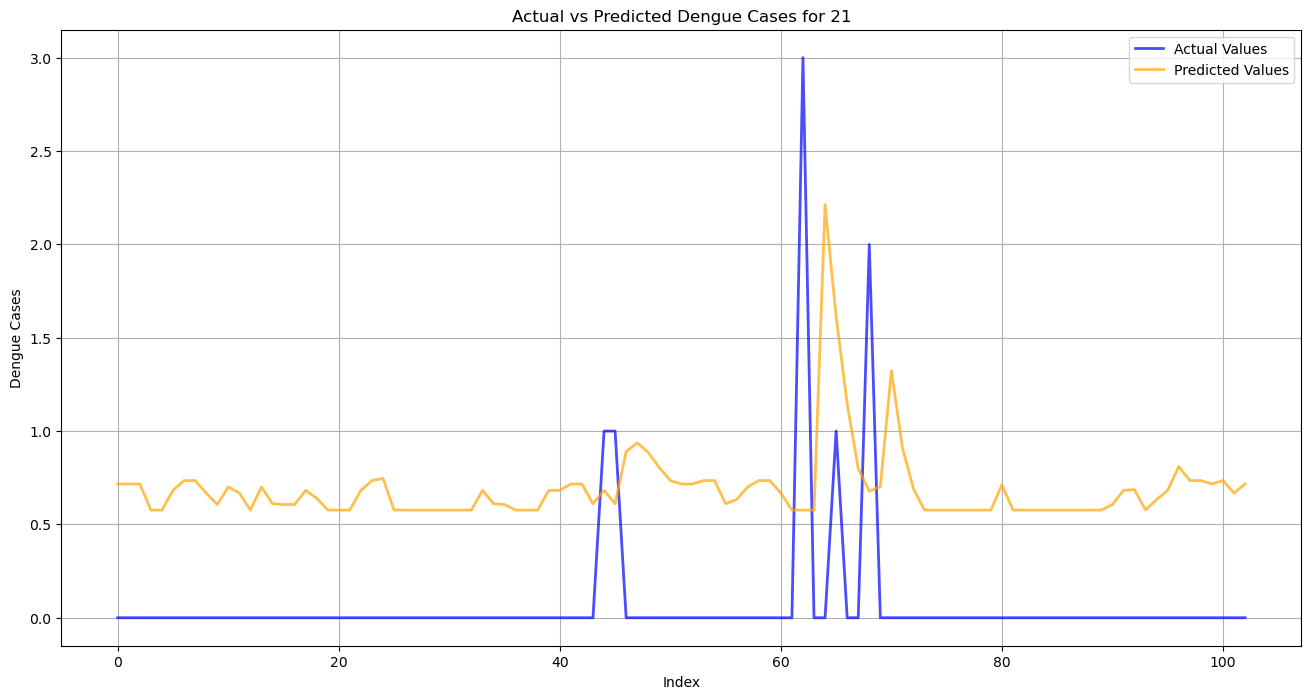

City: 22, RMSE: 2.188080122125042


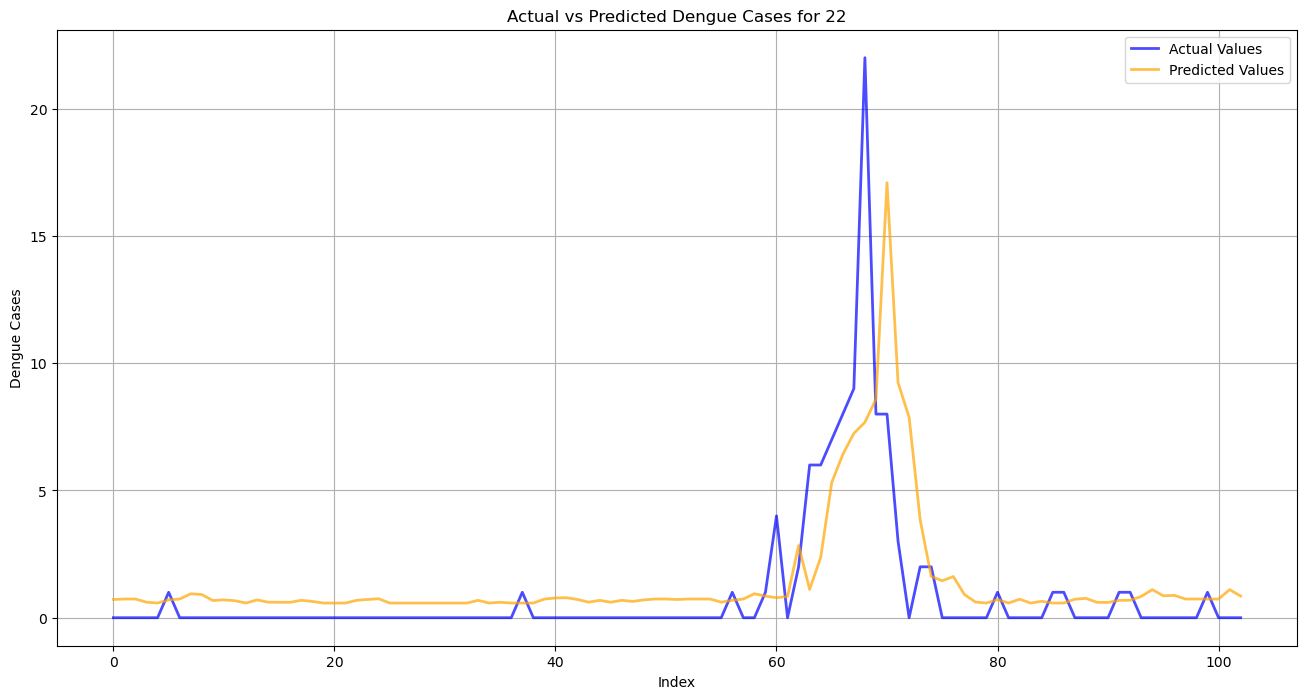

City: 23, RMSE: 0.6514170489234065


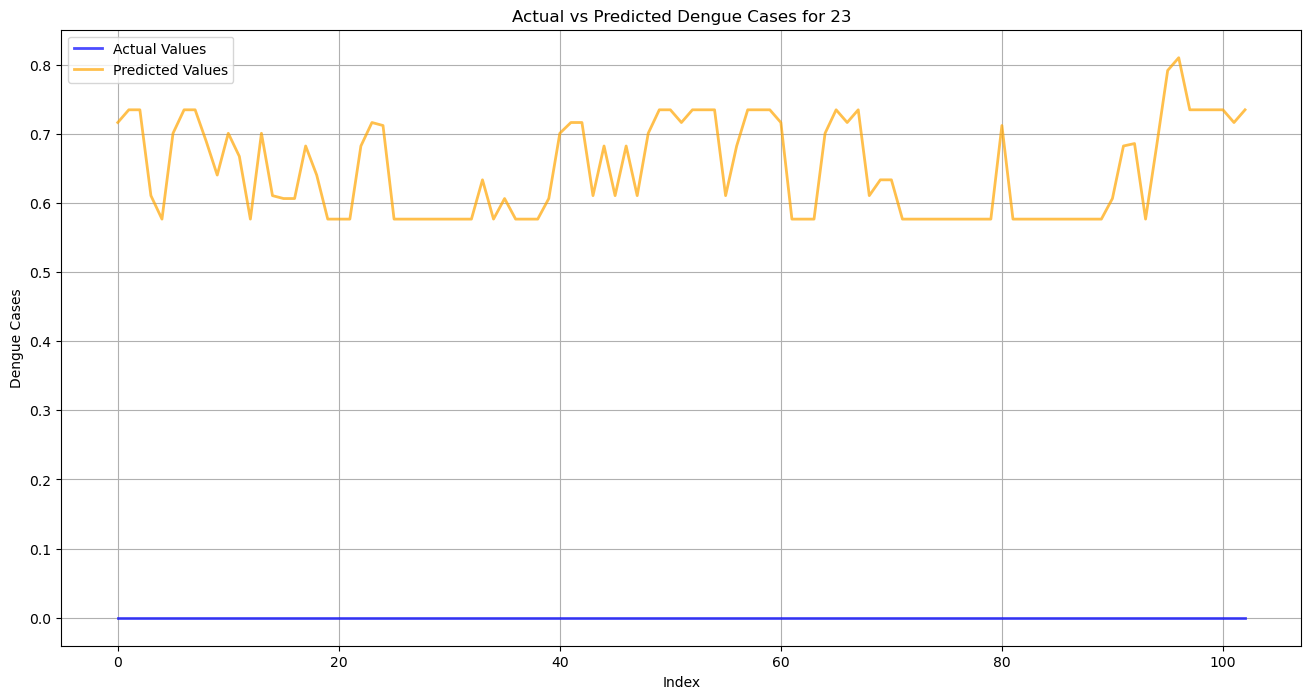

City: 24, RMSE: 5.173146390012644


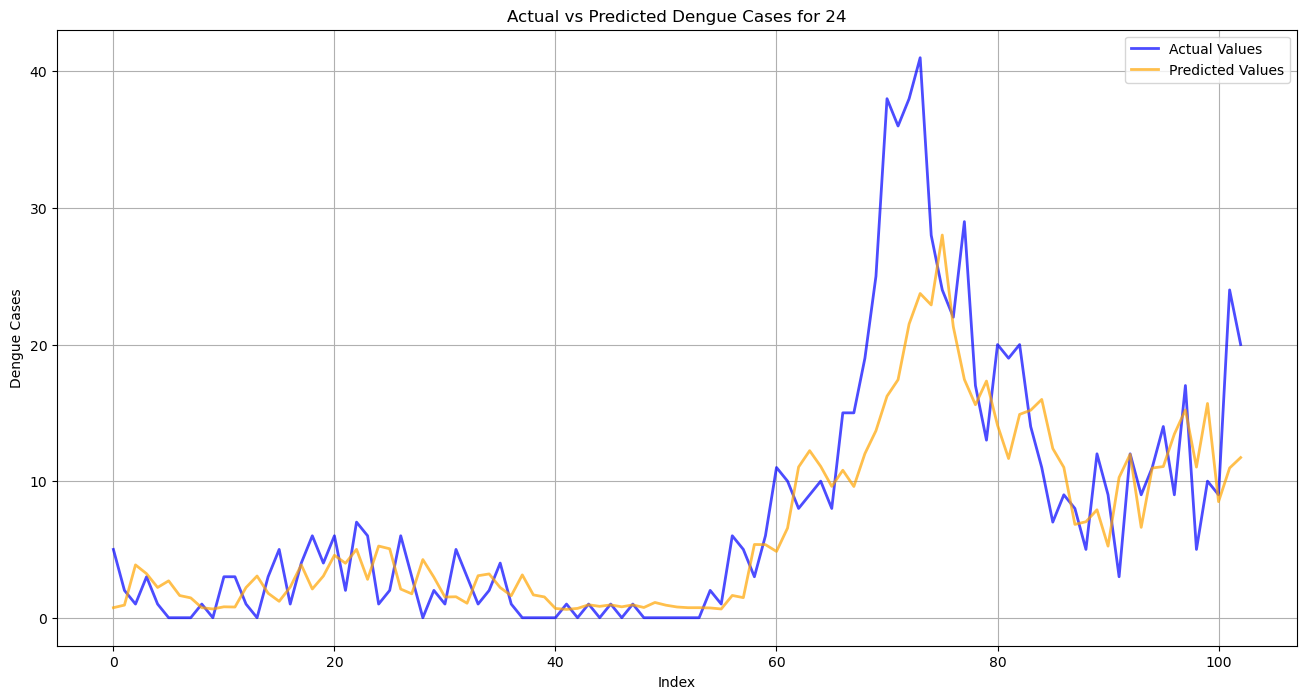

City: 25, RMSE: 0.6554101709978116


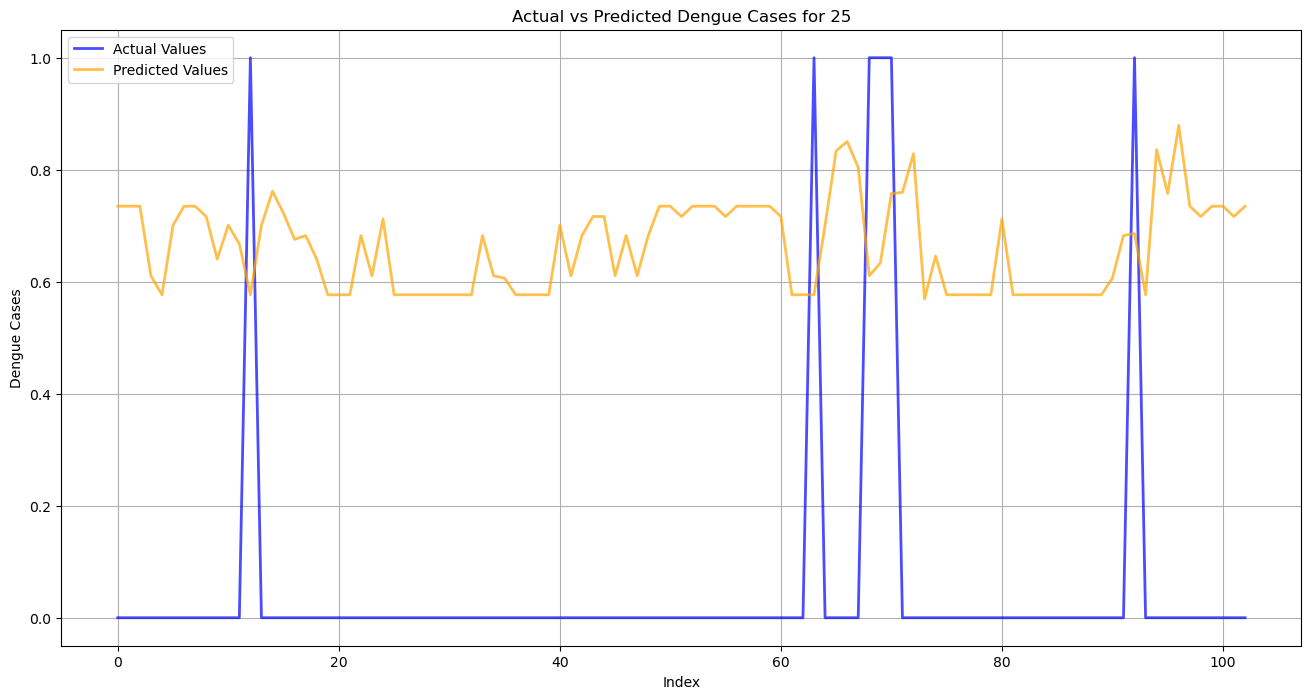

City: 26, RMSE: 0.7029102961392537


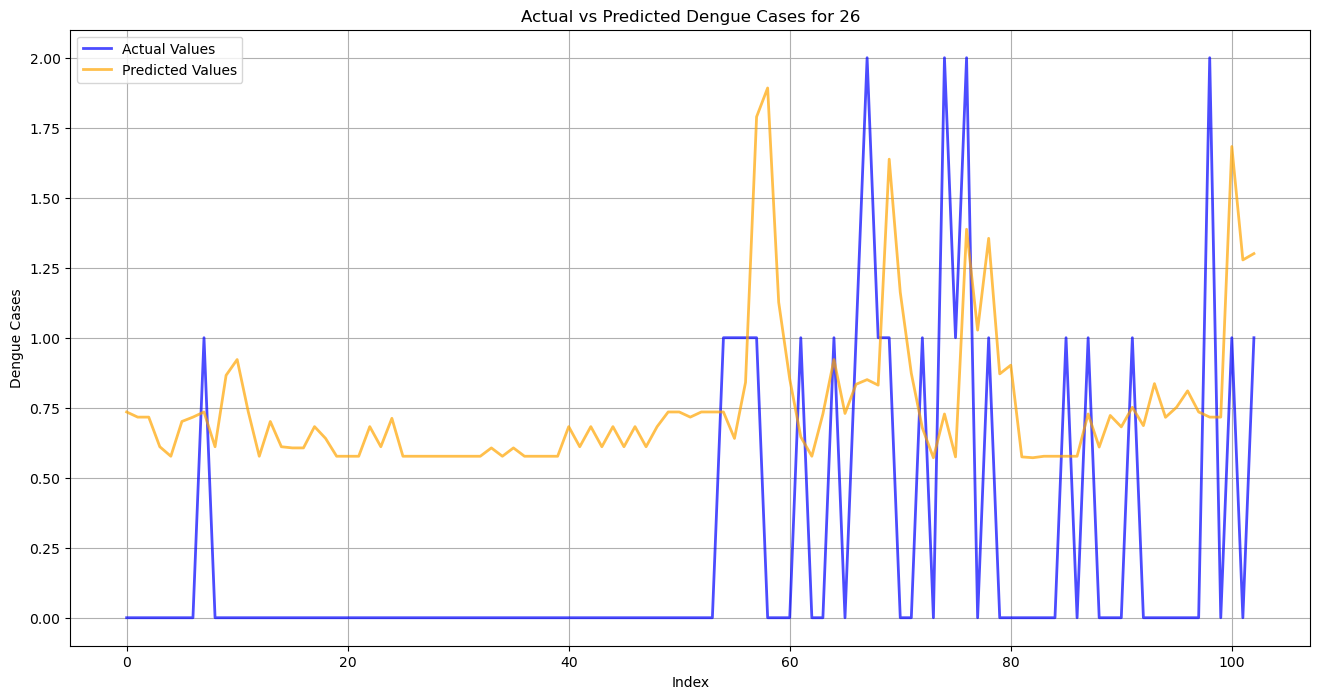

City: 27, RMSE: 4.481482902477904


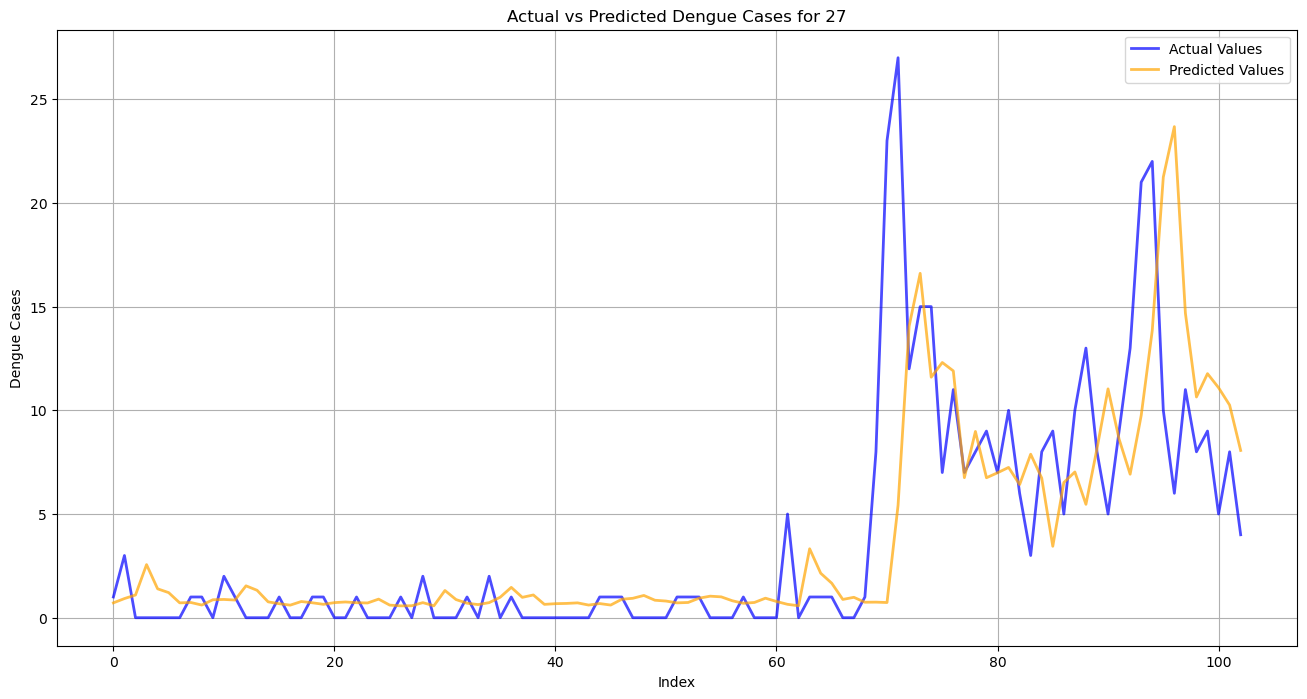

City: 28, RMSE: 2.2378332003328696


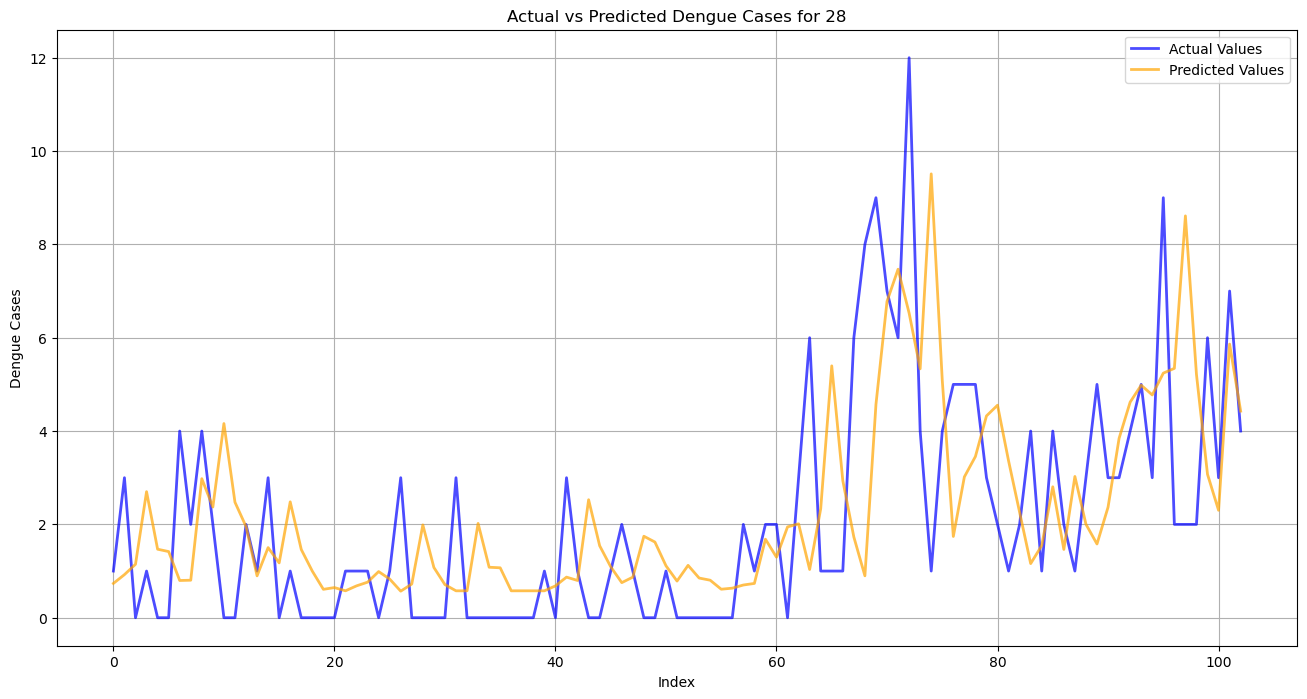

City: 29, RMSE: 6.050294855372416


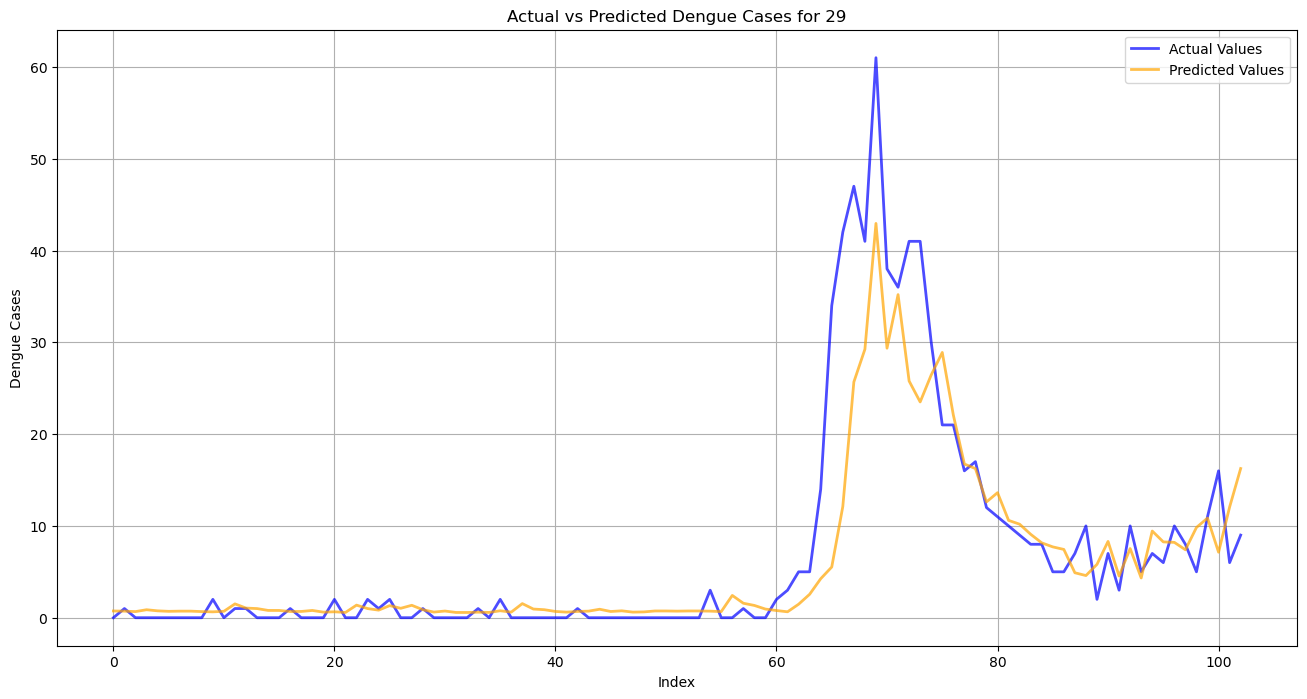

City: 30, RMSE: 2.0751737494098172


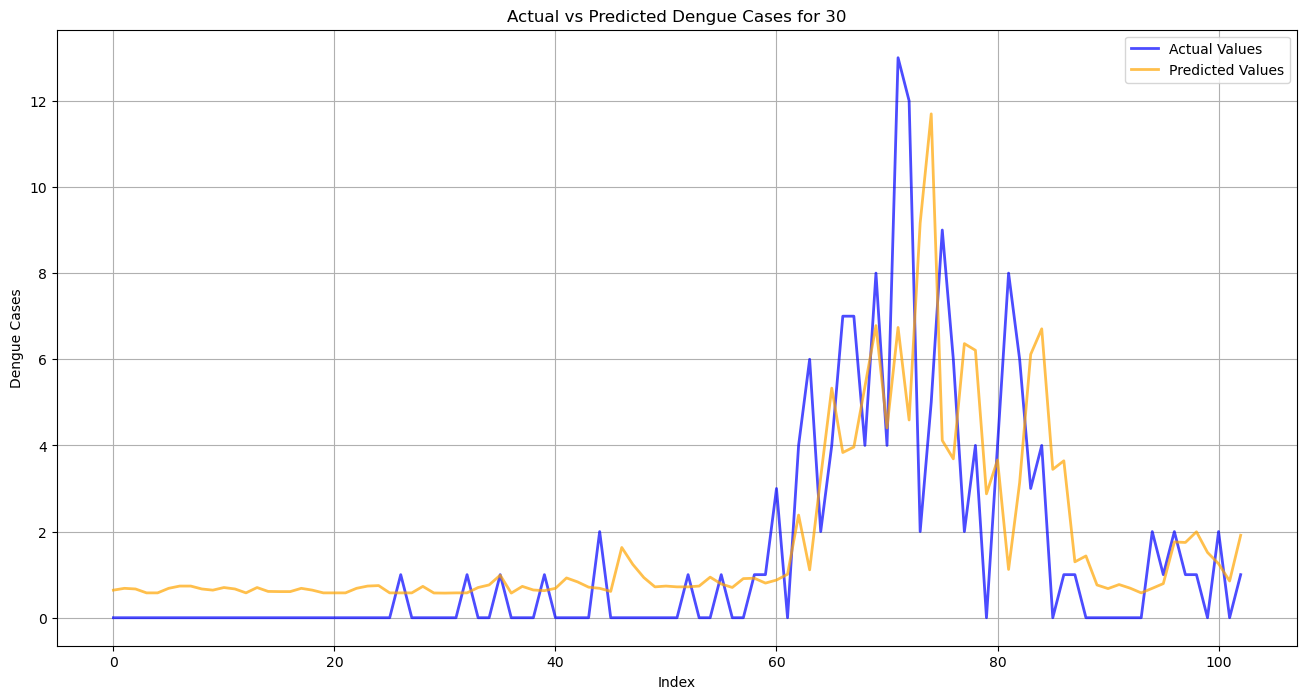

City: 31, RMSE: 4.673822518165746


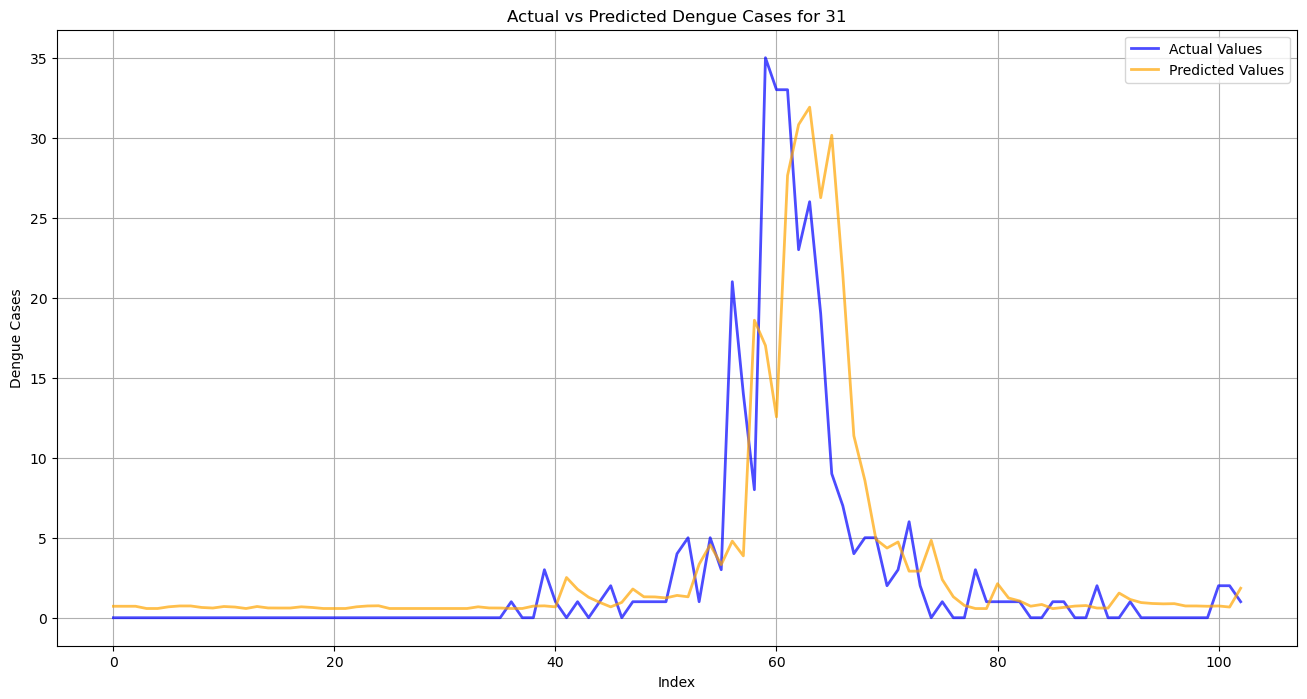

City: 32, RMSE: 9.404190310774972


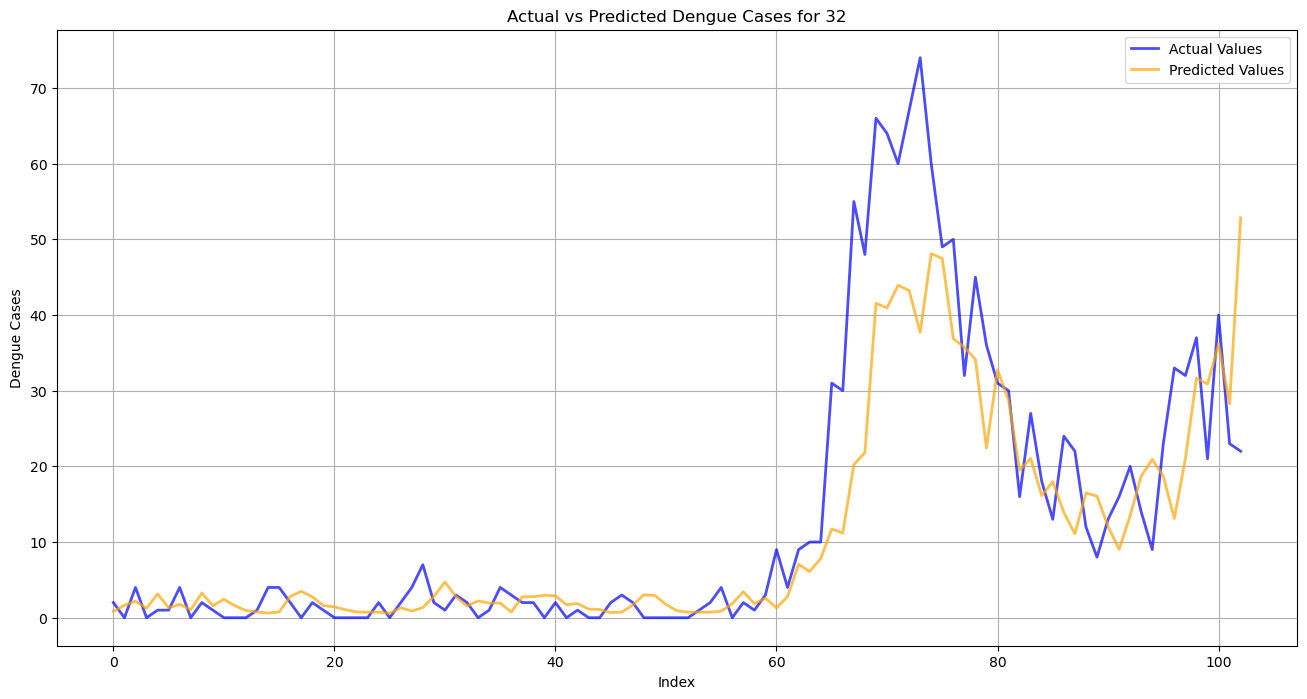

City: 33, RMSE: 1.0583078253322666


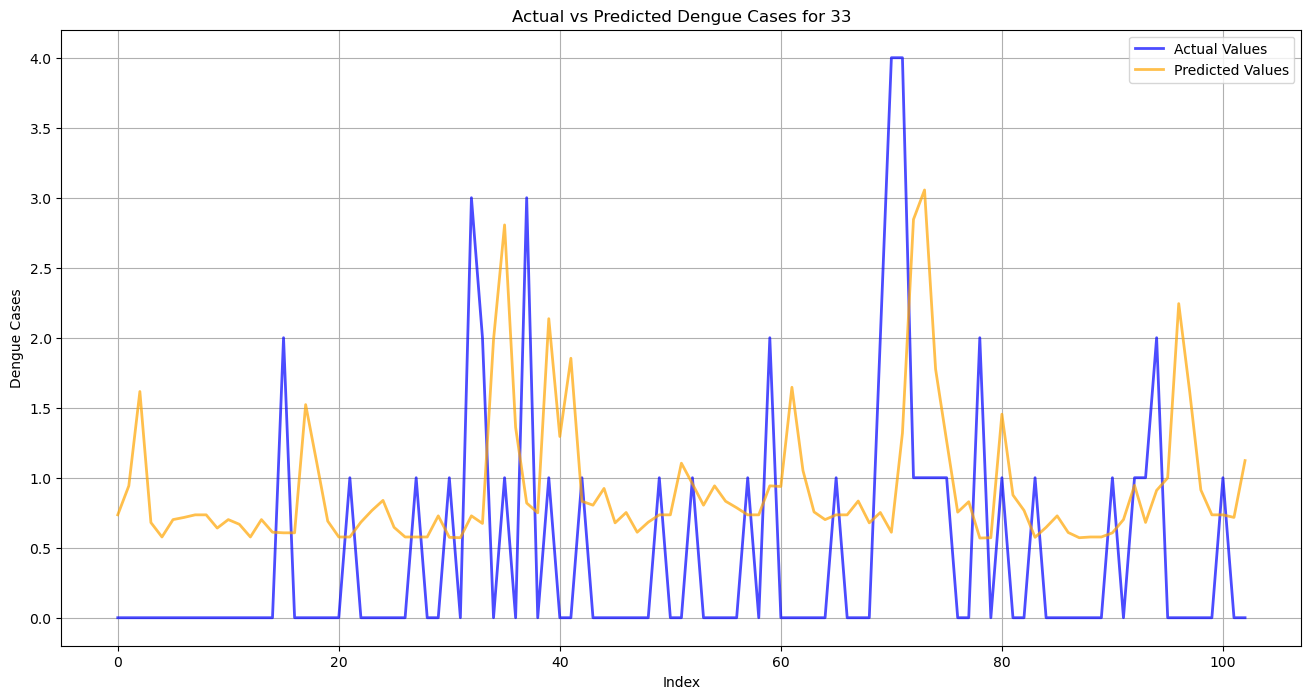

City: 34, RMSE: 2.397485883982079


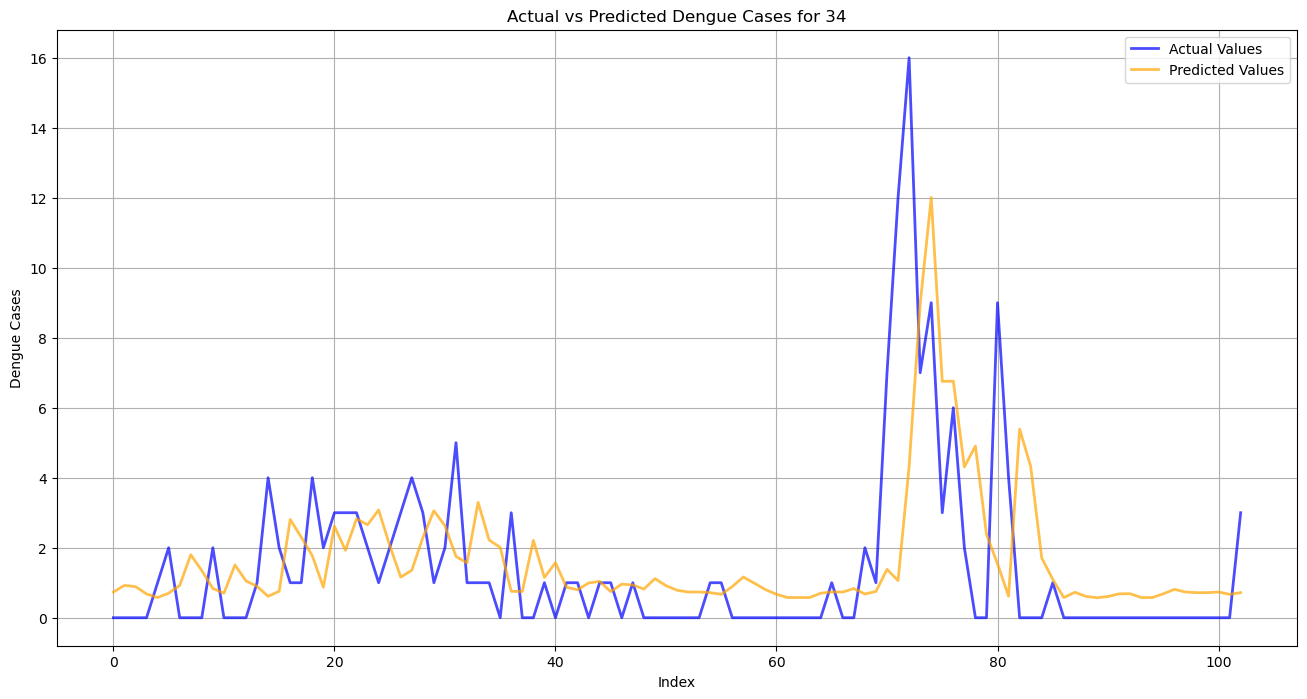

City: 35, RMSE: 0.9573711811974145


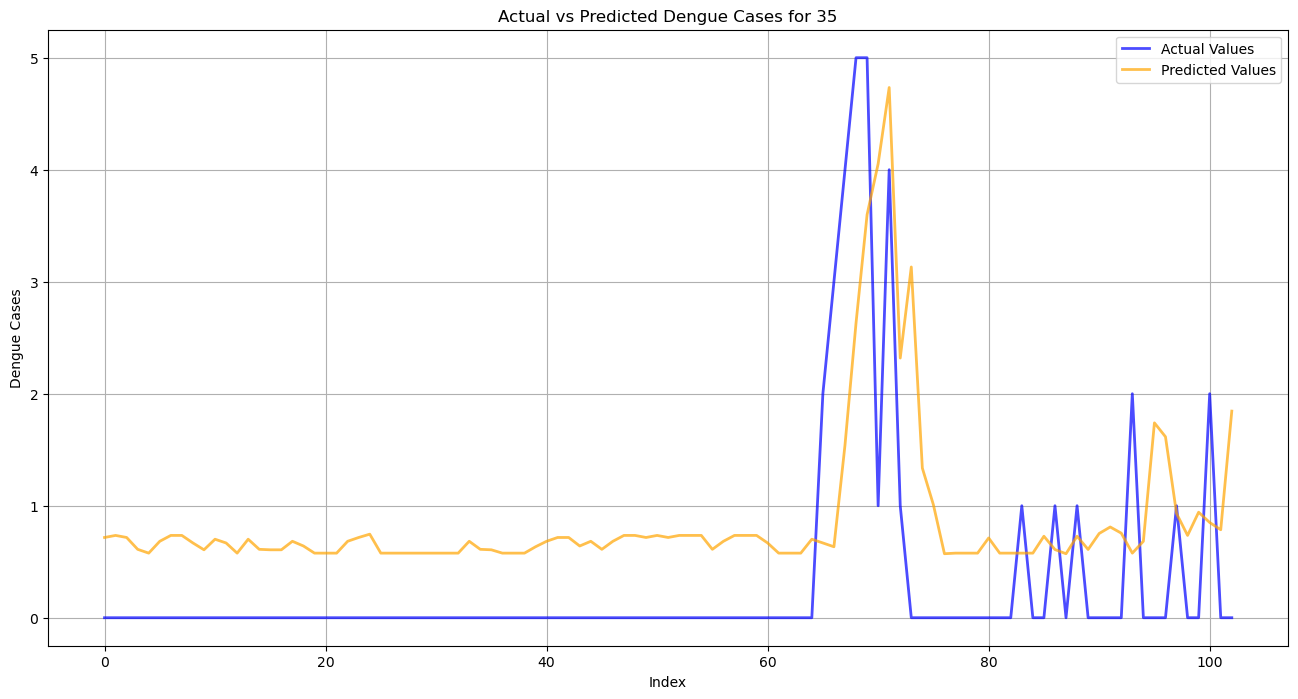

City: 36, RMSE: 10.629216967538648


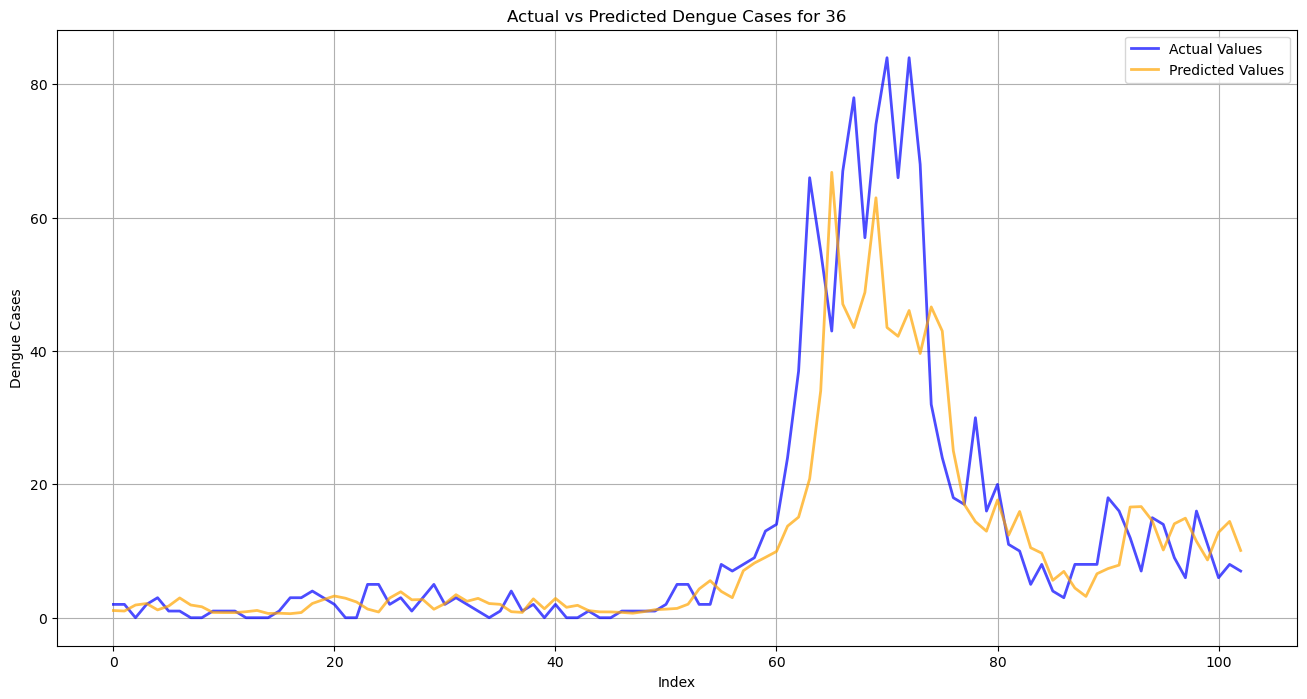

City: 37, RMSE: 0.7463584440526139


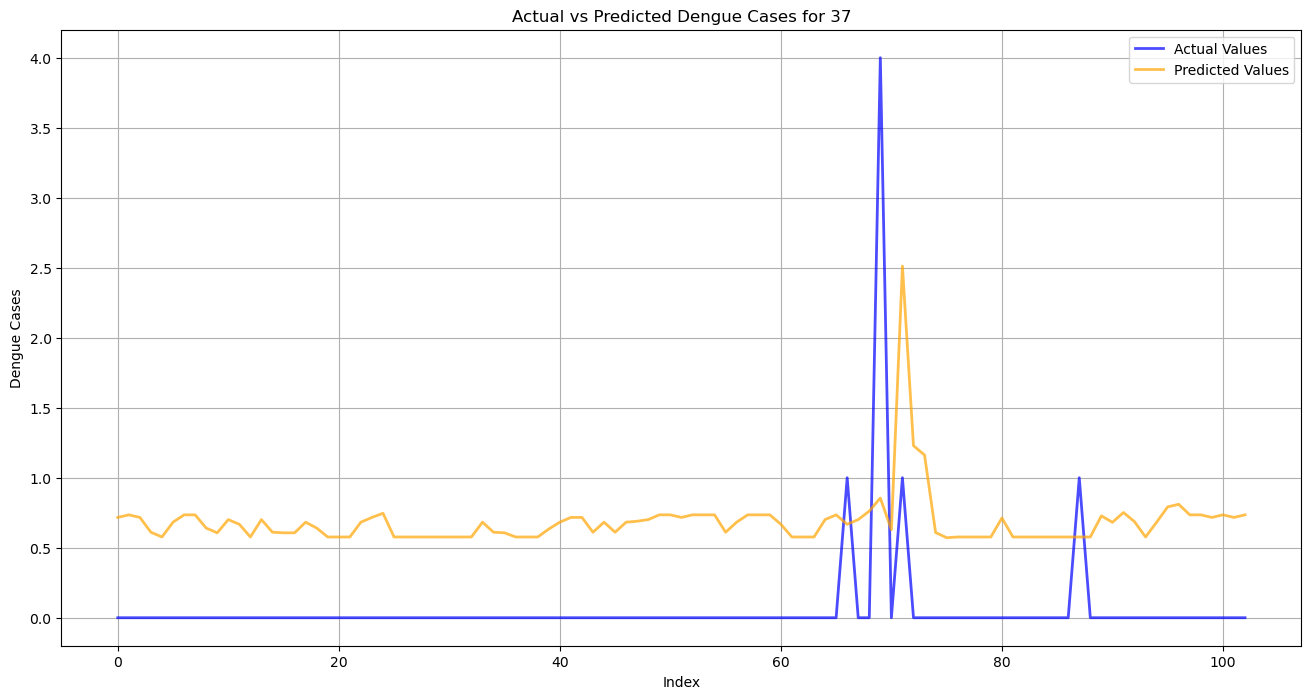

City: 38, RMSE: 1.7255523519338676


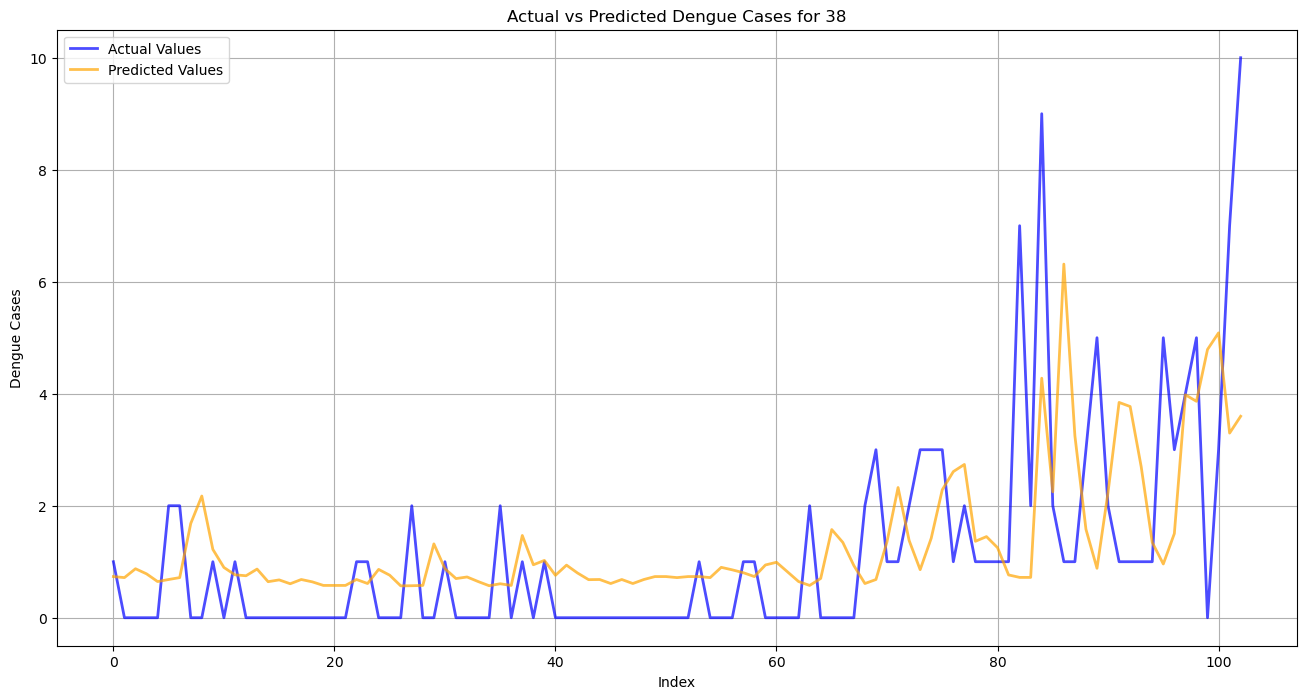

City: 39, RMSE: 0.9669535284236477


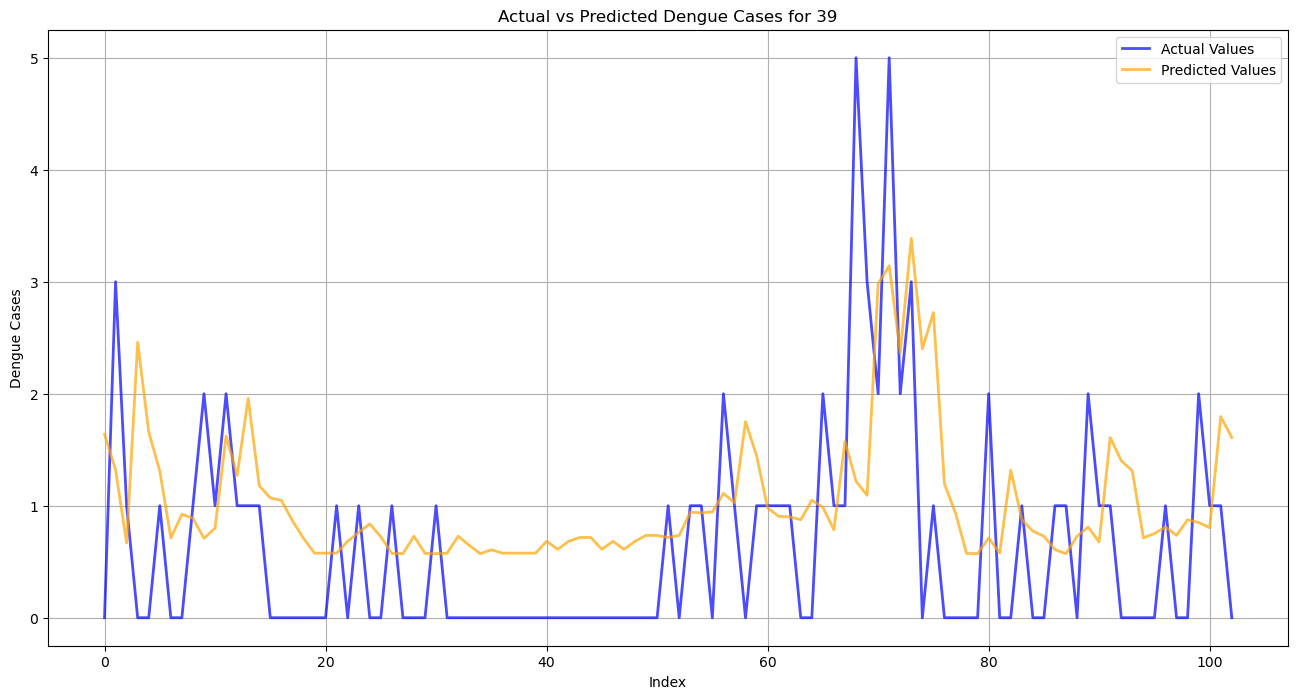

City: 40, RMSE: 1.157542489445078


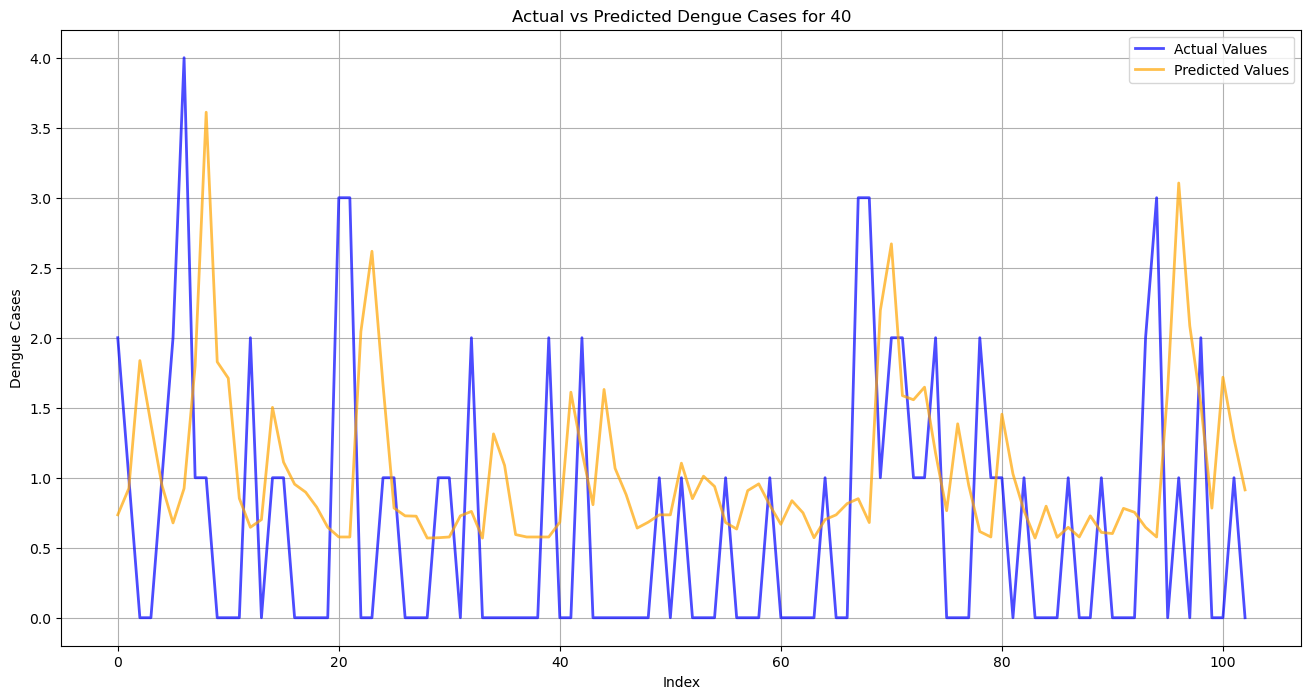

City: 41, RMSE: 0.6501464624473909


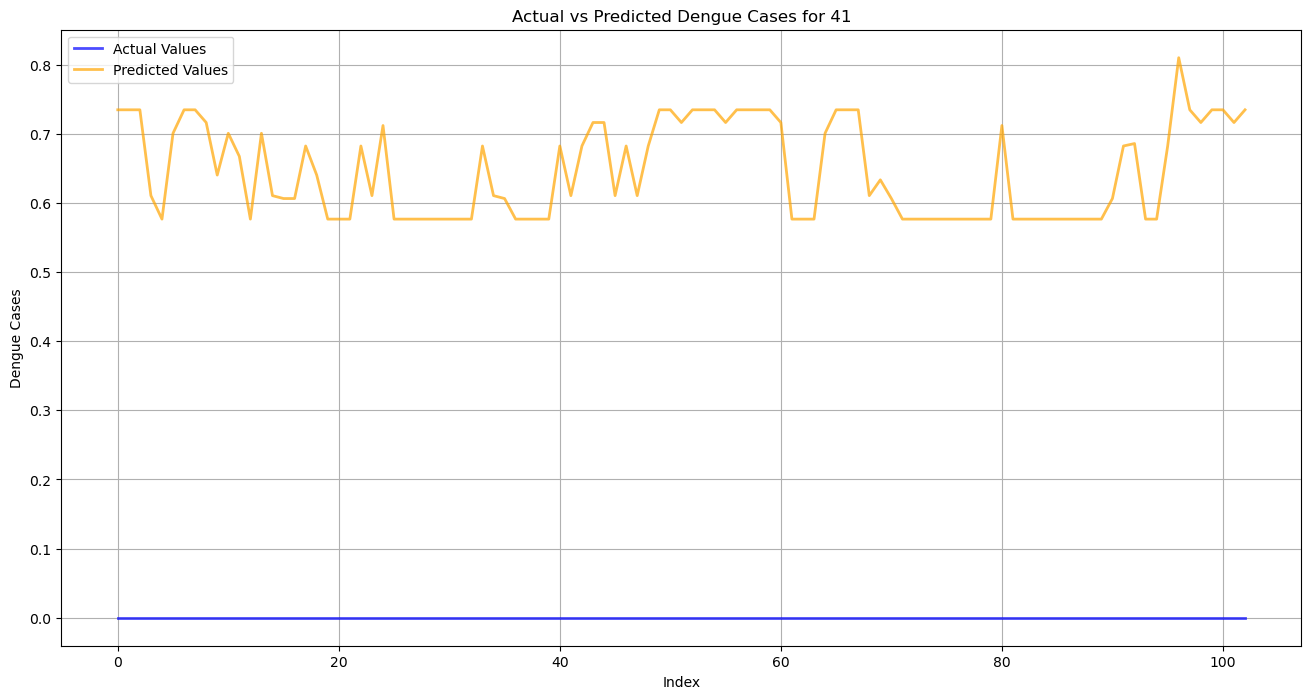

City: 42, RMSE: 1.0468841773749142


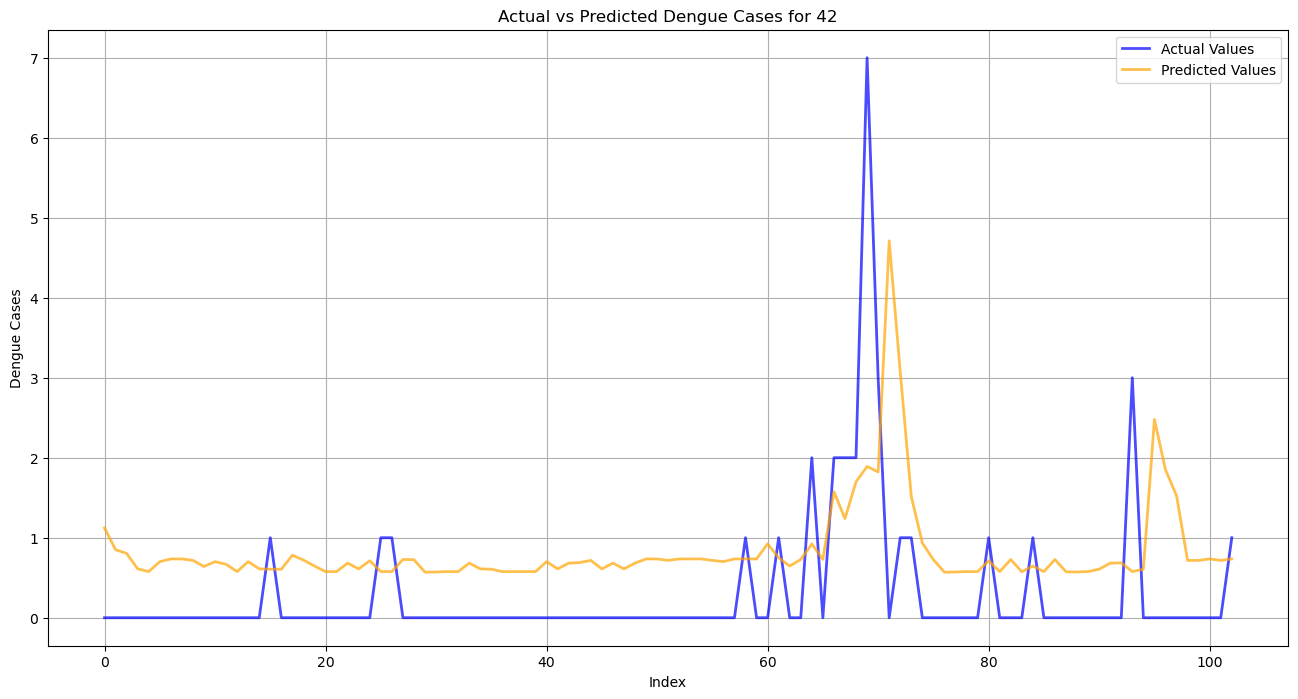

City: 43, RMSE: 1.0677653863861931


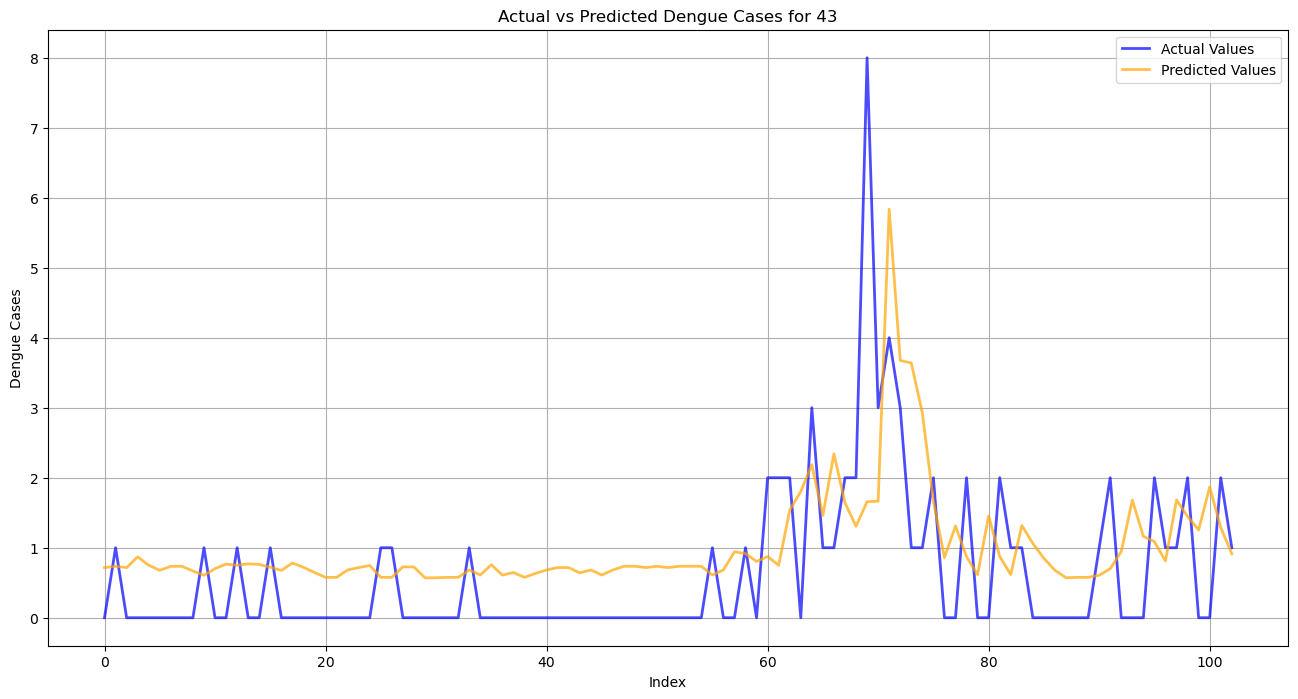

City: 44, RMSE: 0.6735132987495492


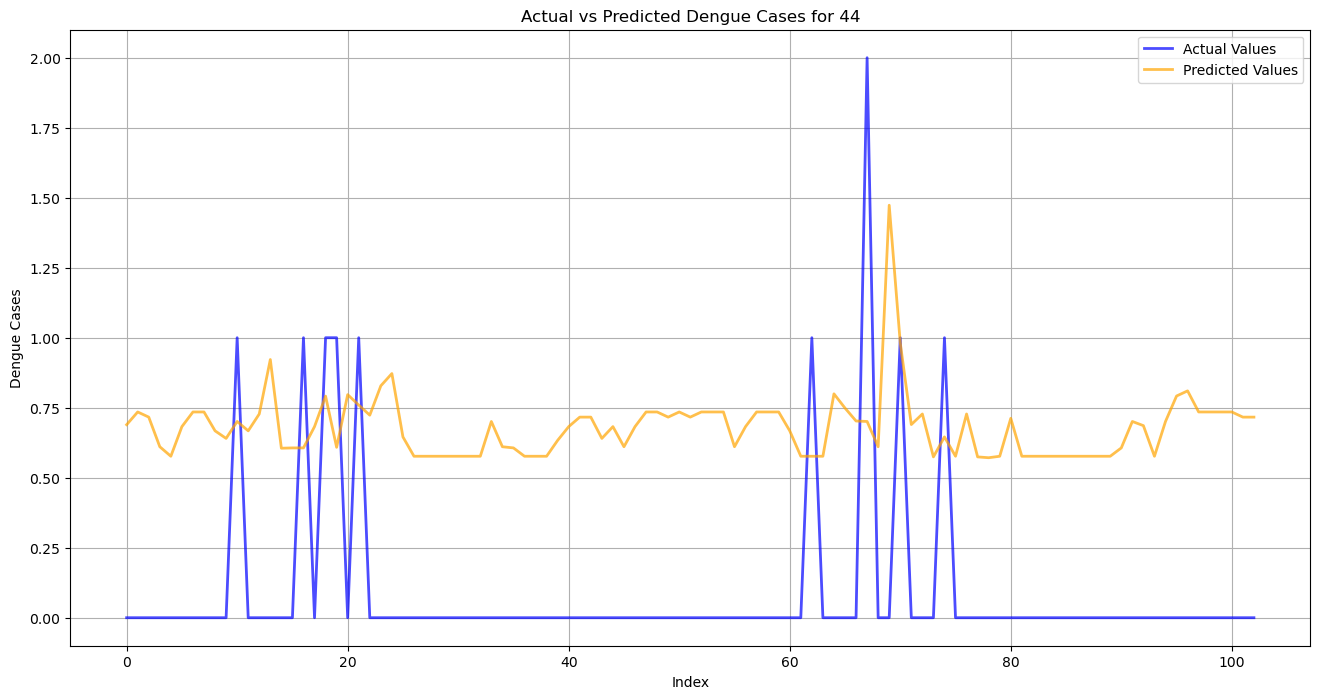

City: 45, RMSE: 0.7953584573162861


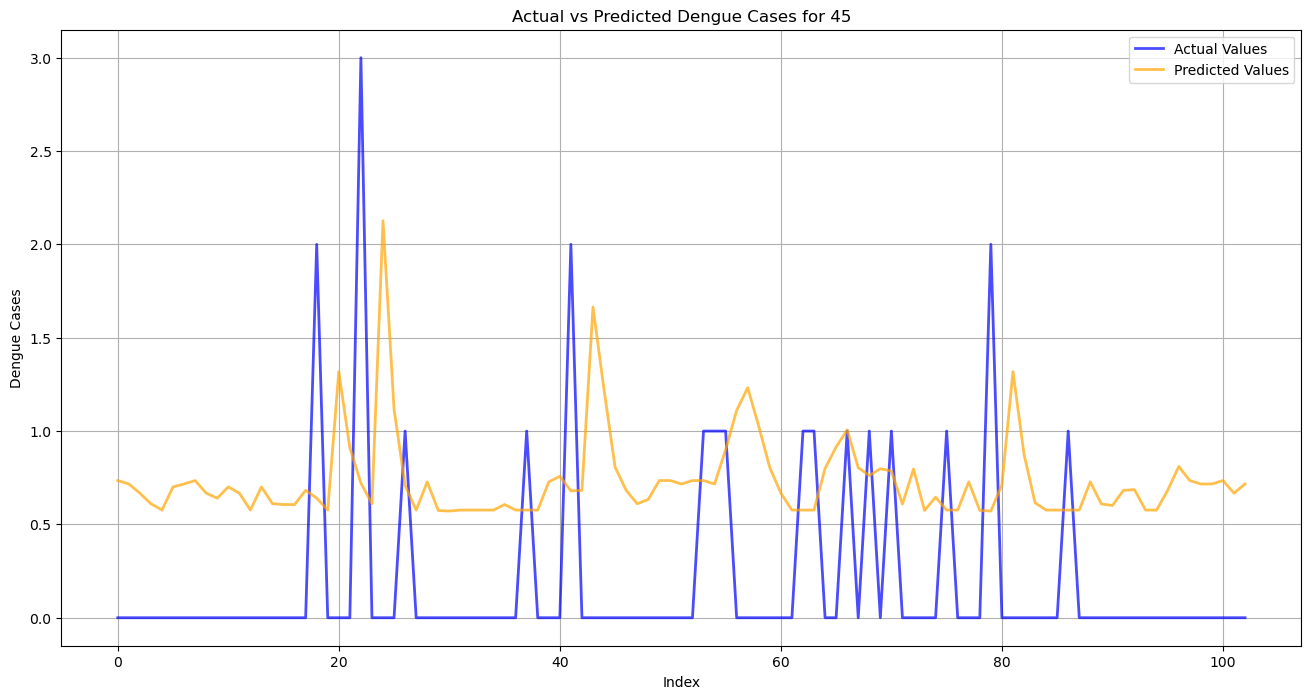

City: 46, RMSE: 1.6350397752564894


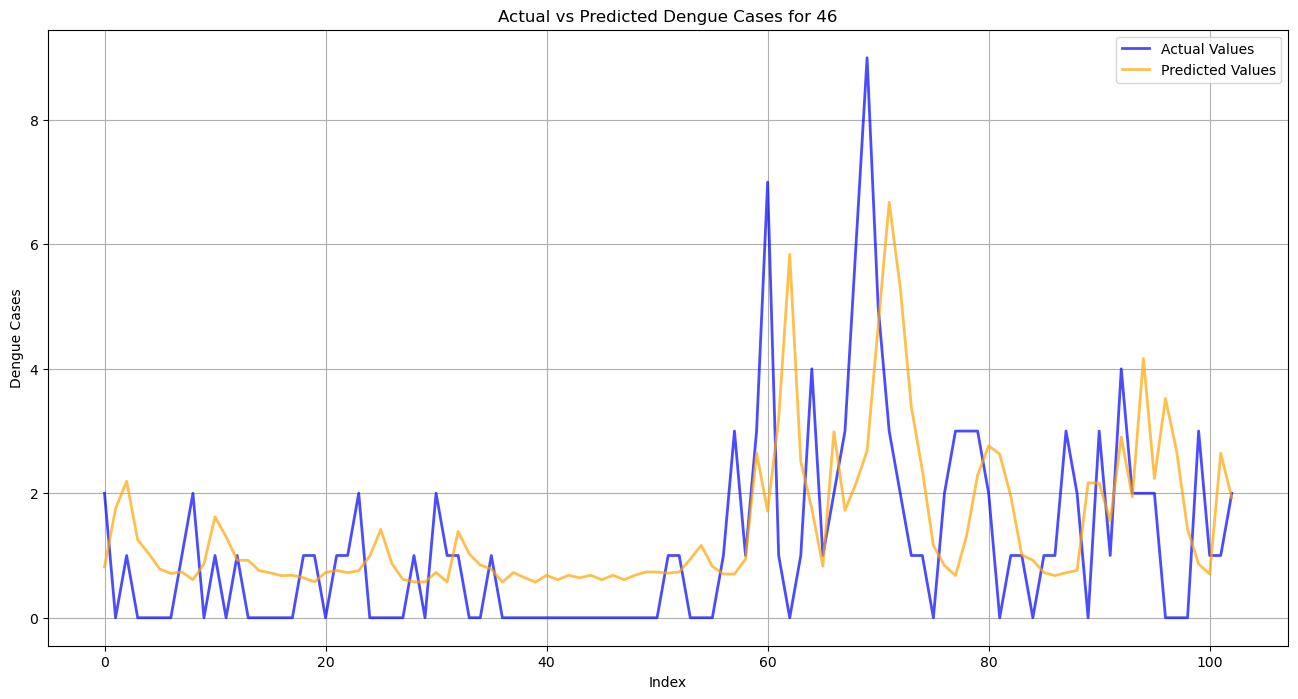

City: 47, RMSE: 4.88658968223845


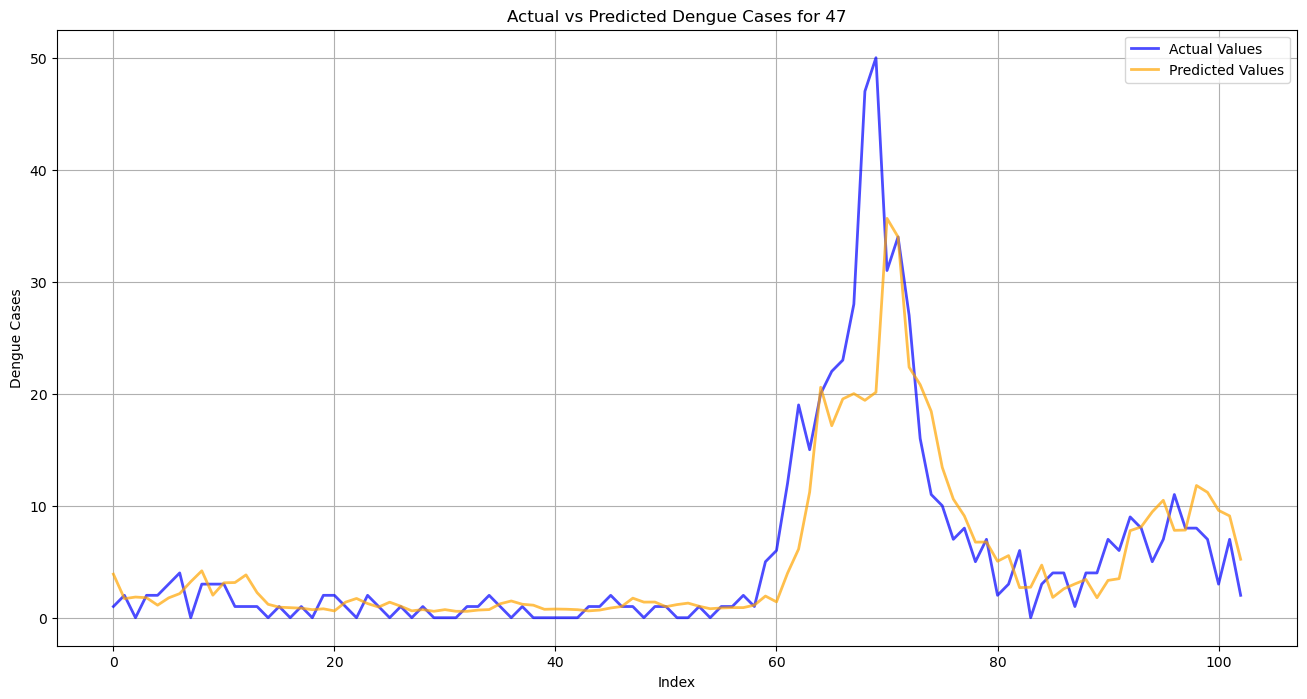

City: 48, RMSE: 2.749260893859139


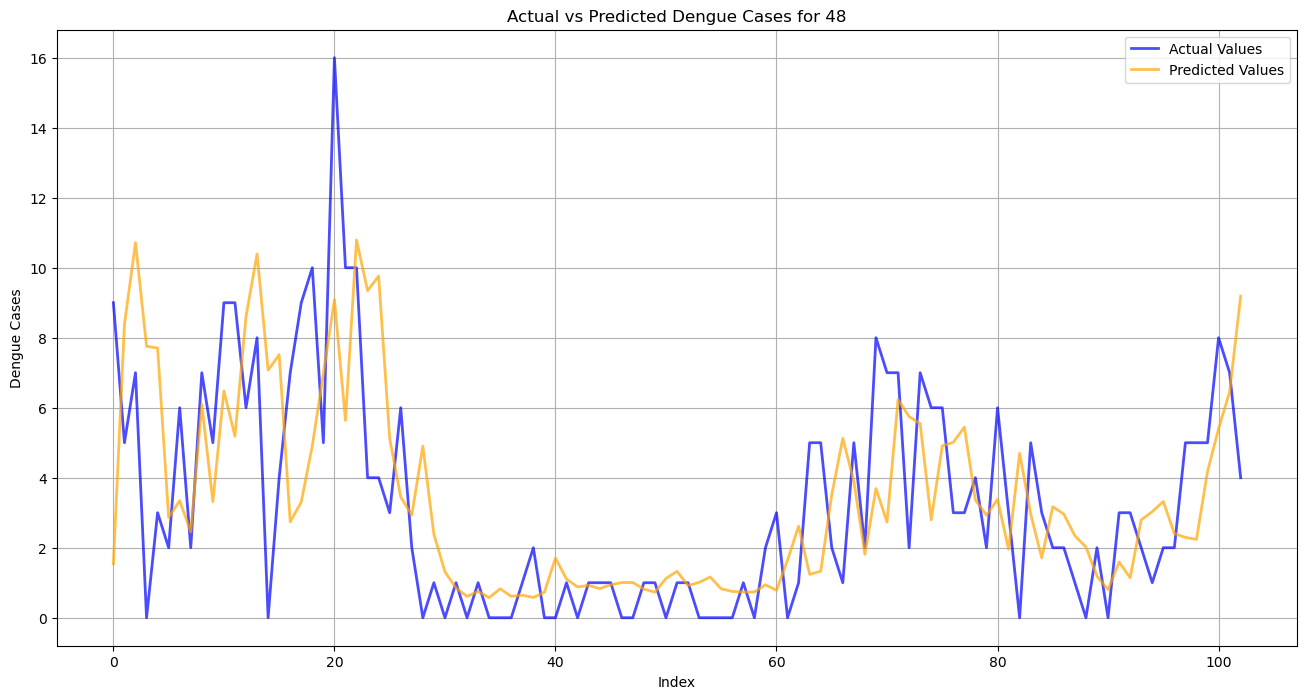

City: 49, RMSE: 0.8576744936892698


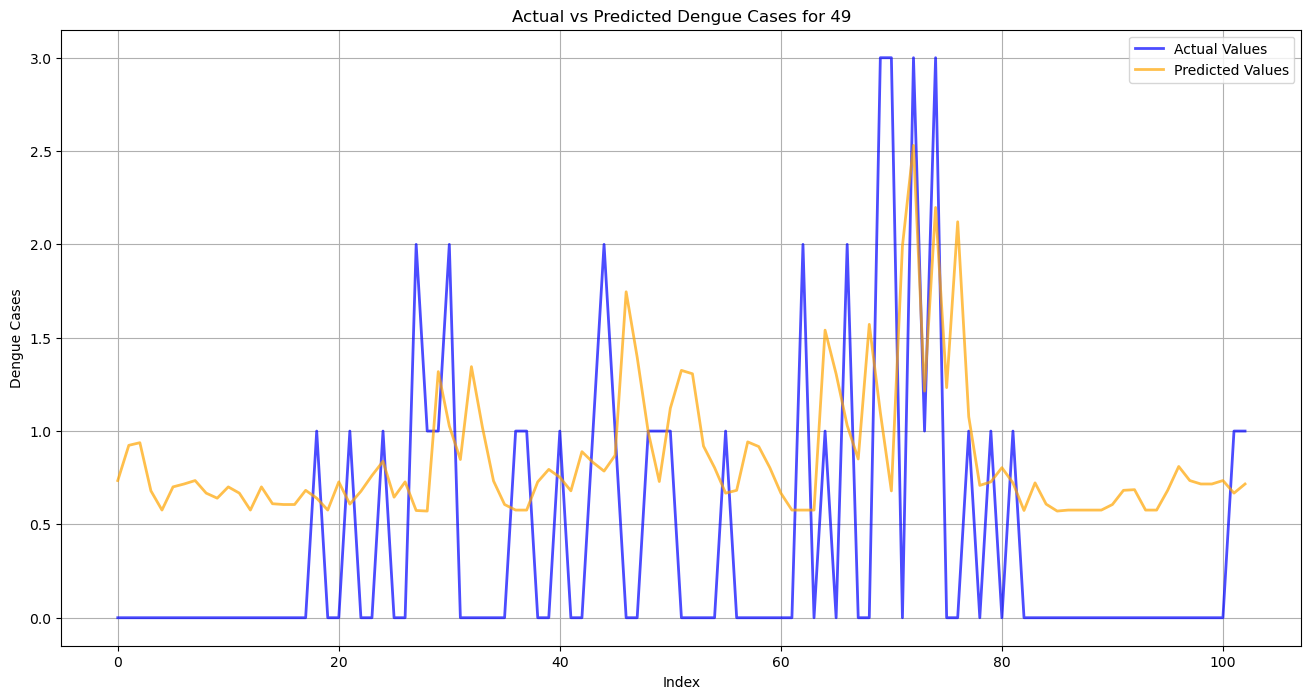

City: 51, RMSE: 0.7122940871384978


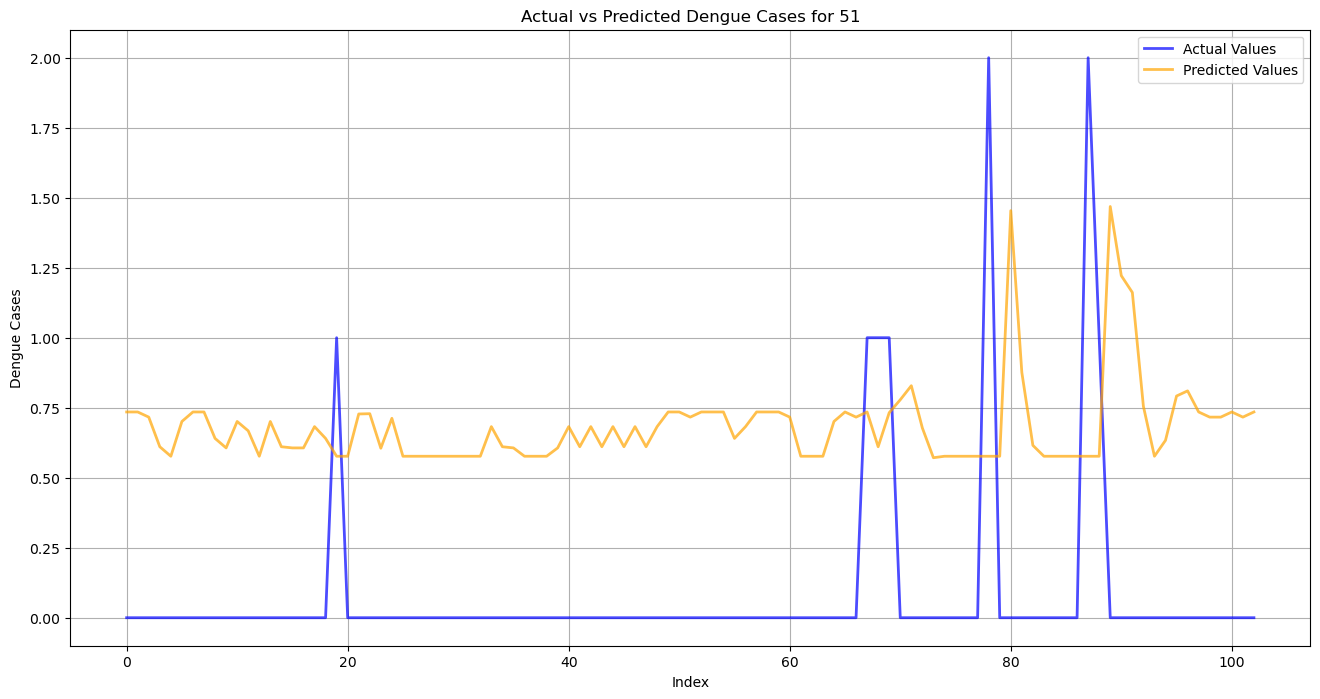

City: 50, RMSE: 6.670605814227901


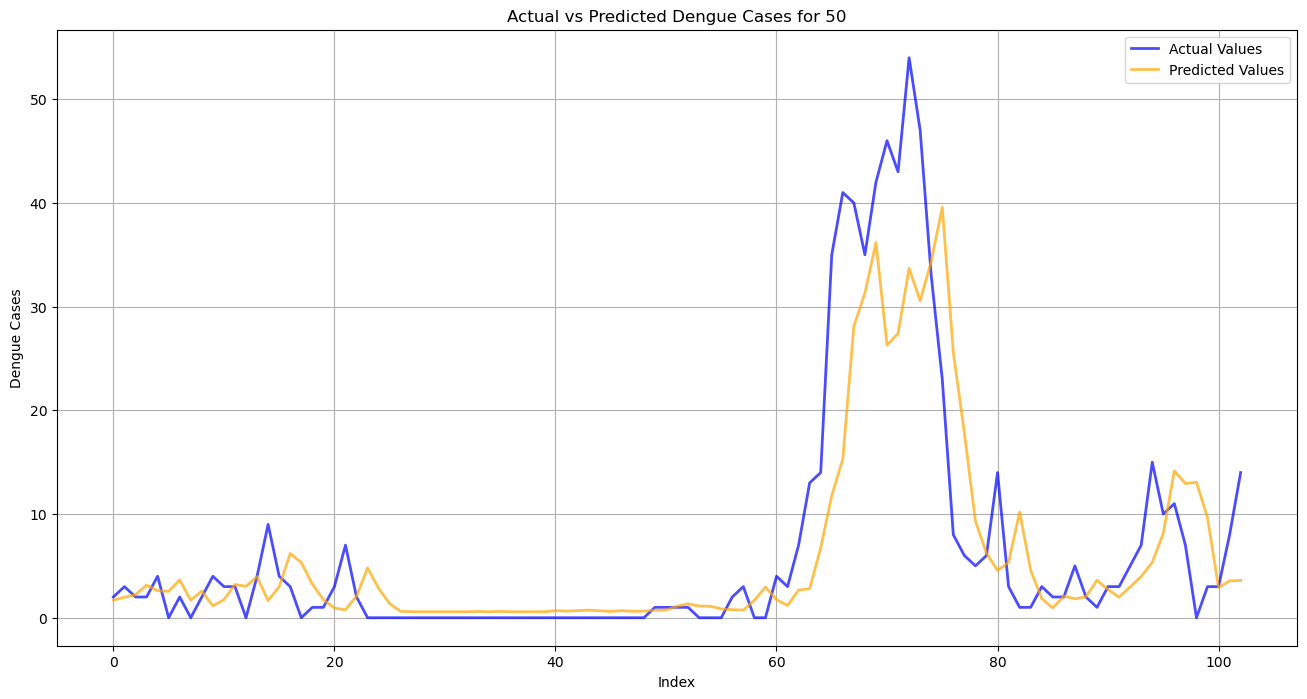

City: 52, RMSE: 0.7627704549761781


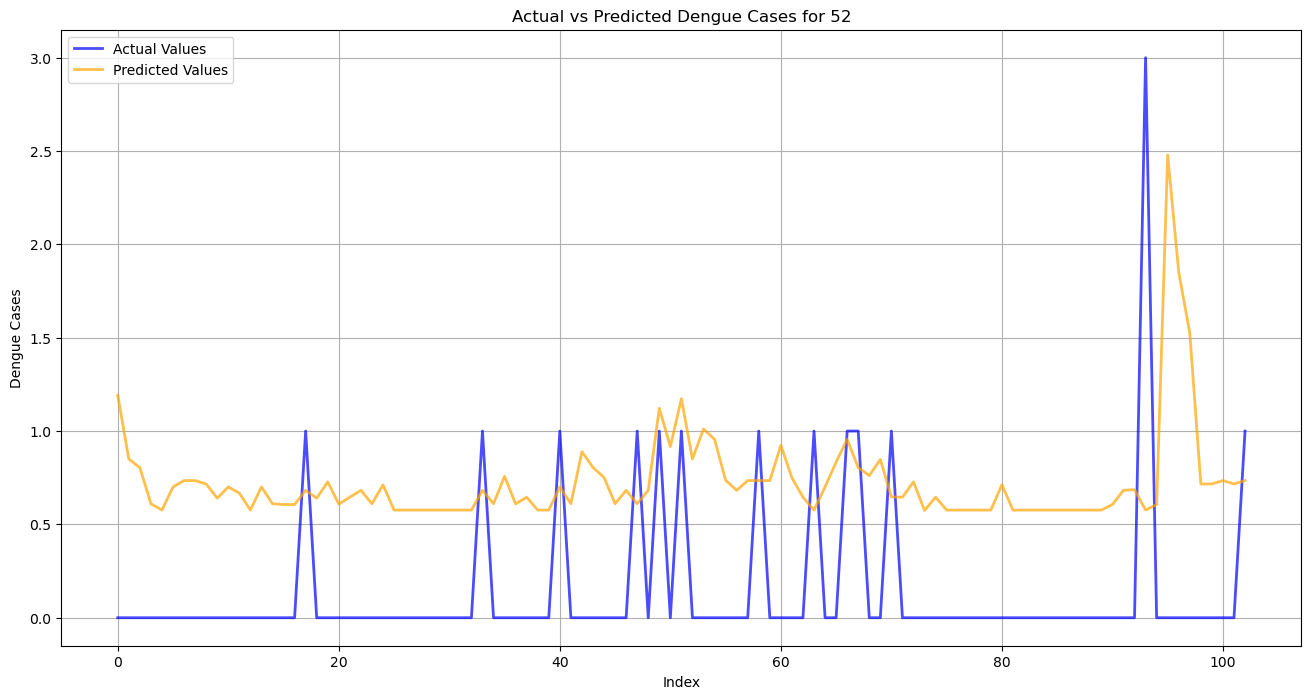

City: 53, RMSE: 1.8272796534689648


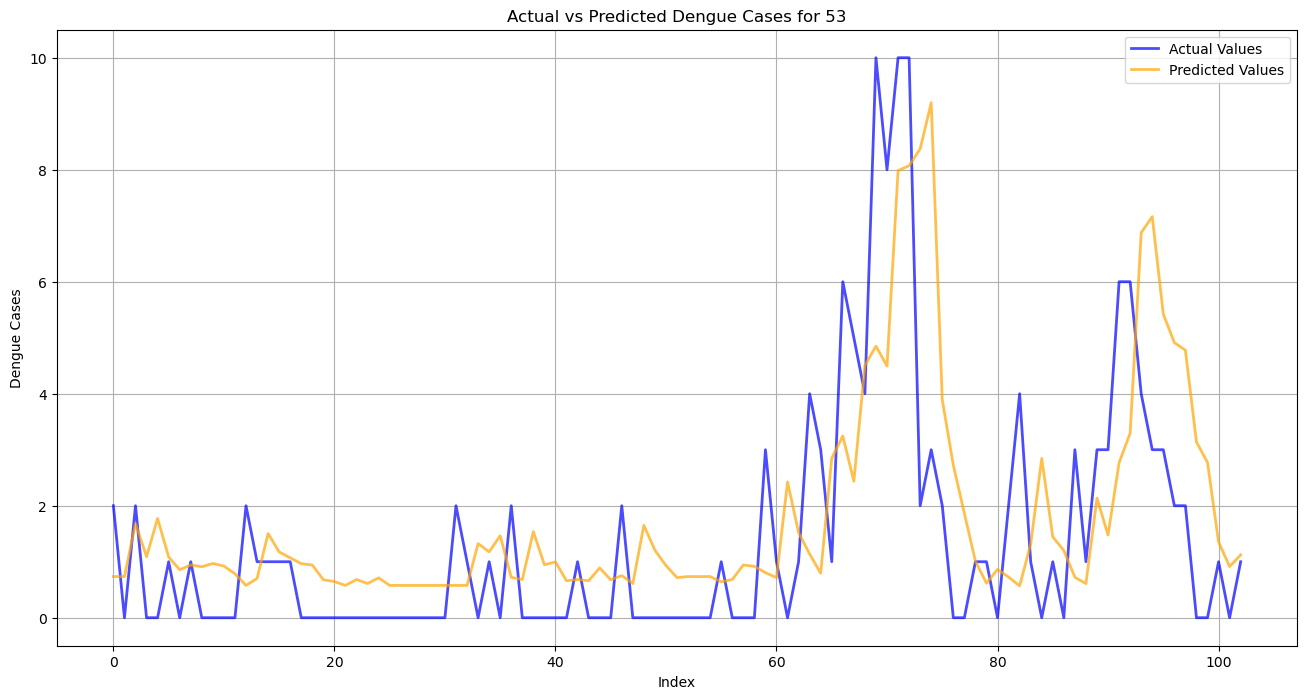

City: 54, RMSE: 0.8211086312111229


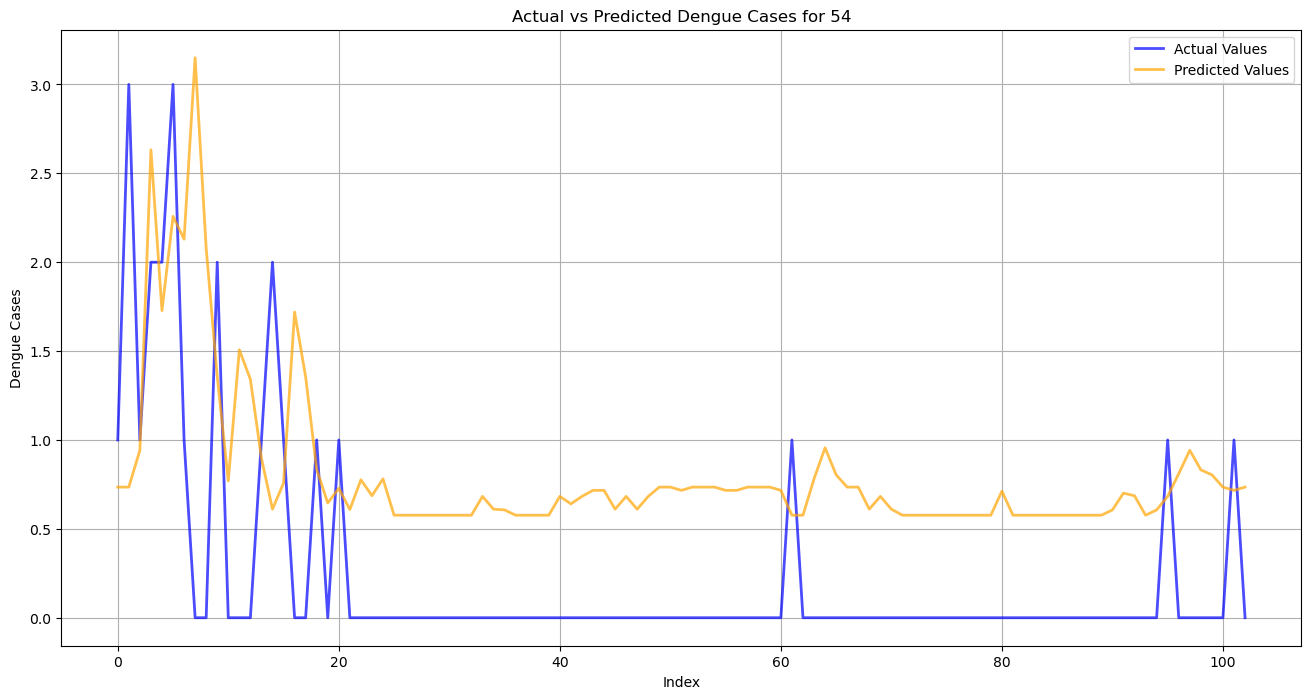

City: 55, RMSE: 2.2524484515536356


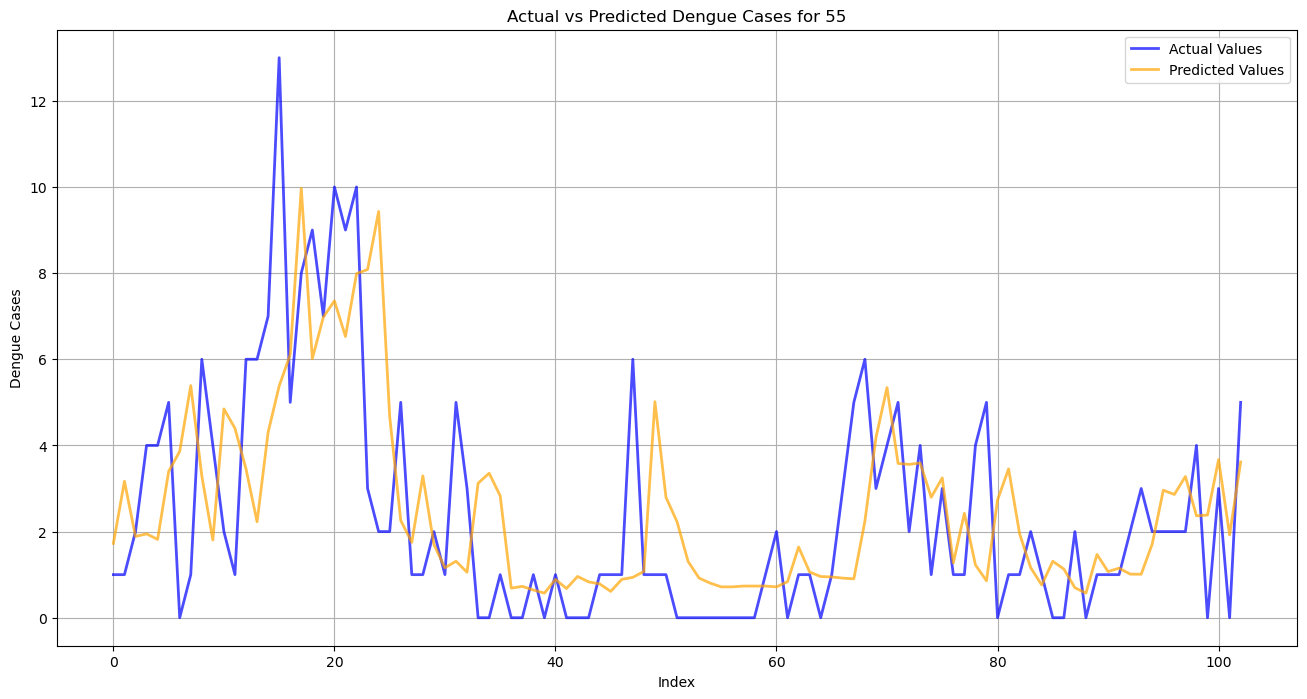

City: 56, RMSE: 3.6673413598143183


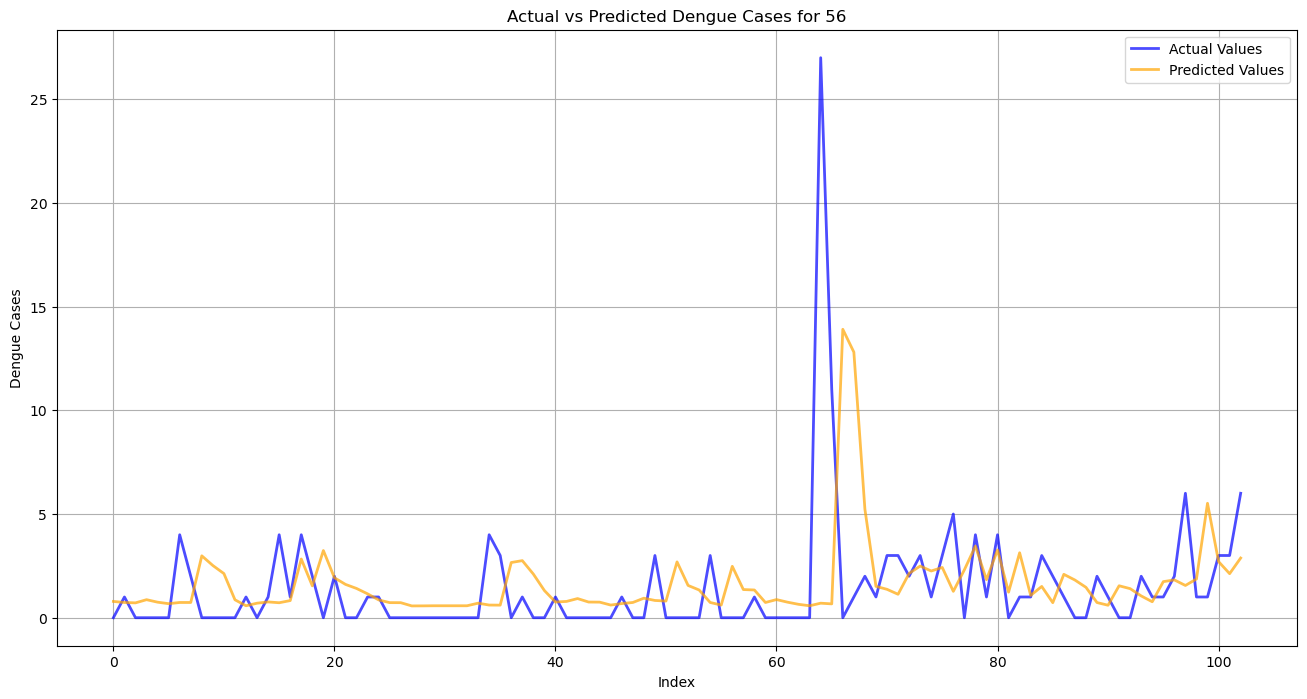

City: 57, RMSE: 1.4069237021526382


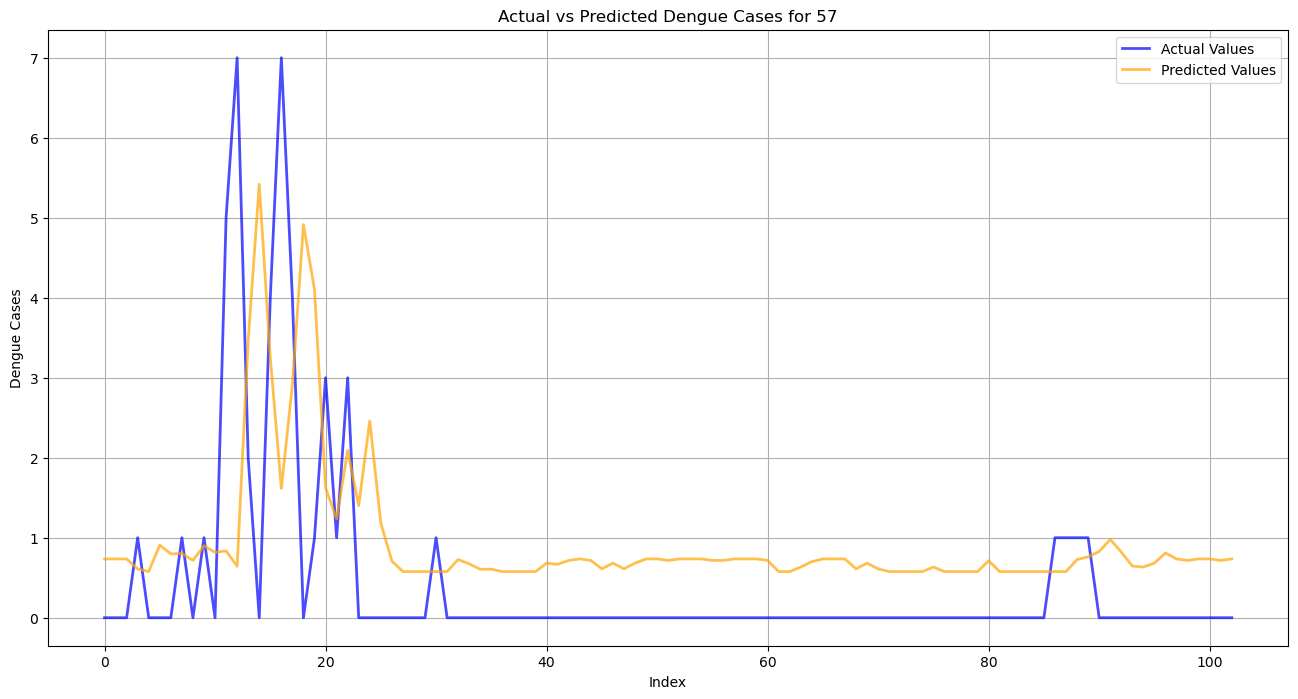

City: 58, RMSE: 2.2676545524104905


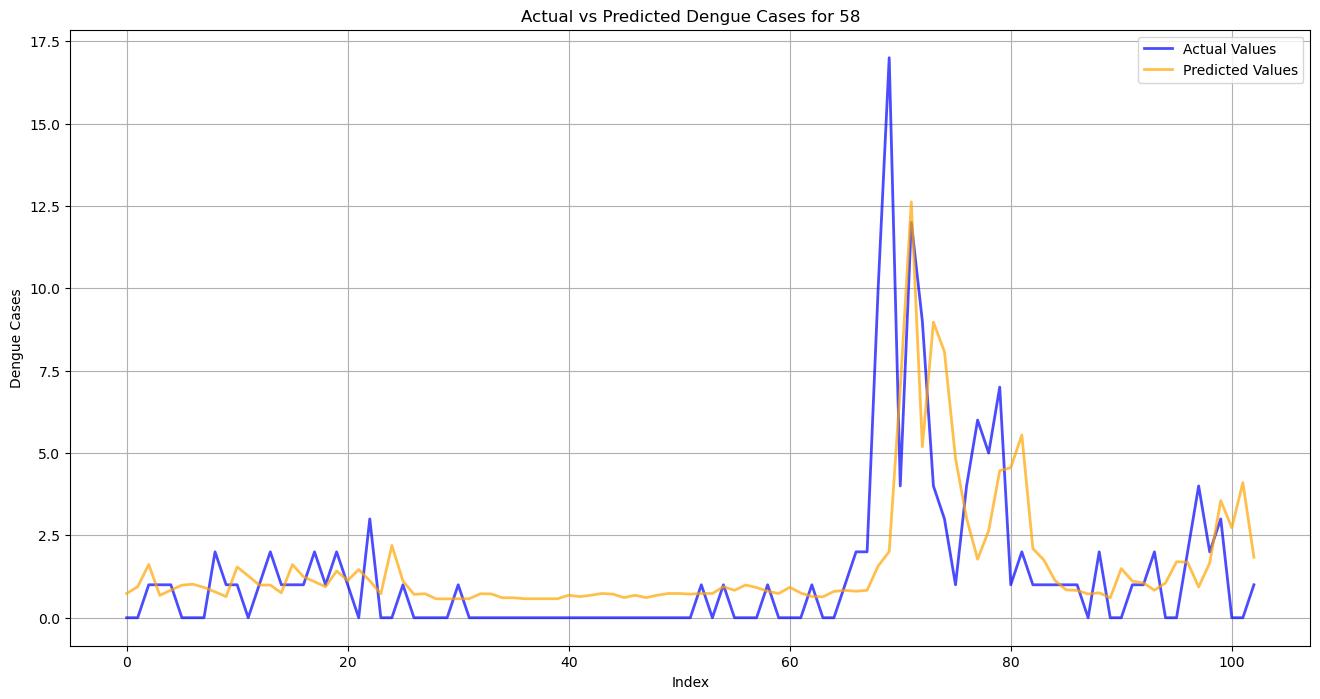

City: 59, RMSE: 0.7289527251708449


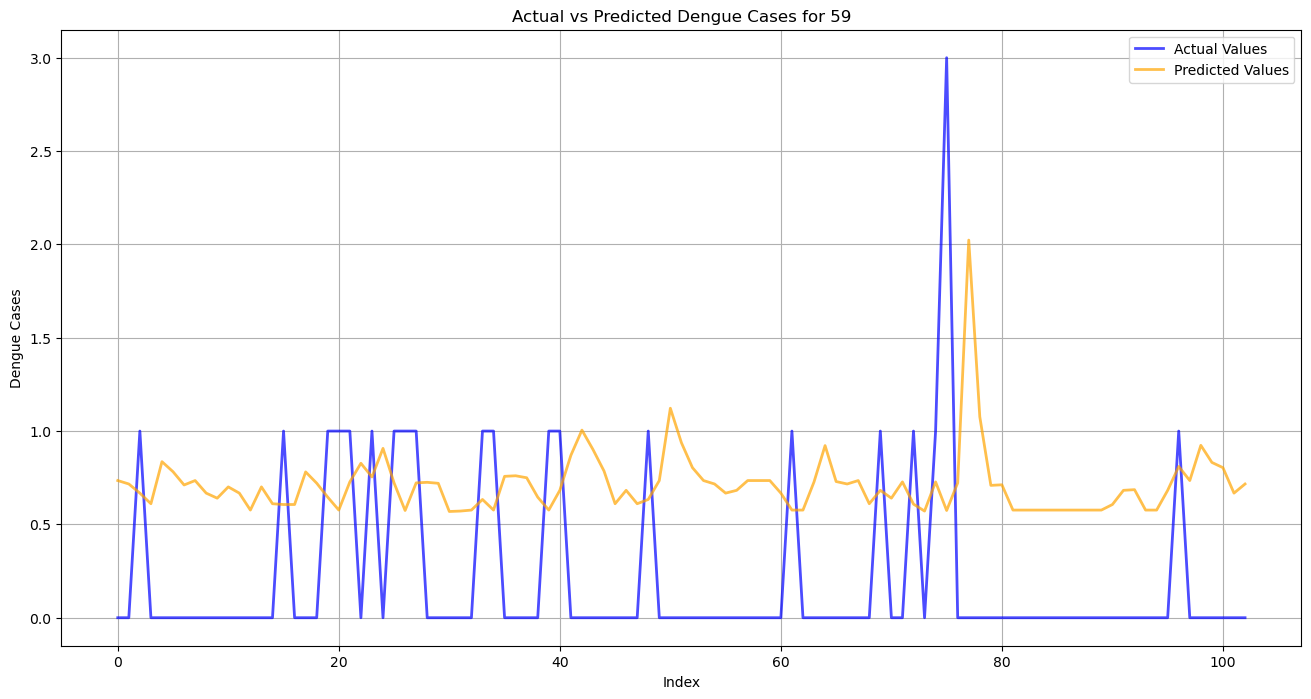

City: 60, RMSE: 3.1709982657105846


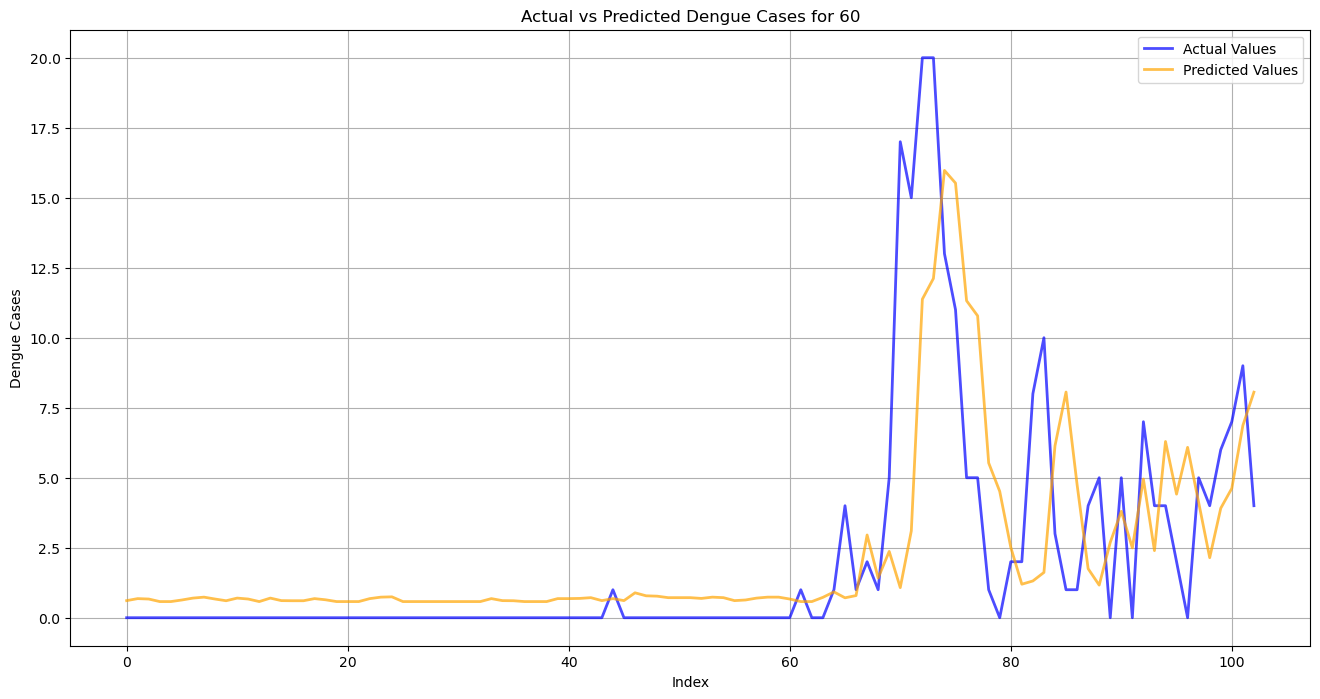

City: 61, RMSE: 10.683891172548128


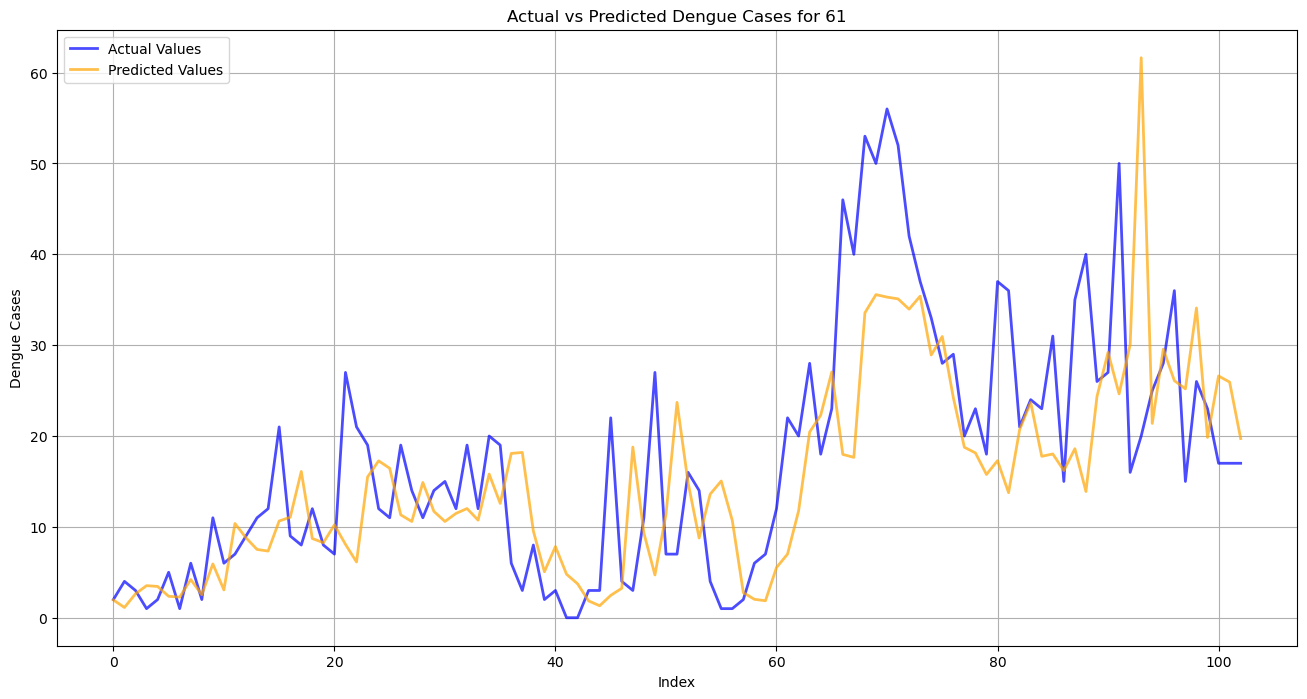

City: 62, RMSE: 0.7130578638633166


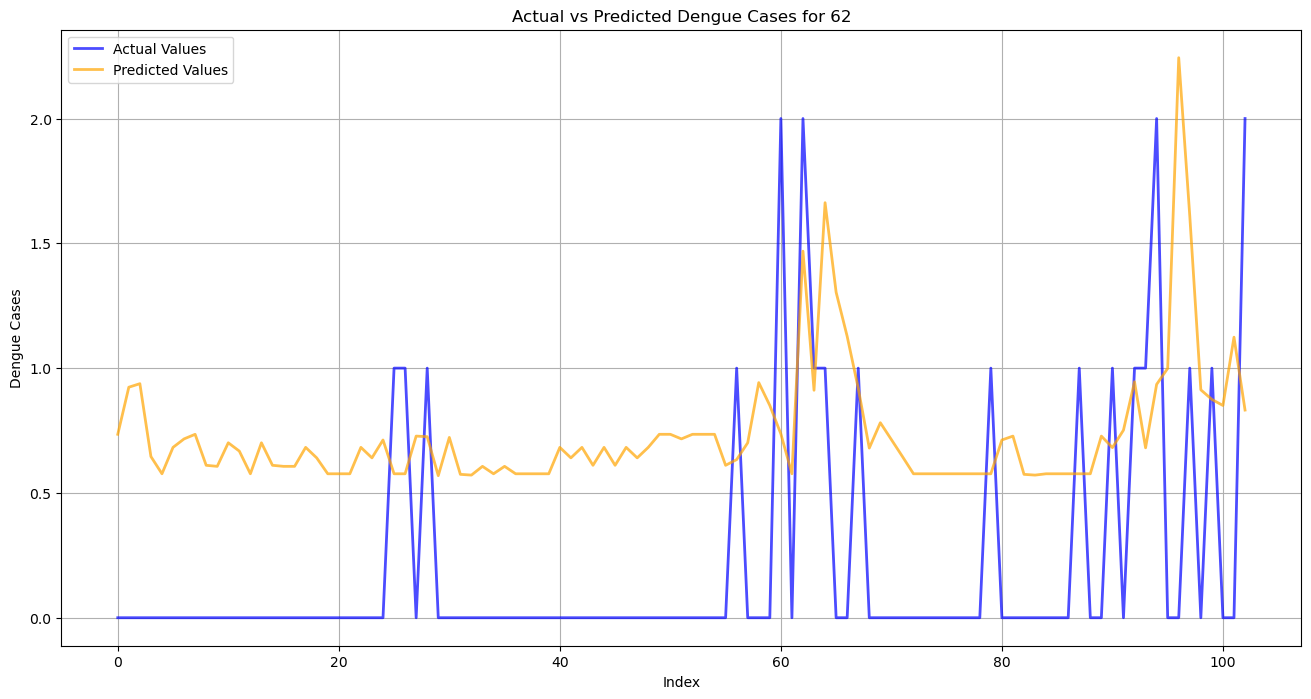

City: 63, RMSE: 0.6568809724172867


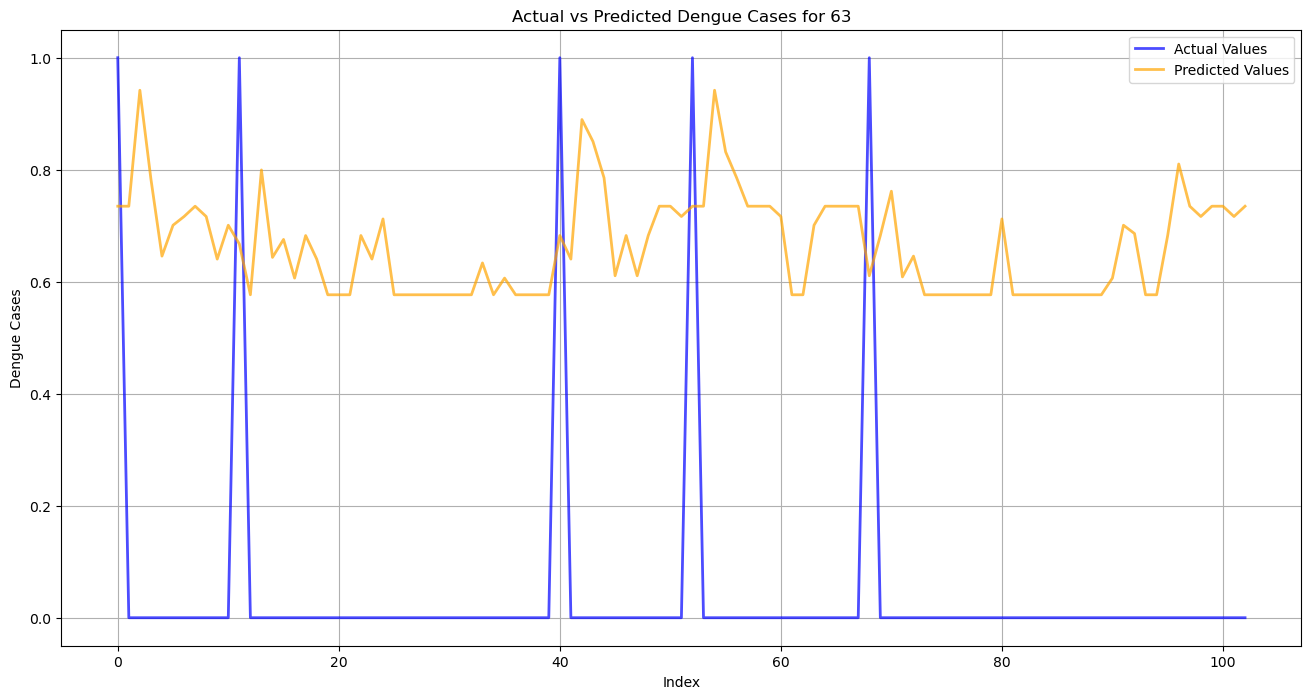

City: 64, RMSE: 0.6518923081735446


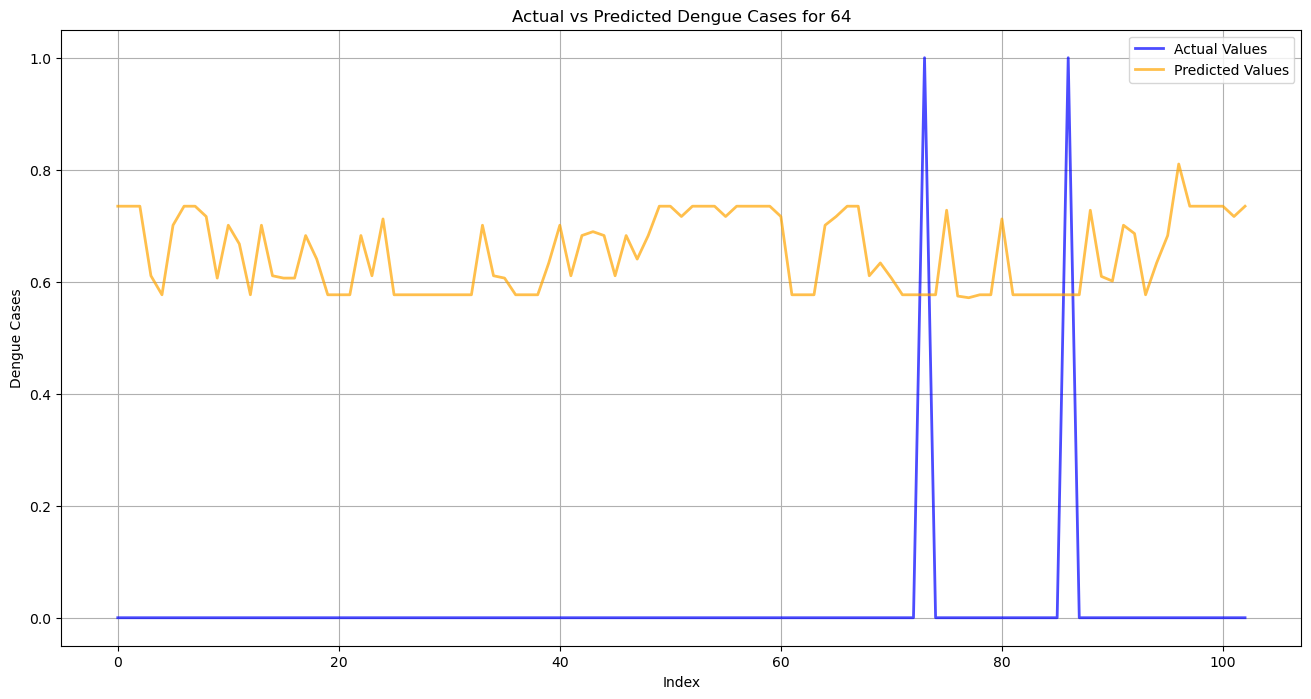

City: 65, RMSE: 8.19795541749612


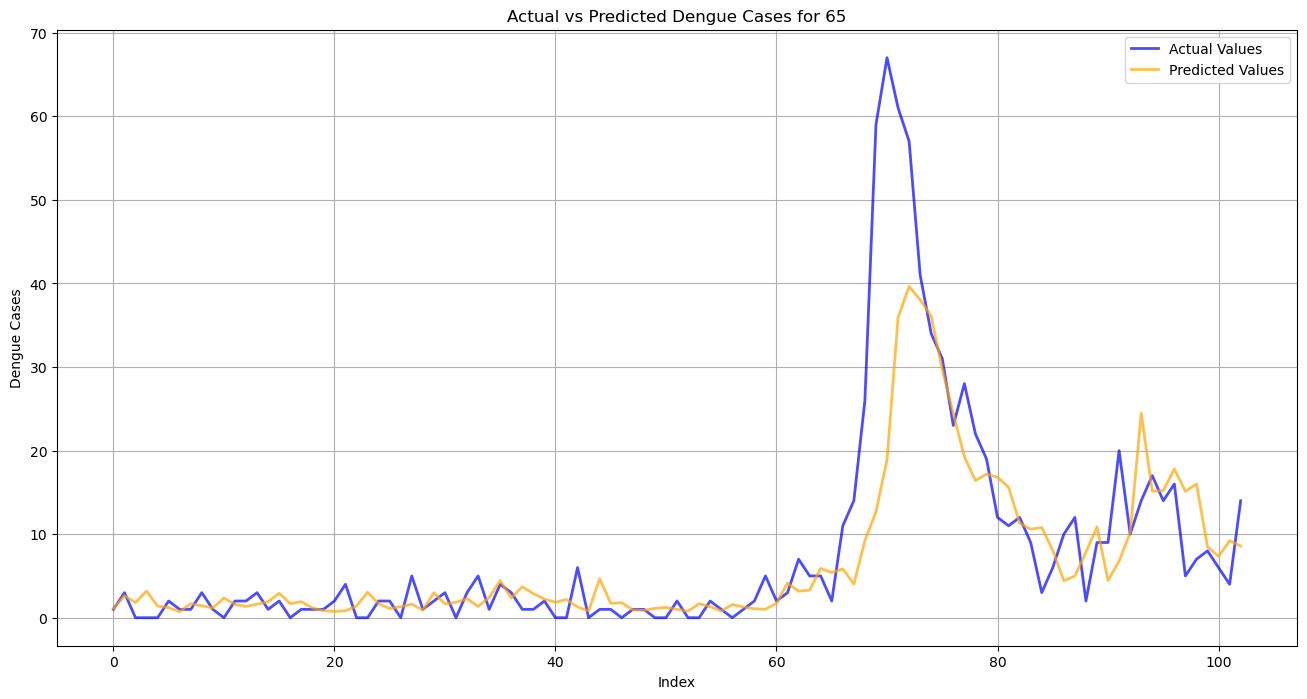

City: 66, RMSE: 42.5207796240268


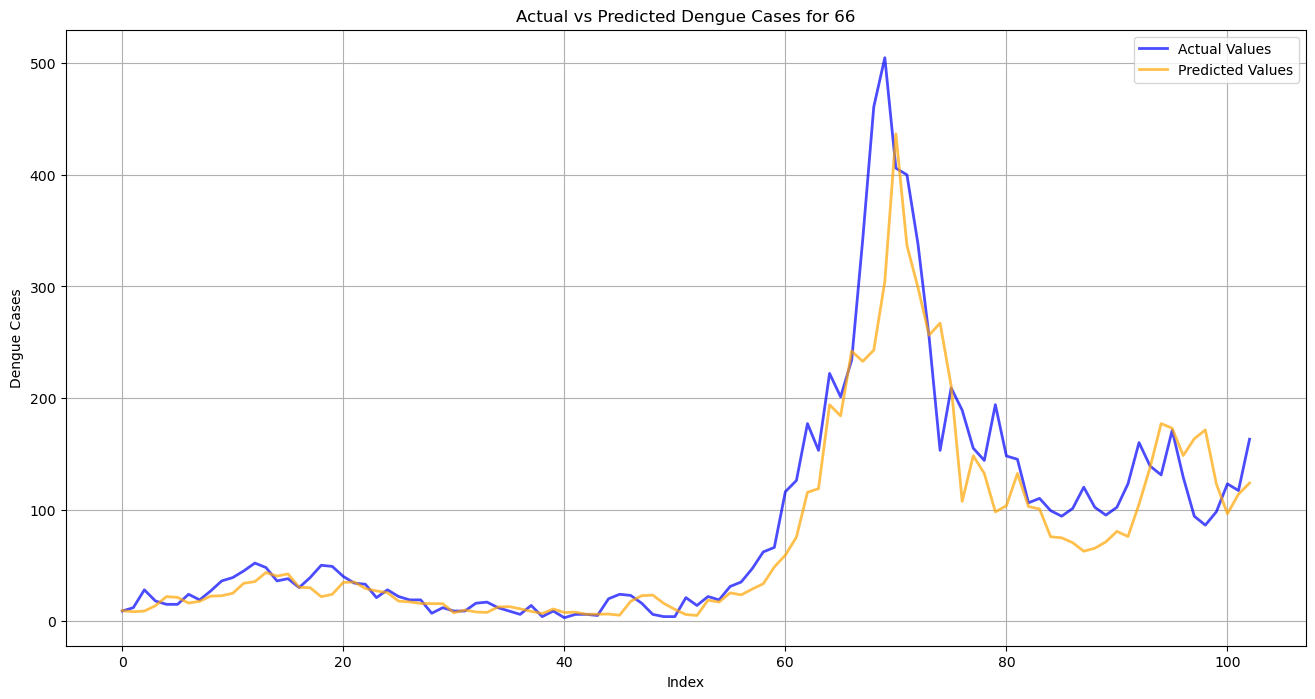

City: 67, RMSE: 0.6469227244336697


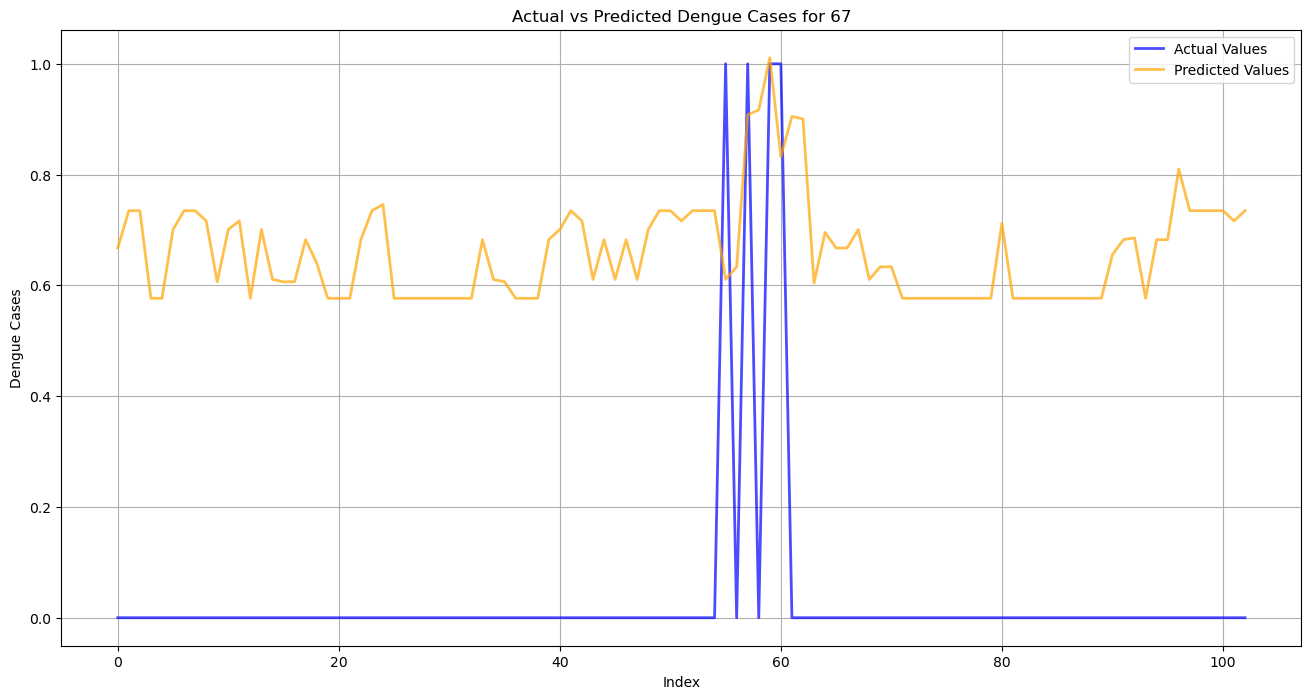

City: 68, RMSE: 5.0064545192834276


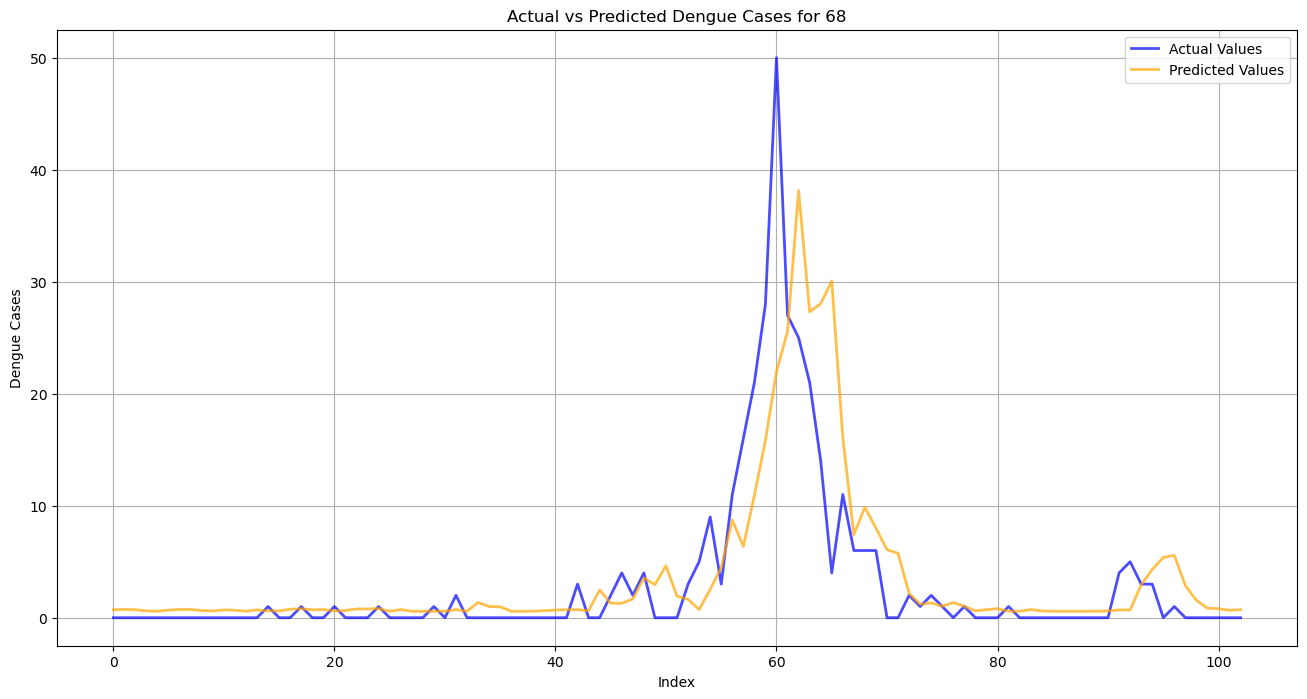

City: 75, RMSE: 0.6434674815094571


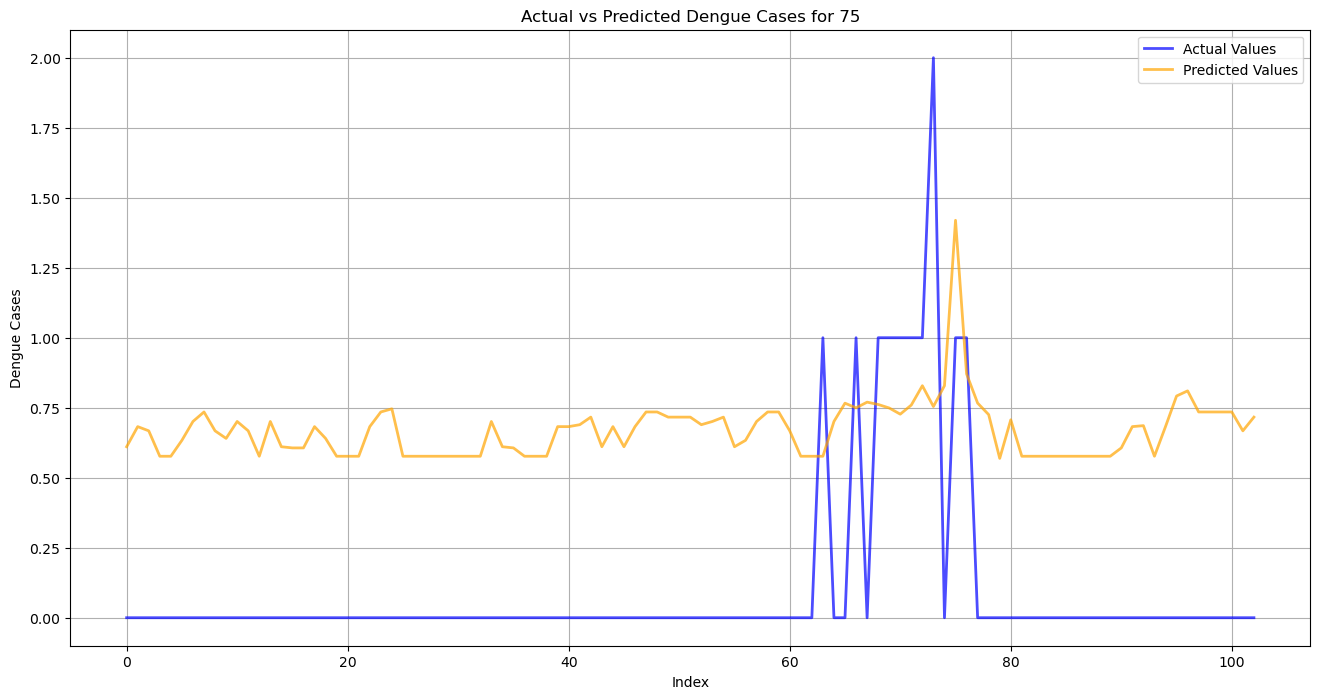

City: 74, RMSE: 0.7094427861828058


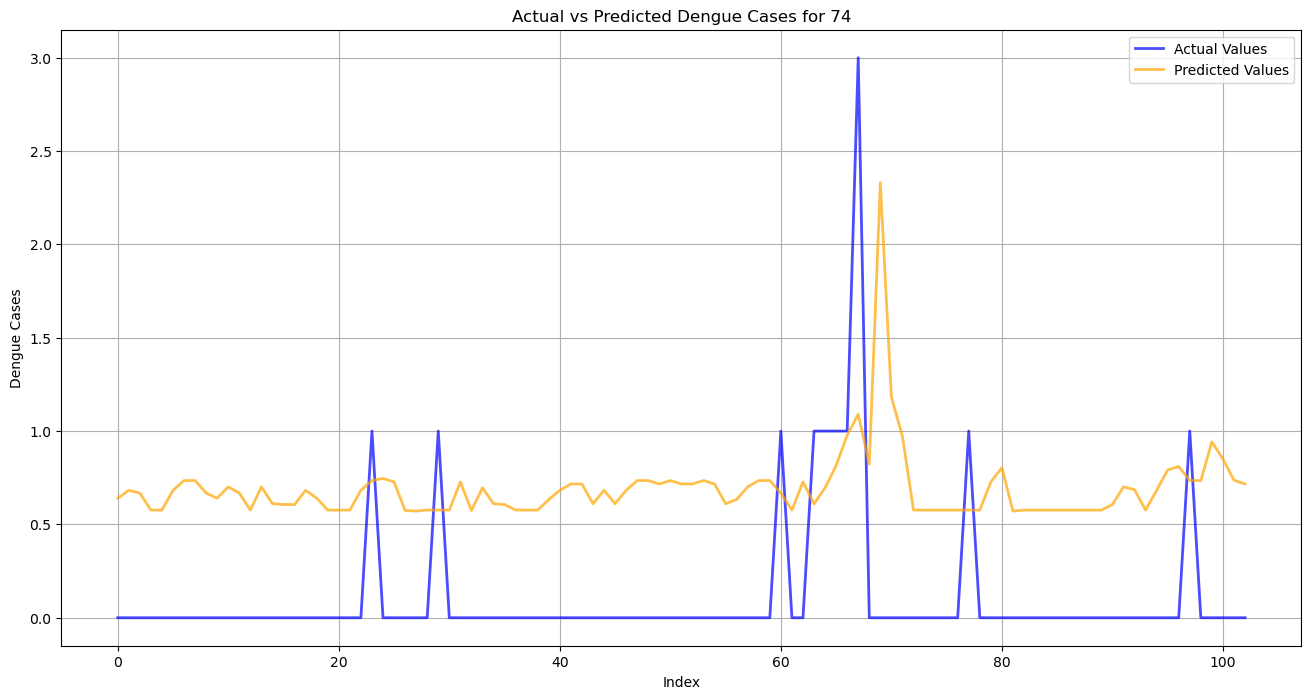

City: 76, RMSE: 2.379917932825013


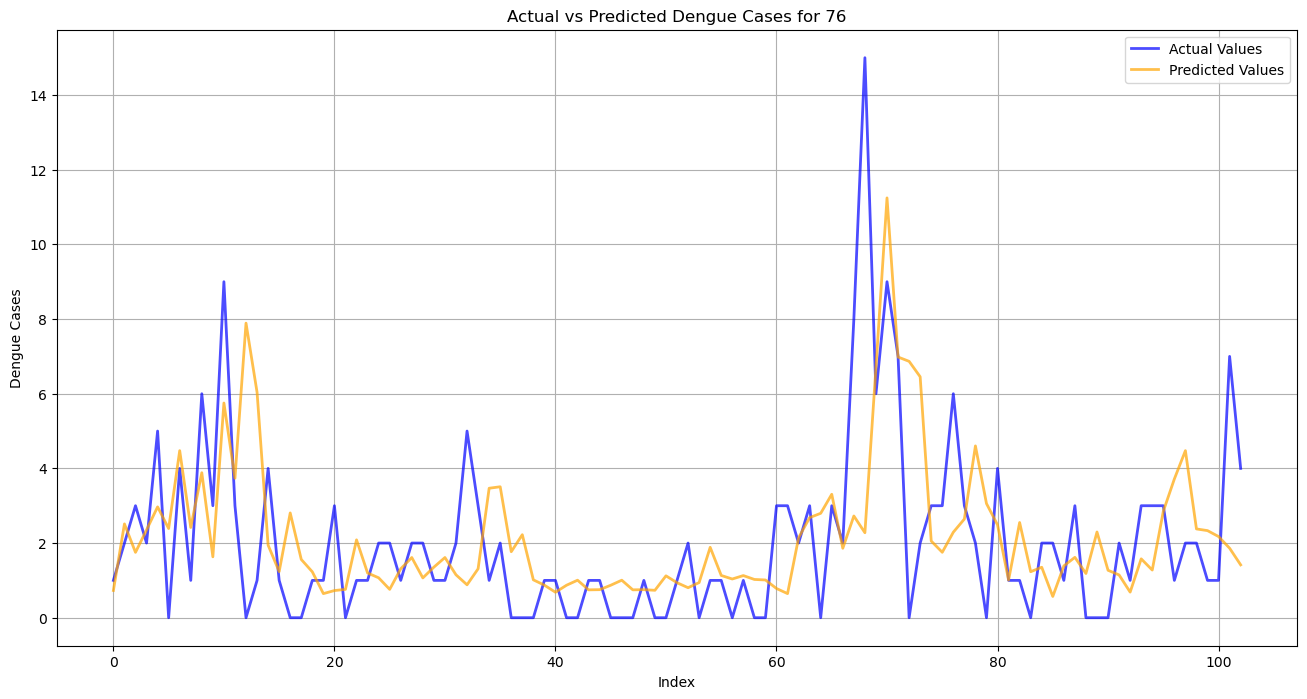

City: 79, RMSE: 0.7212742877076692


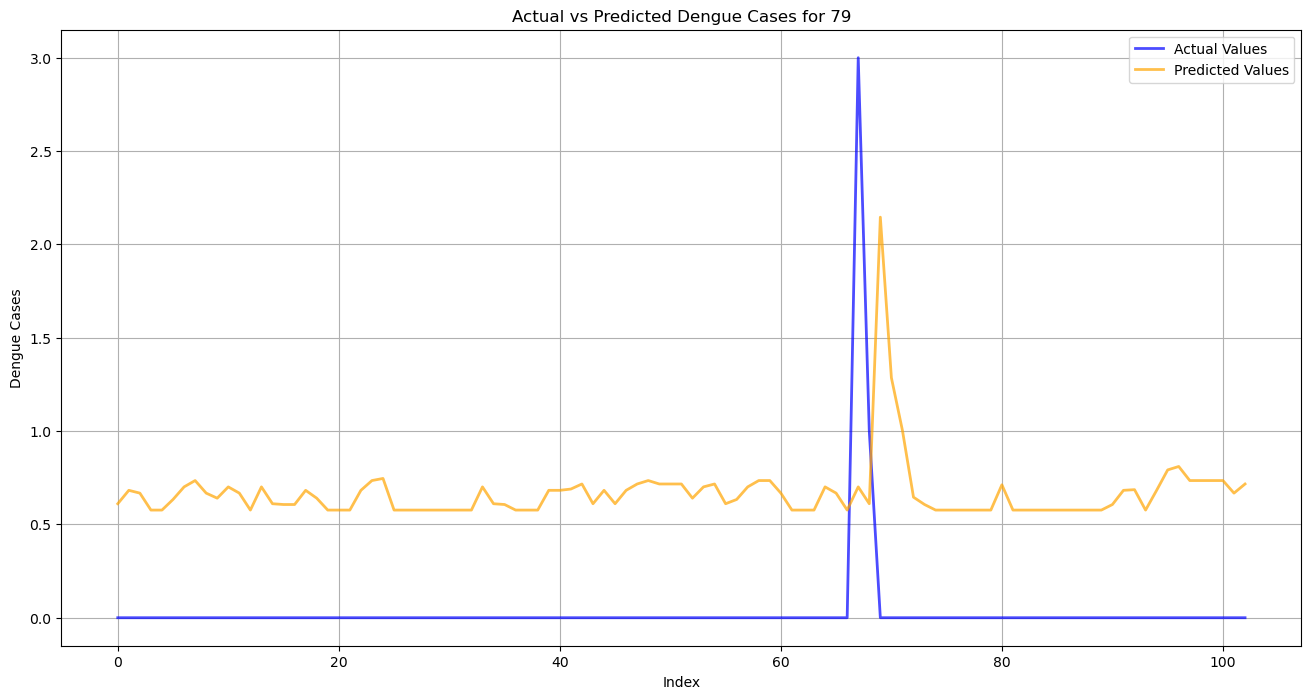

City: 80, RMSE: 2.418669172850081


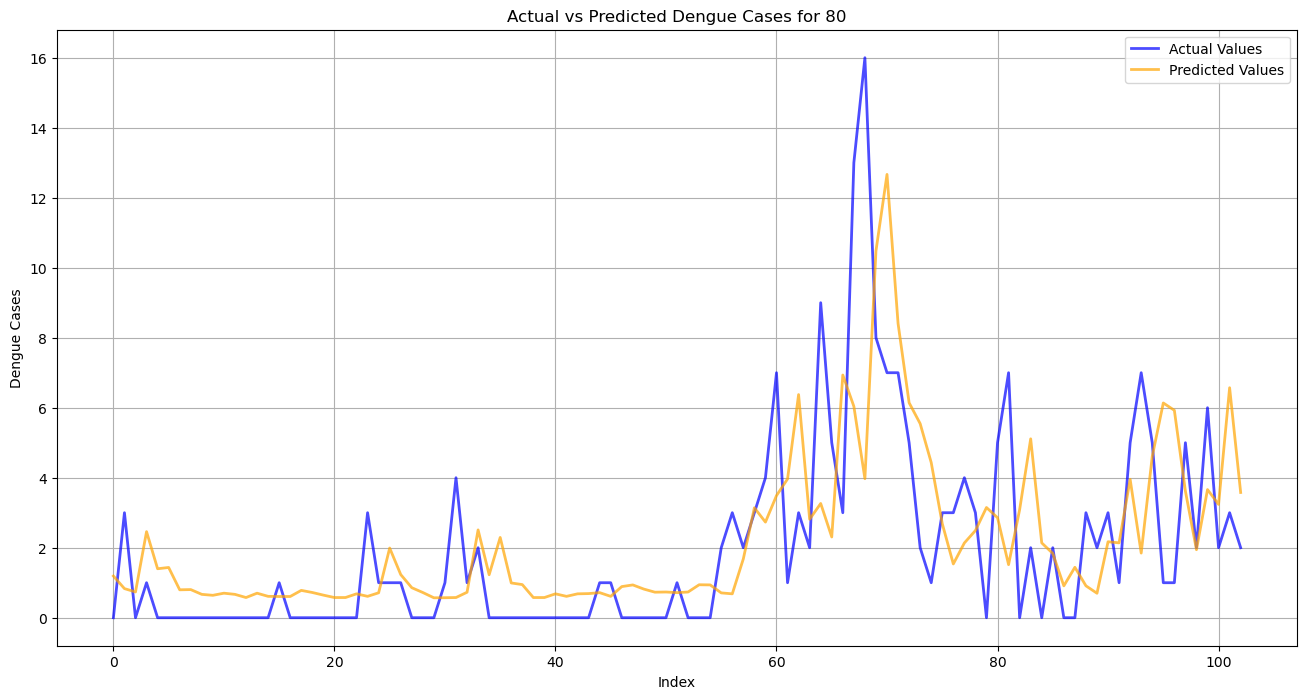

City: 77, RMSE: 1.3770229420060571


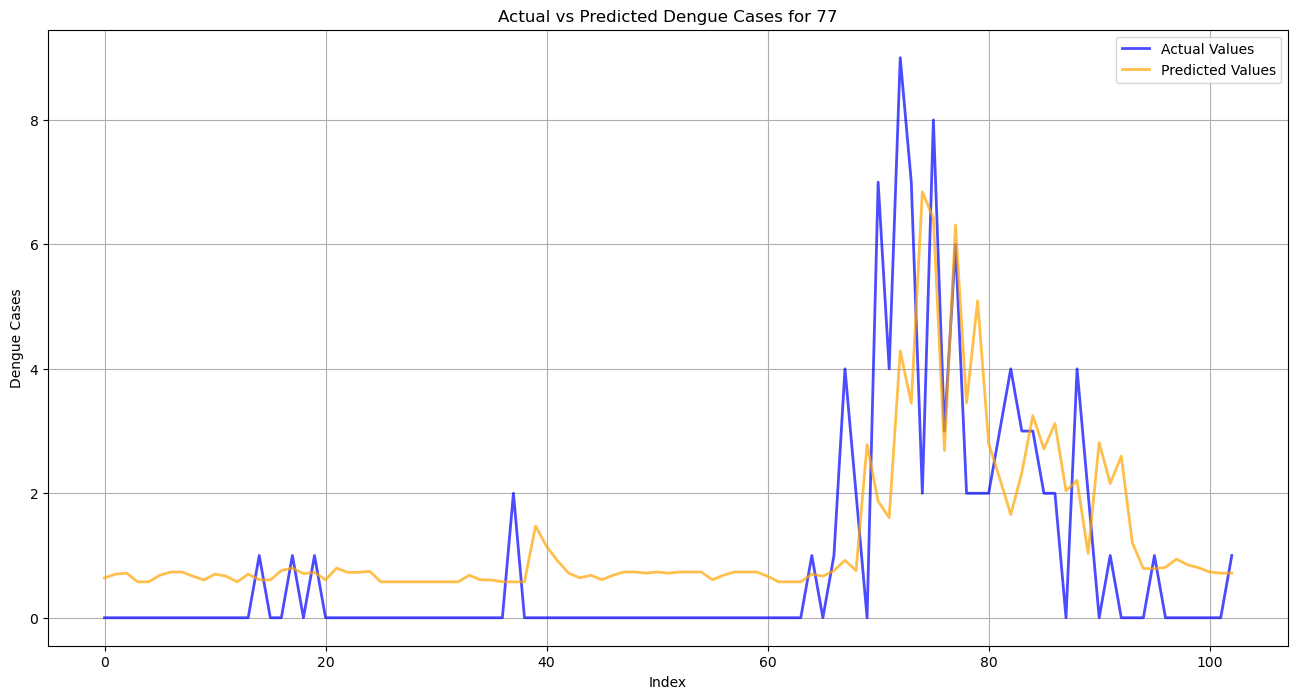

City: 78, RMSE: 0.6536978770086123


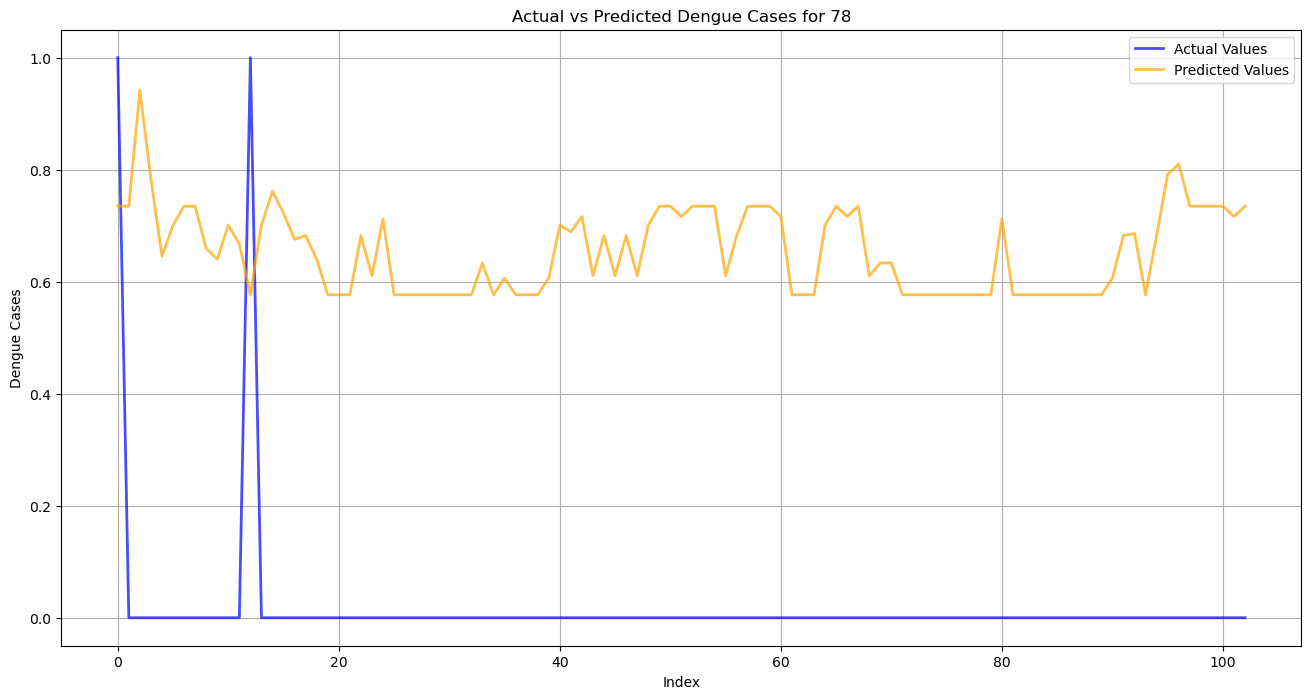

City: 81, RMSE: 1.8650450580185287


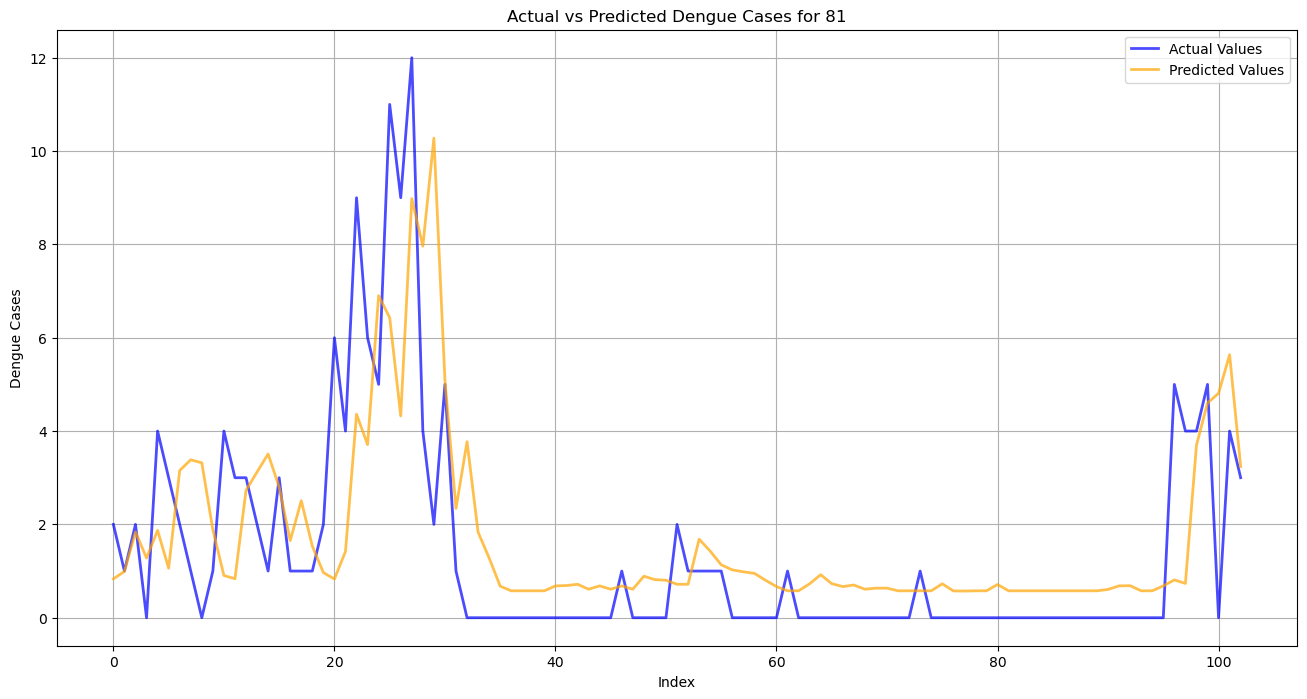

City: 82, RMSE: 0.7069997996015256


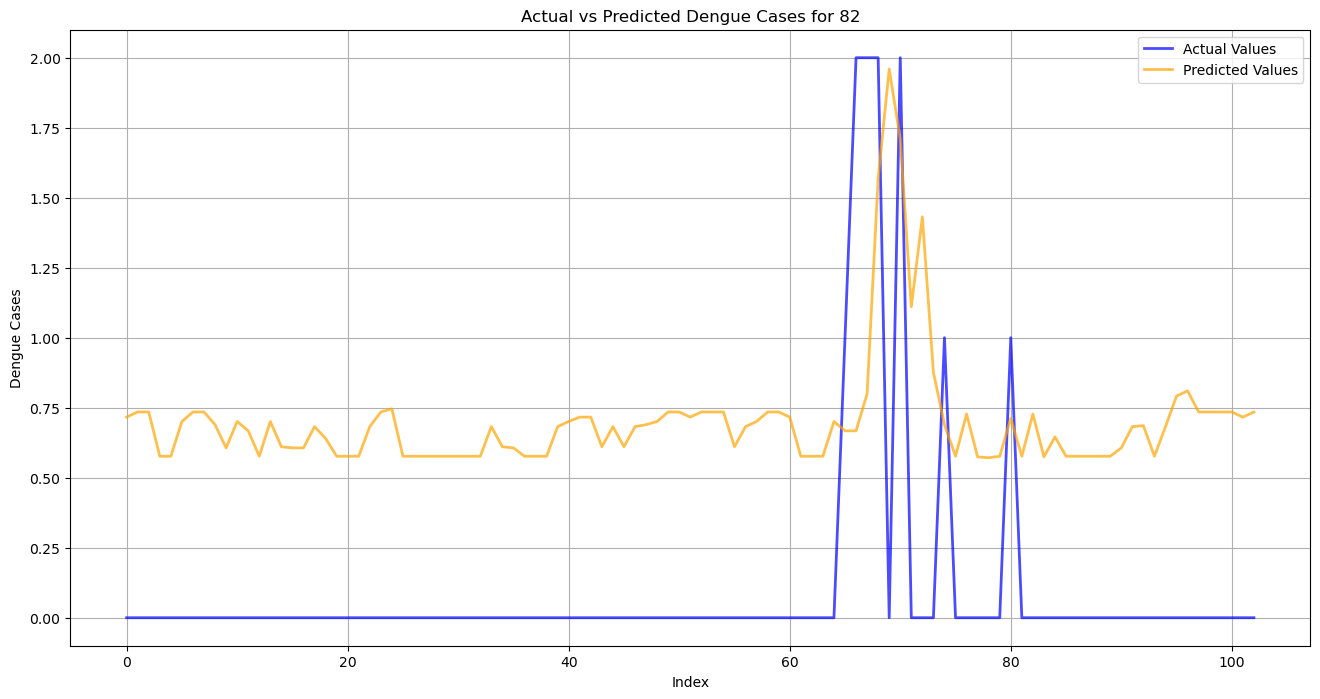

City: 69, RMSE: 1.3001331713552446


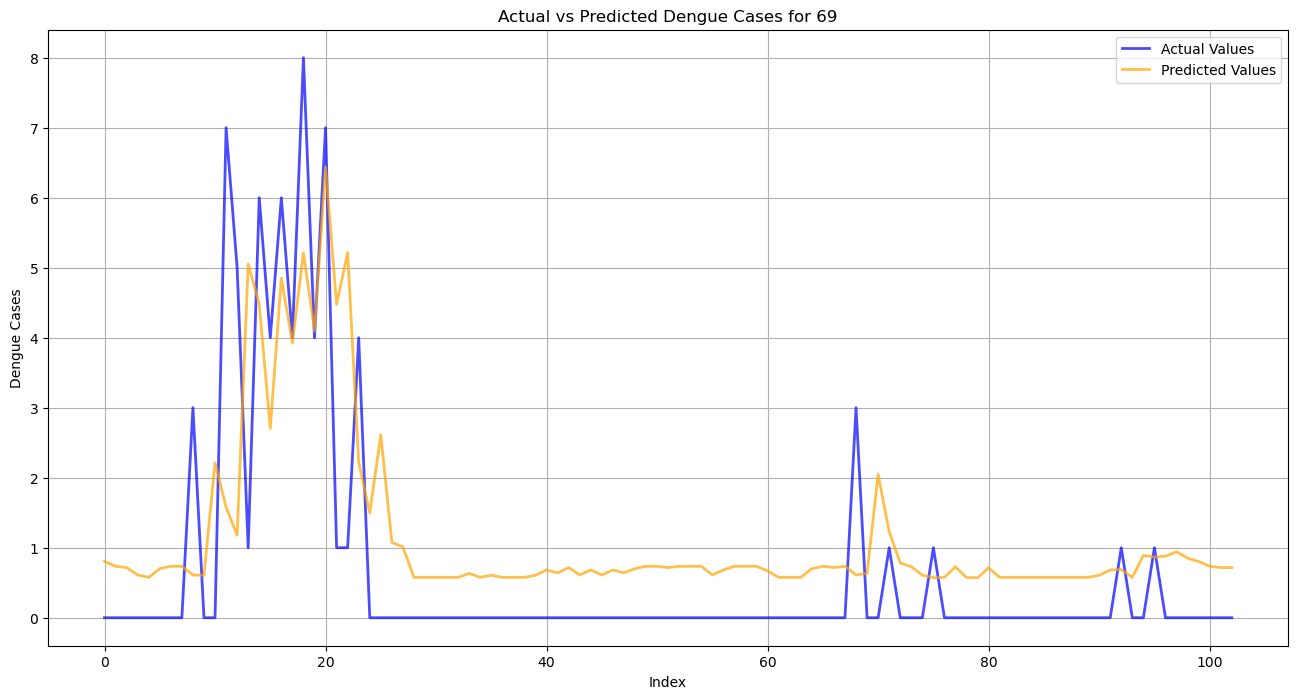

City: 70, RMSE: 4.1388670963779175


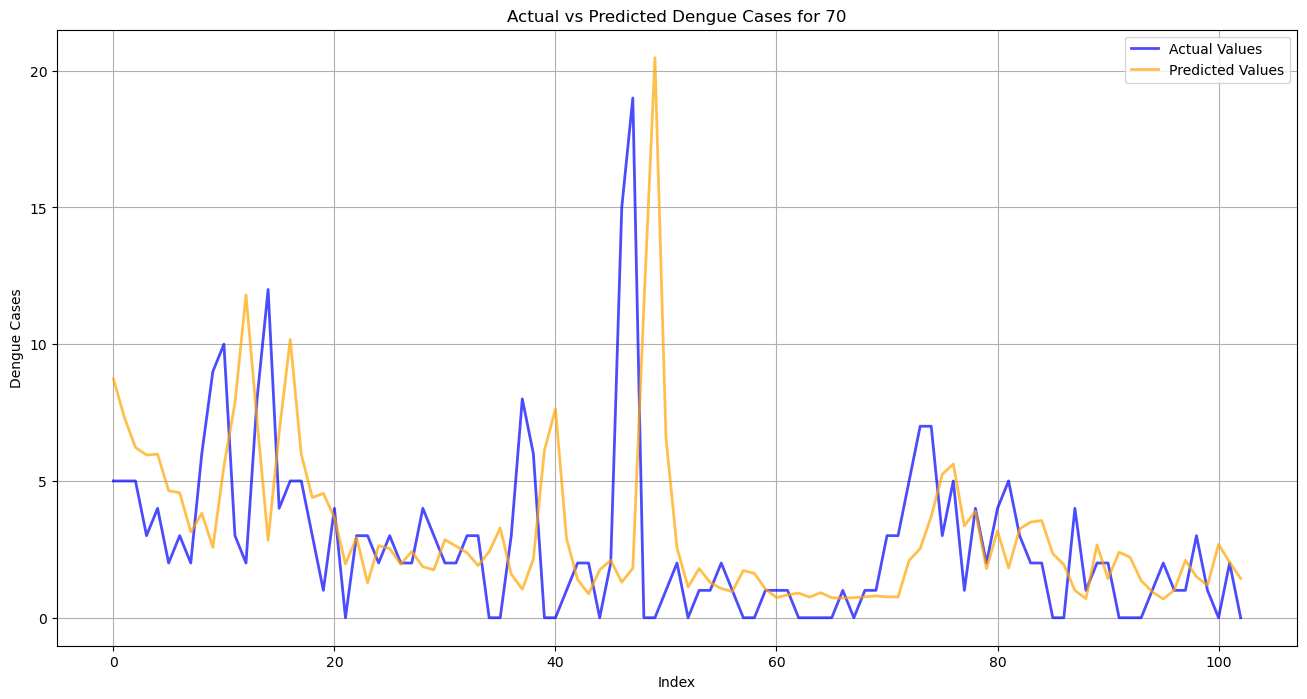

City: 71, RMSE: 3.5167446283472996


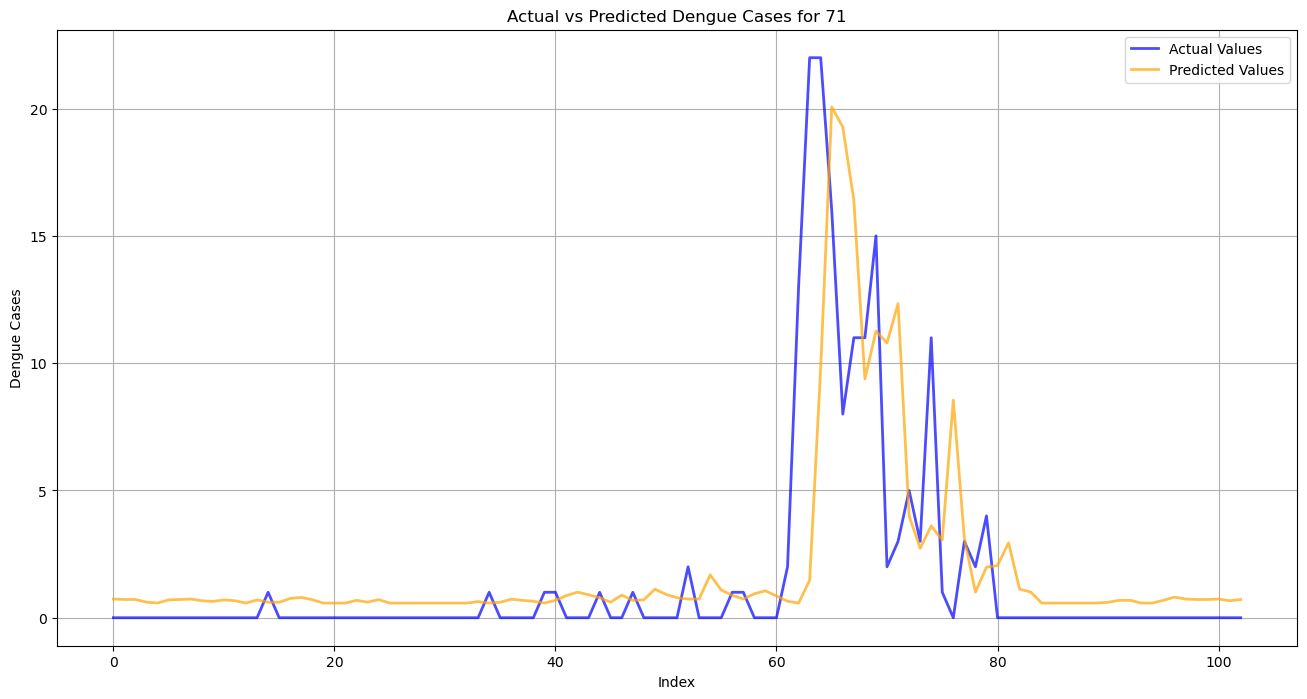

City: 72, RMSE: 0.6409651197931223


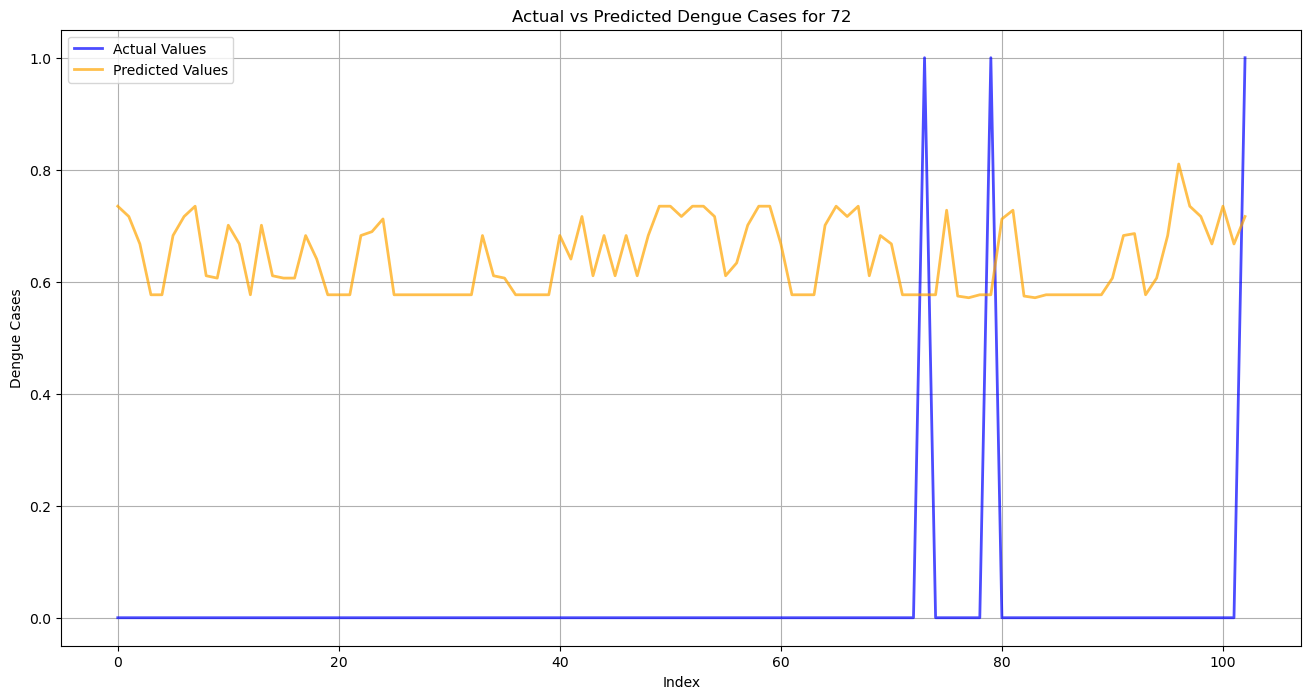

City: 73, RMSE: 0.6496876708686417


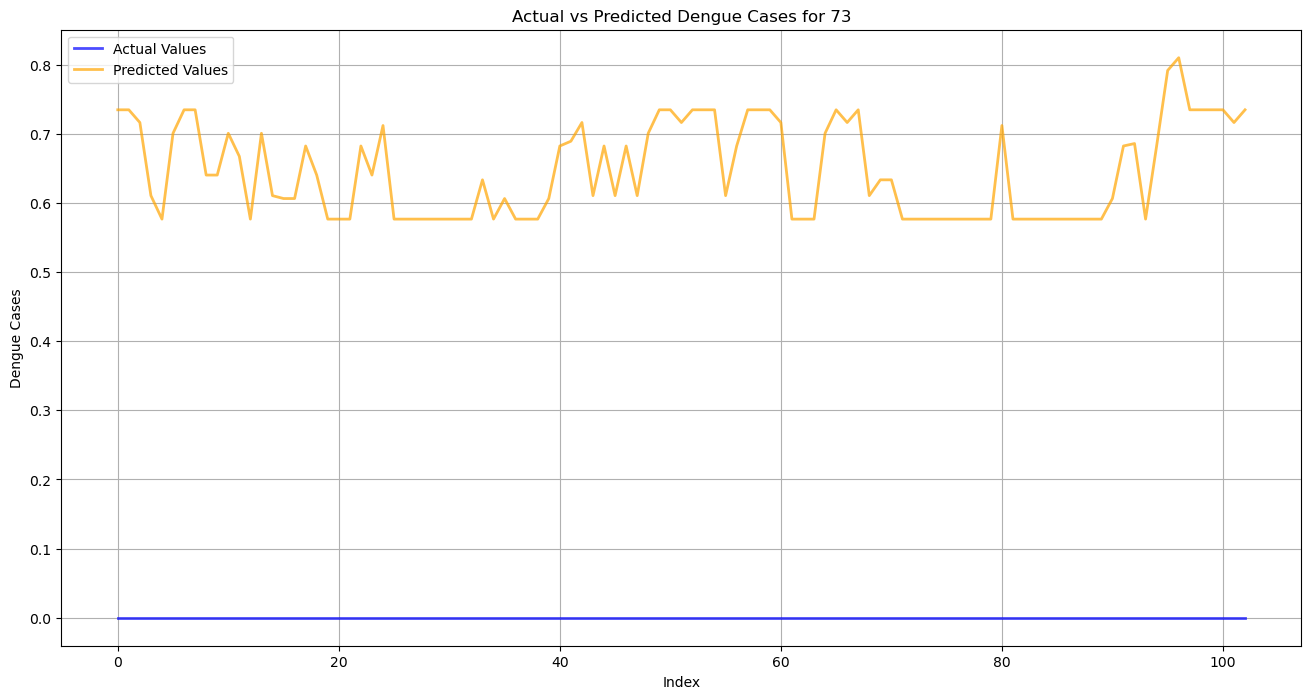

City: 83, RMSE: 0.7271096373093037


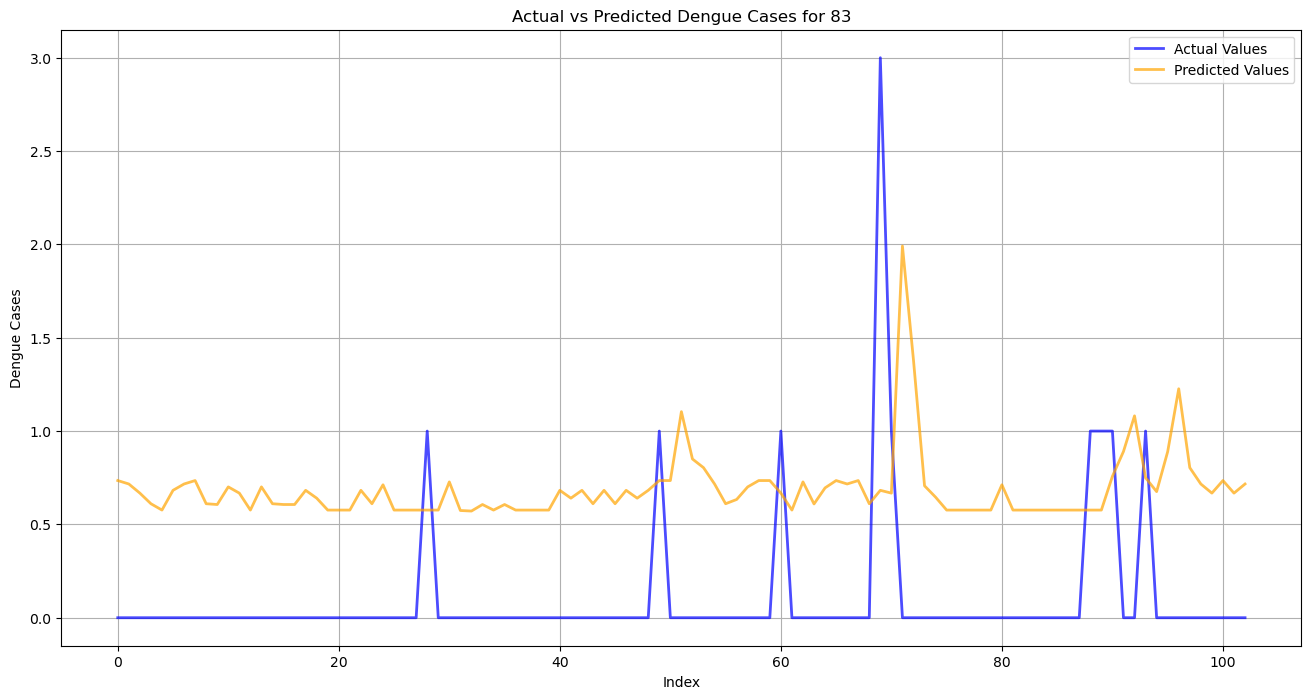

City: 84, RMSE: 0.6660402512835837


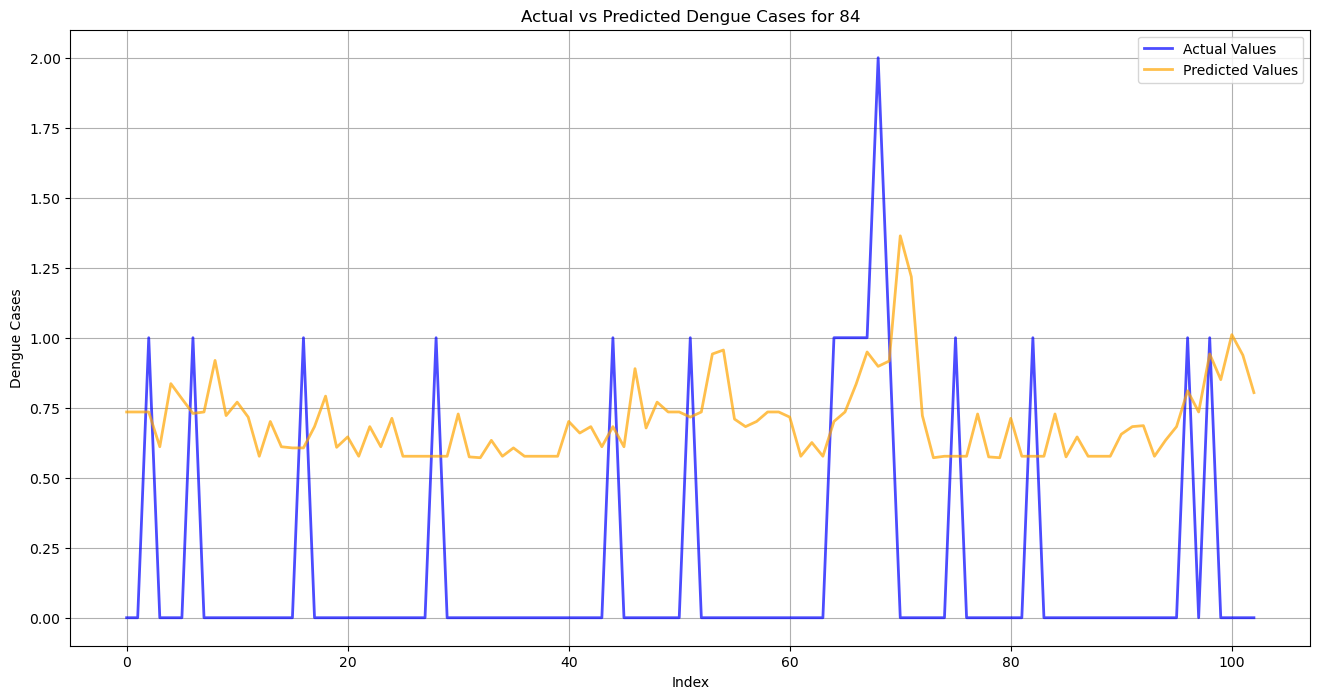

City: 85, RMSE: 0.6727429694507105


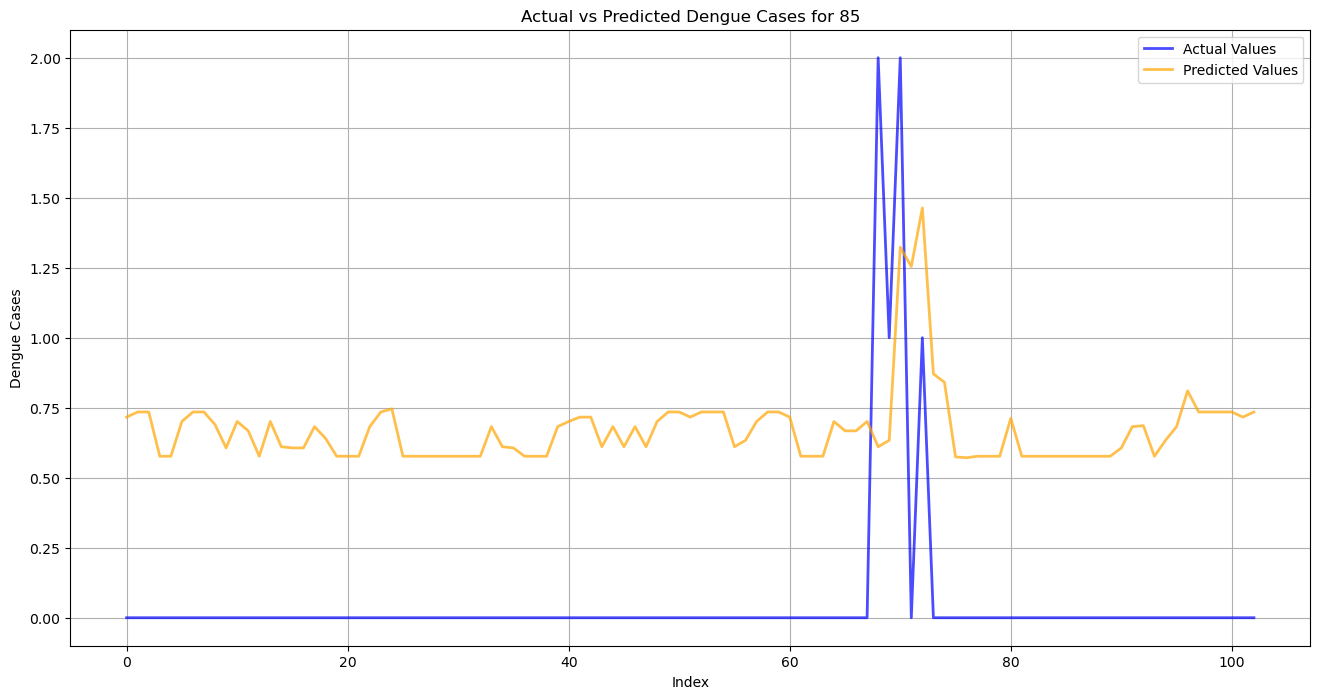

City: 86, RMSE: 1.5595089145220988


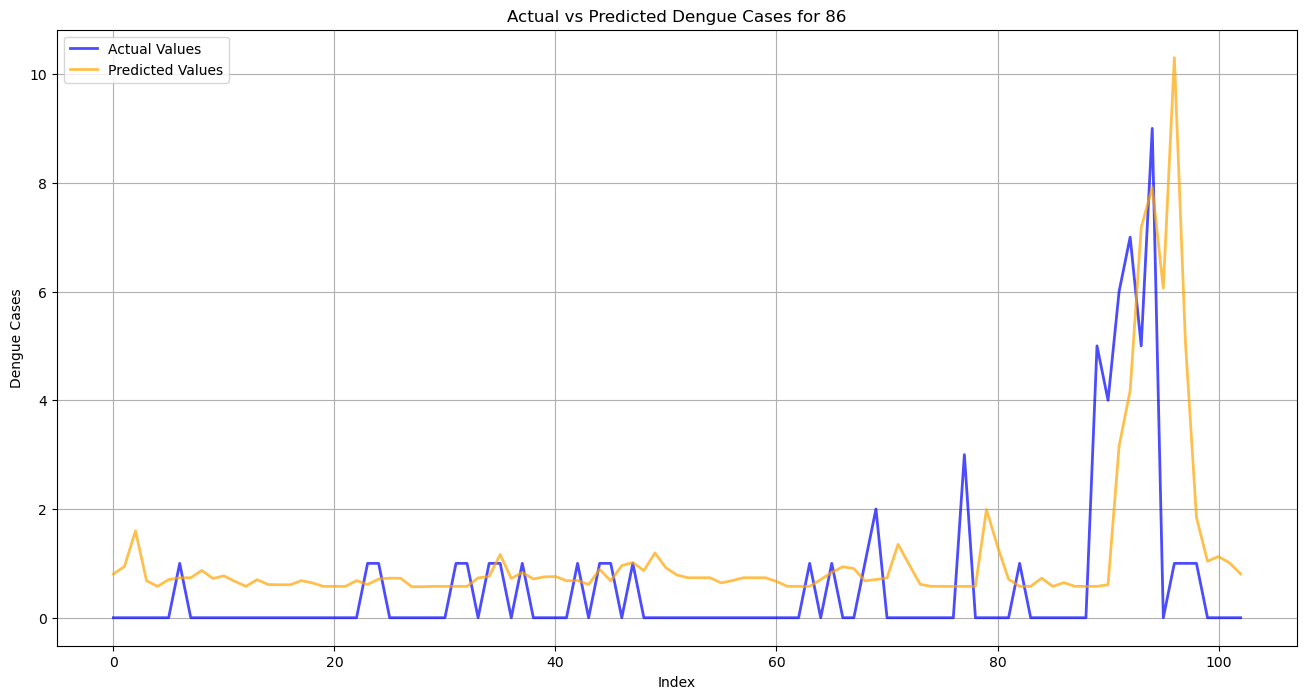

City: 87, RMSE: 2.575896428282508


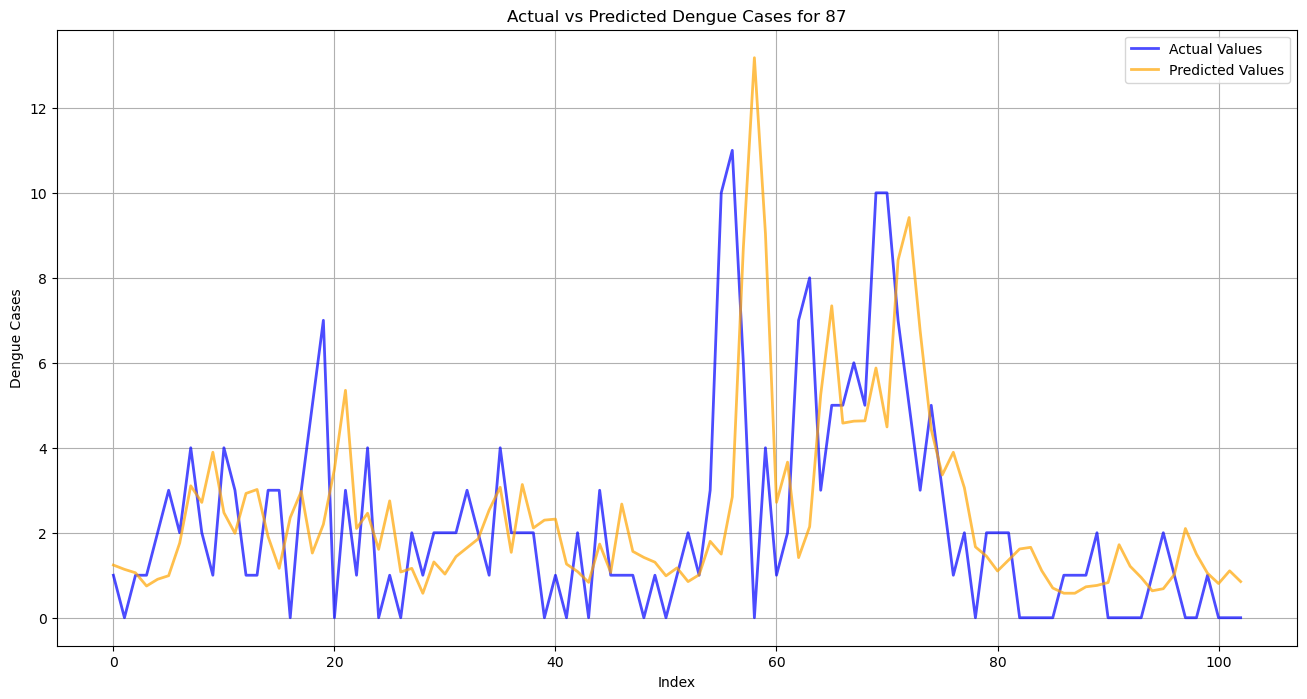

City: 88, RMSE: 0.6597720237500847


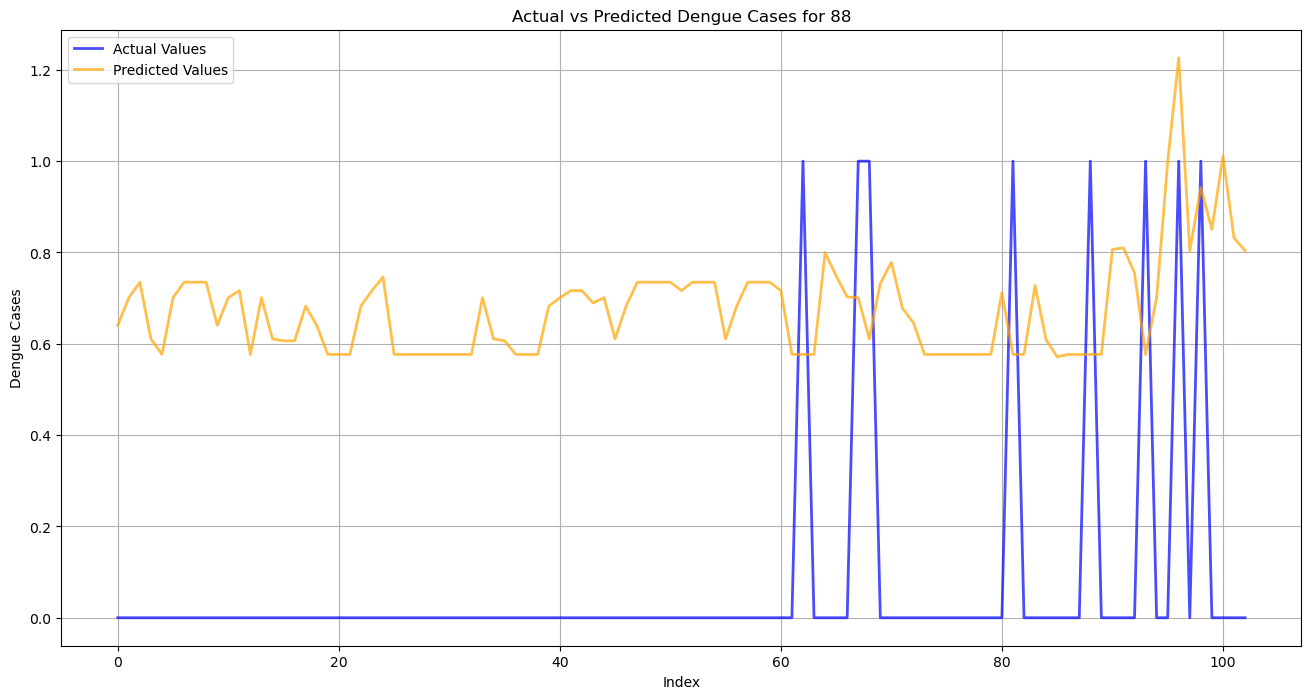

City: 89, RMSE: 2.1660204331488266


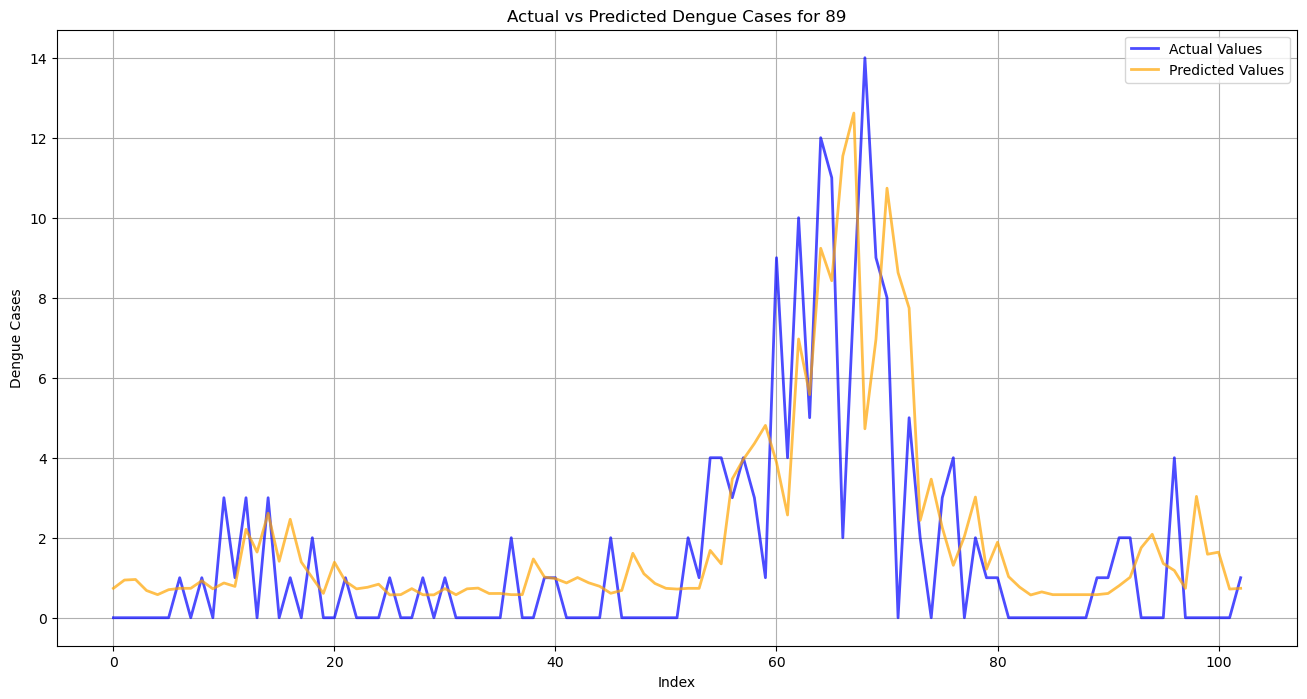

City: 90, RMSE: 3.374396102569753


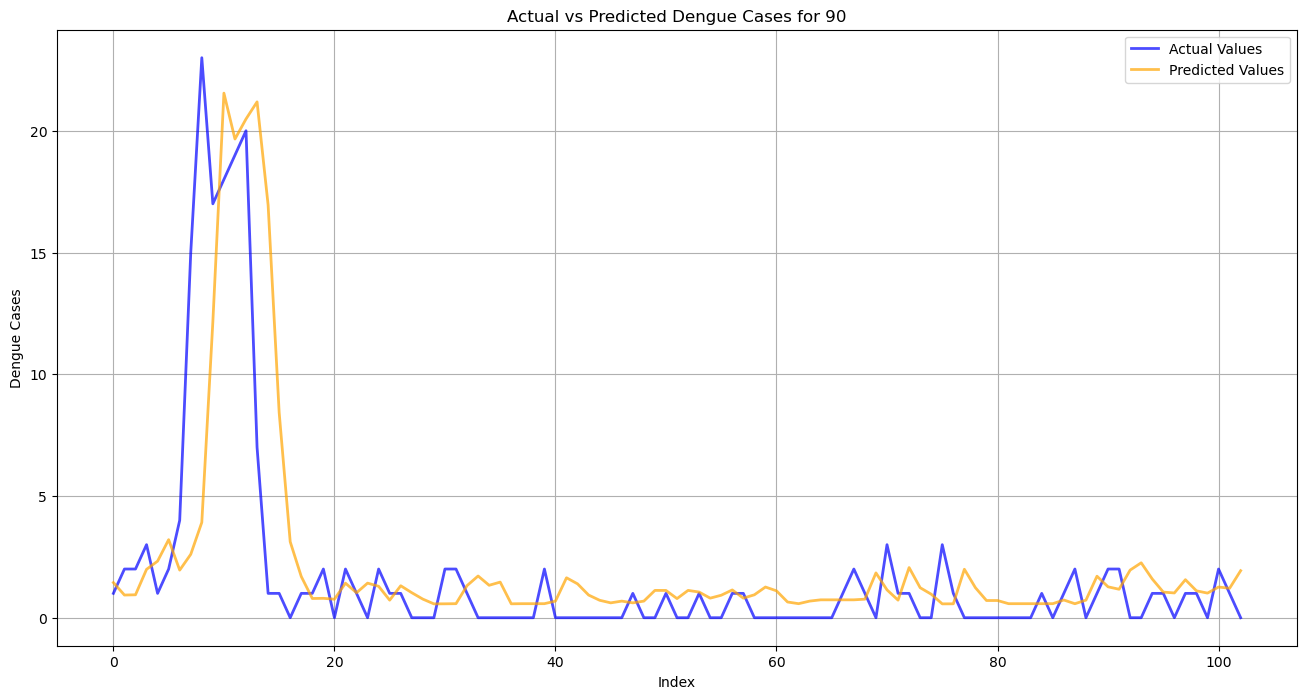

In [169]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'city' is present in X_test
cities = X_test['city_encoded'].unique()

# Iterate over each city
for city in cities:
    # Filter data for the city
    city_indices = X_test['city_encoded'] == city
    y_actual_city = target_scaler.inverse_transform(y_test[city_indices].values.reshape(-1, 1))
    y_pred_city = y_pred[city_indices]

    # # Skip the city if the maximum actual dengue cases are less than 10
    # if np.max(y_actual_city) < 10:
    #     continue

    # Apply ceiling operation to the predicted values
    # y_pred_city = np.ceil(y_pred_city)  # This will round up values like 2.4 to 3

    # Compute RMSE for the city
    rmse_city =  np.sqrt(mean_squared_error(y_actual_city, y_pred_city))
    print(f'City: {city}, RMSE: {rmse_city}')

    # Plot for the city
    plt.figure(figsize=(16, 8))
    plt.plot(np.arange(len(y_actual_city)), y_actual_city, label='Actual Values', color='blue', alpha=0.7, linewidth=2)
    plt.plot(np.arange(len(y_pred_city)), y_pred_city, label='Predicted Values', color='orange', alpha=0.7, linewidth=2)
    plt.xlabel('Index')
    plt.ylabel('Dengue Cases')
    plt.title(f'Actual vs Predicted Dengue Cases for {city}')
    plt.legend()
    plt.grid(True)
    plt.show()
